<a href="https://colab.research.google.com/github/GMouraBFR/E-Commerce-/blob/main/e_commerce_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importando e fazendo Upload de dados**

In [ ]:
import pandas as pd
import zipfile
from google.colab import files
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import scipy.stats as stats
from google.colab import files

# Fazendo upload do arquivo zip
uploaded = files.upload()



Saving ecommerce_dataset_us.csv to ecommerce_dataset_us (1).csv


Ler o arquivo CSV com o delimitador

In [ ]:
# Ler o arquivo CSV com o delimitador correto
ecommerce_data = pd.read_csv('ecommerce_dataset_us.csv', delimiter='\t')

# Verificar a estrutura dos dados
print(ecommerce_data.info())

# Exibir as primeiras linhas do DataFrame para verificar se foi carregado corretamente
print(ecommerce_data.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
dtypes: float64(2), int64(1), object(4)
memory usage: 28.9+ MB
None
  InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

  

Tratando Valores Ausentes e Convertendo Datas

<ipython-input-4-e974f73730ed>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'])


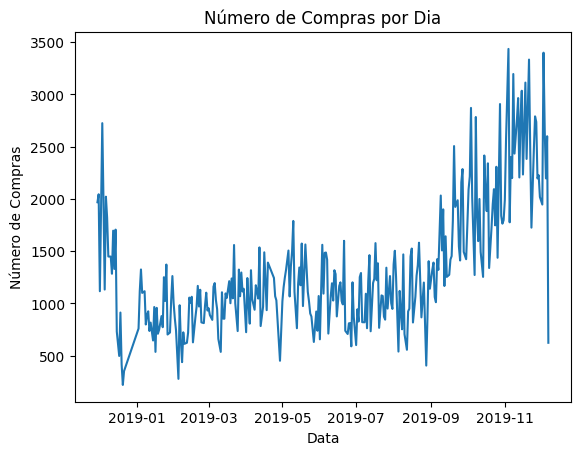

In [ ]:
# Tratar valores ausentes
ecommerce_data = ecommerce_data.loc[ecommerce_data['CustomerID'].notna()]

# Converter 'InvoiceDate' para datetime
ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'])

# Visualizações iniciais
ecommerce_data['InvoiceDate'].dt.date.value_counts().sort_index().plot(kind='line')
plt.title('Número de Compras por Dia')
plt.xlabel('Data')
plt.ylabel('Número de Compras')
plt.show()


Verificando Inconsistências nos Dados

In [ ]:
# Verificar inconsistências
print("Valores negativos em 'Quantity':", ecommerce_data[ecommerce_data['Quantity'] < 0].shape[0])
print("Valores negativos em 'UnitPrice':", ecommerce_data[ecommerce_data['UnitPrice'] < 0].shape[0])
print("Duplicatas no dataset:", ecommerce_data.duplicated().sum())

# Verificar dados faltantes
print("\nDados faltantes por coluna:")
print(ecommerce_data.isnull().sum() / len(ecommerce_data) * 100)


Valores negativos em 'Quantity': 8905
Valores negativos em 'UnitPrice': 0
Duplicatas no dataset: 5225

Dados faltantes por coluna:
InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
dtype: float64


Verificando Outliers e Distribuições

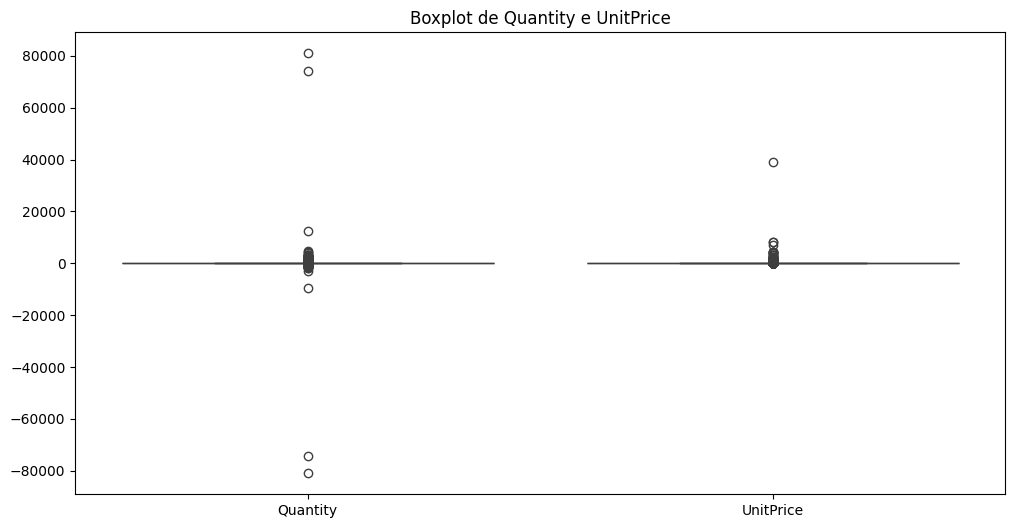

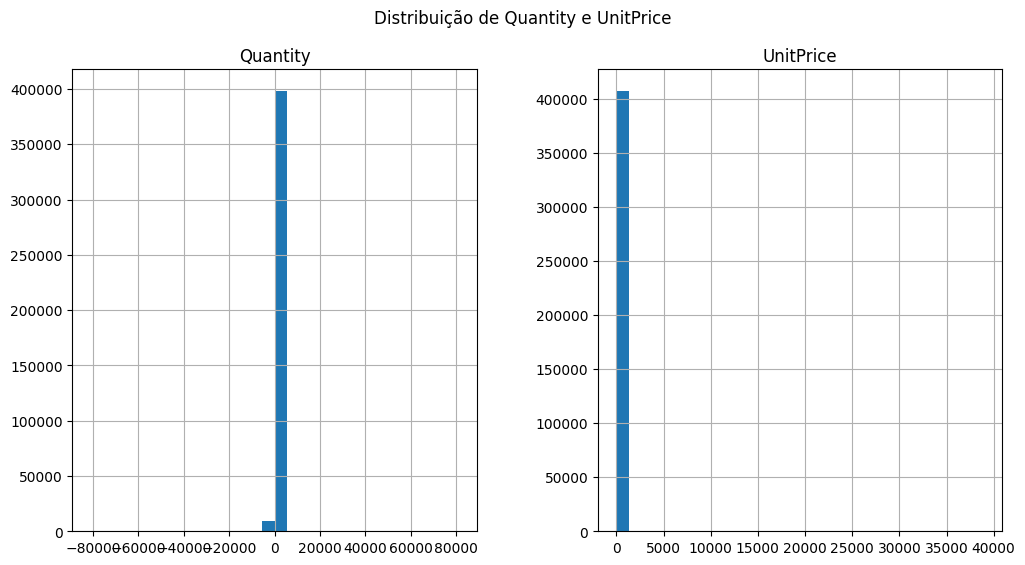

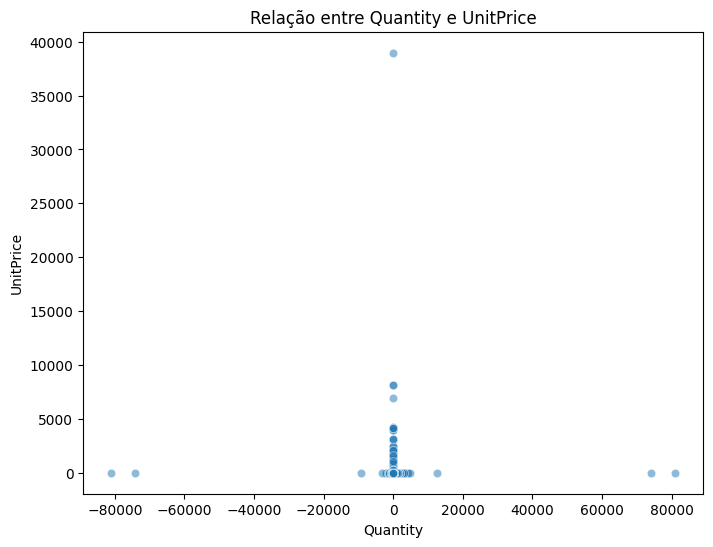

In [ ]:
# Verificar outliers
plt.figure(figsize=(12, 6))
sns.boxplot(data=ecommerce_data[['Quantity', 'UnitPrice']])
plt.title('Boxplot de Quantity e UnitPrice')
plt.show()

# Analisar distribuição das variáveis numéricas
ecommerce_data[['Quantity', 'UnitPrice']].hist(bins=30, figsize=(12, 6))
plt.suptitle('Distribuição de Quantity e UnitPrice')
plt.show()

# Analisar a relação entre Quantity e UnitPrice
plt.figure(figsize=(8, 6))
sns.scatterplot(data=ecommerce_data, x='Quantity', y='UnitPrice', alpha=0.5)
plt.title('Relação entre Quantity e UnitPrice')
plt.show()


Verificando Correlações

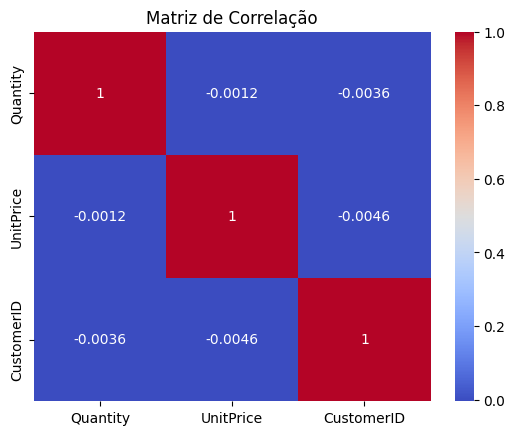

In [ ]:
# Verificar correlações
corr_matrix = ecommerce_data.corr(numeric_only=True)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação')
plt.show()


Tratando Outliers e Dados Faltantes

In [ ]:
# Tratar outliers em 'Quantity' e 'UnitPrice'
ecommerce_data = ecommerce_data[(ecommerce_data['Quantity'] > 0) & (ecommerce_data['UnitPrice'] > 0)]

# Tratar dados faltantes (por exemplo, remover registros sem 'CustomerID')
ecommerce_data = ecommerce_data.loc[ecommerce_data['CustomerID'].notna()]


Calculando Métricas RFM

In [ ]:
# Calcular métricas RFM
ecommerce_data['InvoiceDate'] = pd.to_datetime(ecommerce_data['InvoiceDate'])
now = ecommerce_data['InvoiceDate'].max()
rfm = ecommerce_data.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (now - x.max()).days,
    'InvoiceNo': 'count',
    'UnitPrice': lambda x: (x * ecommerce_data.loc[x.index, 'Quantity']).sum()
}).rename(columns={
    'InvoiceDate': 'Recency',
    'InvoiceNo': 'Frequency',
    'UnitPrice': 'Monetary'
})

# Dividir em quantis e calcular pontuação
quantiles = rfm.quantile(q=[0.25, 0.5, 0.75])

def rfm_score(x, p, d):
    if x <= p[d][0.25]:
        return 1
    elif x <= p[d][0.50]:
        return 2
    elif x <= p[d][0.75]:
        return 3
    else:
        return 4

rfm['R'] = rfm['Recency'].apply(rfm_score, args=(quantiles, 'Recency'))
rfm['F'] = rfm['Frequency'].apply(rfm_score, args=(quantiles, 'Frequency'))
rfm['M'] = rfm['Monetary'].apply(rfm_score, args=(quantiles, 'Monetary'))
rfm['RFM_Score'] = rfm['R'].map(str) + rfm['F'].map(str) + rfm['M'].map(str)


Visualizando a Segmentação RFM

            Recency  Frequency  Monetary  R  F  M RFM_Score
CustomerID                                                 
12346.0         325          1  77183.60  4  1  4       414
12347.0           1        182   4310.00  1  4  4       144
12348.0          74         31   1797.24  3  2  4       324
12349.0          18         73   1757.55  2  3  4       234
12350.0         309         17    334.40  4  1  2       412


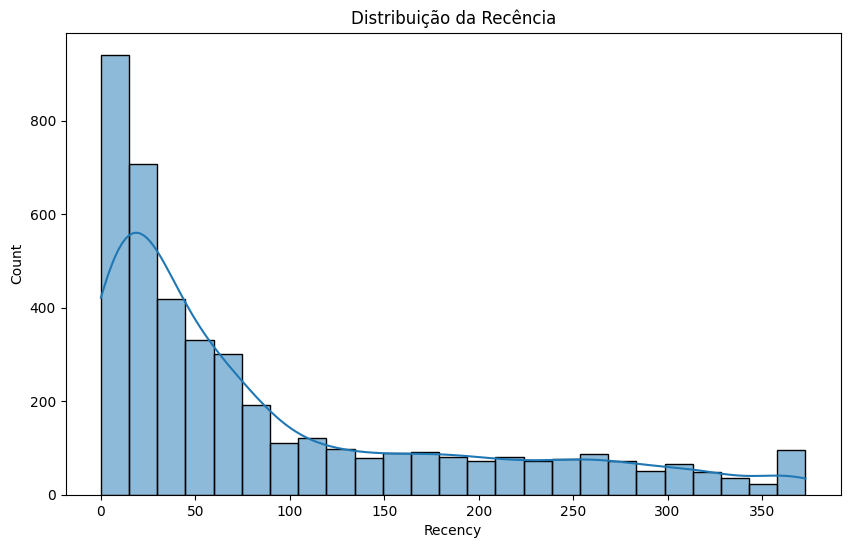

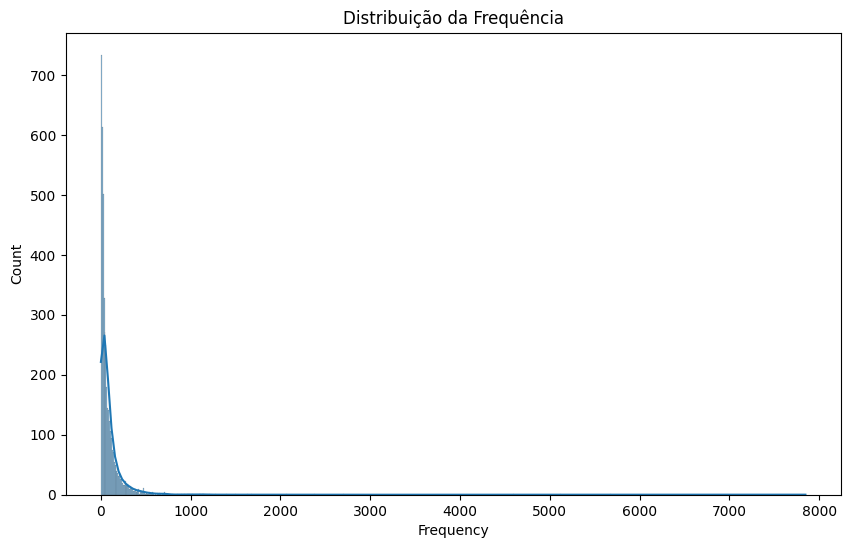

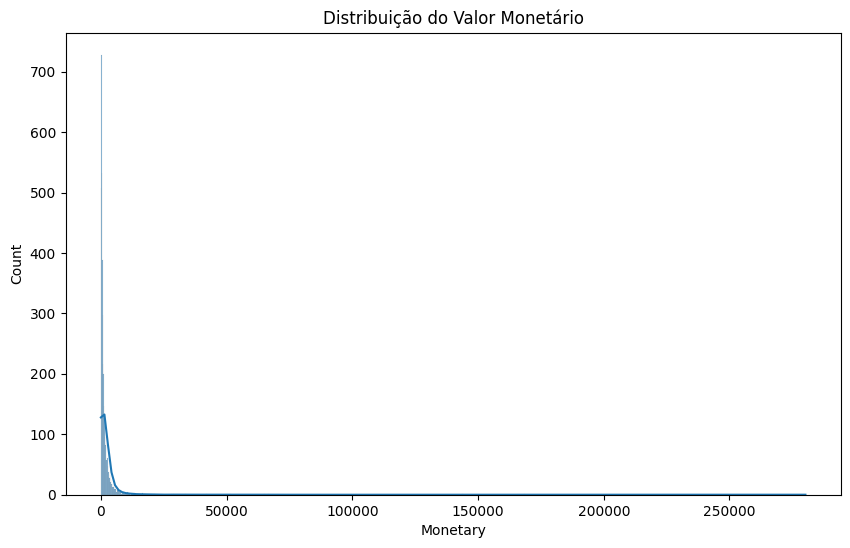

In [ ]:
# Visualizar a segmentação RFM
print(rfm.head())

# Visualização das métricas RFM
plt.figure(figsize=(10, 6))
sns.histplot(rfm['Recency'], kde=True)
plt.title('Distribuição da Recência')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(rfm['Frequency'], kde=True)
plt.title('Distribuição da Frequência')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(rfm['Monetary'], kde=True)
plt.title('Distribuição do Valor Monetário')
plt.show()


Analisando Cada Segmento RFM

Segmento RFM 414
Número de Clientes: 10
Recência Média: 249.9
Frequência Média: 6.7
Monetário Médio: 17815.672


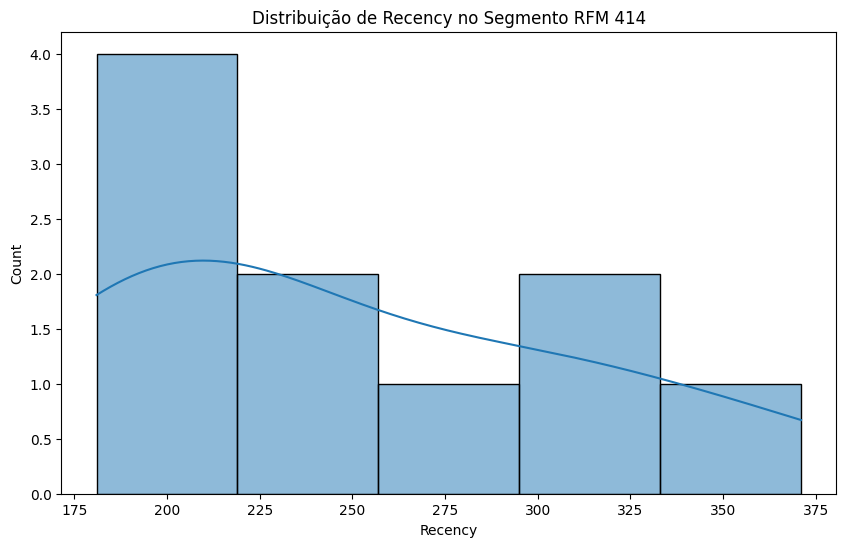

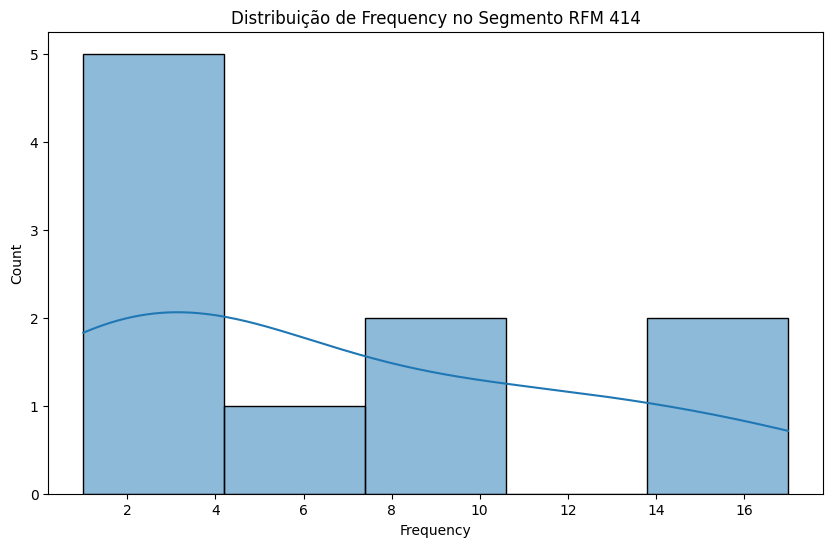

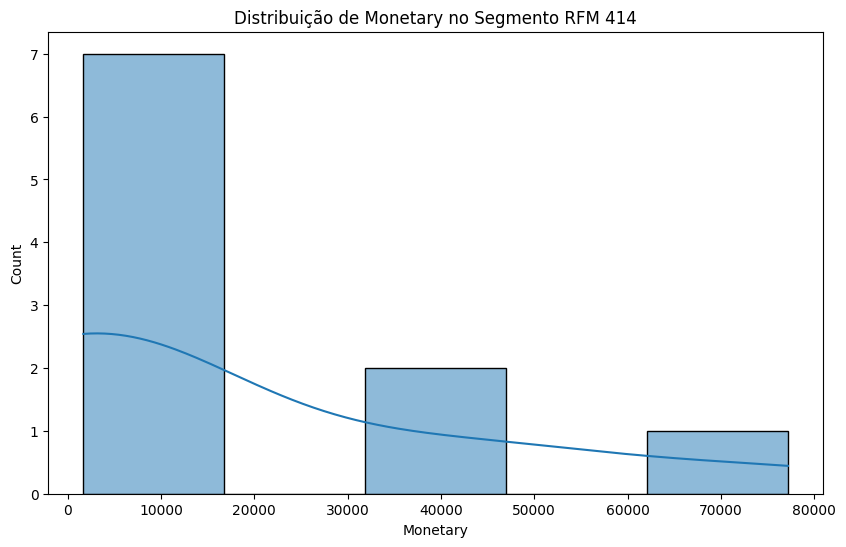



Segmento RFM 144
Número de Clientes: 447
Recência Média: 6.279642058165548
Frequência Média: 374.4474272930649
Monetário Médio: 9319.207964205816


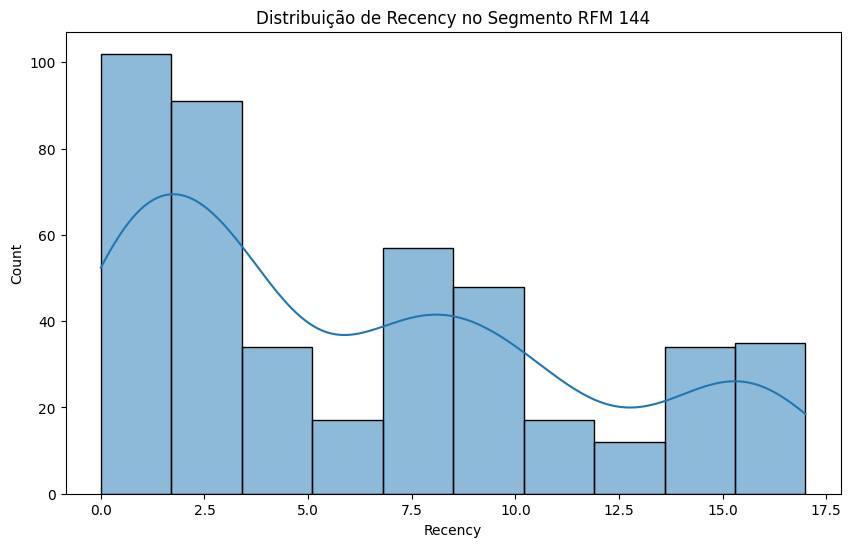

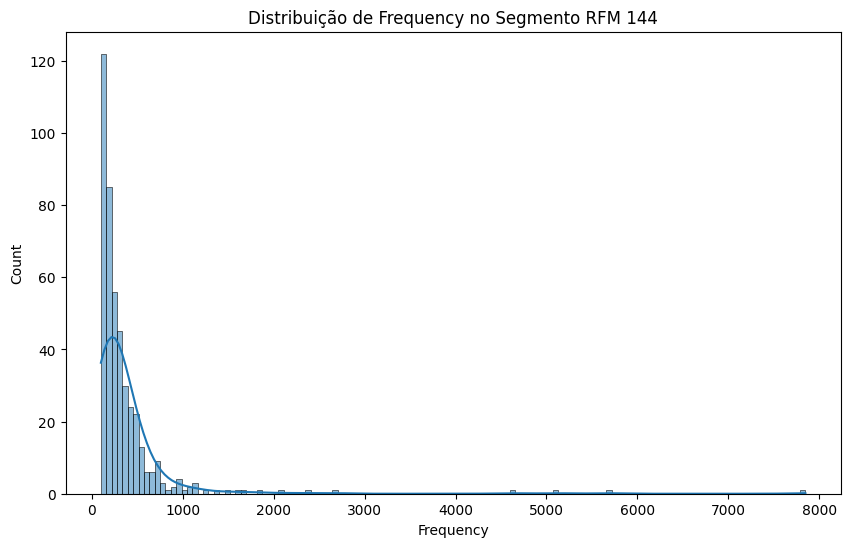

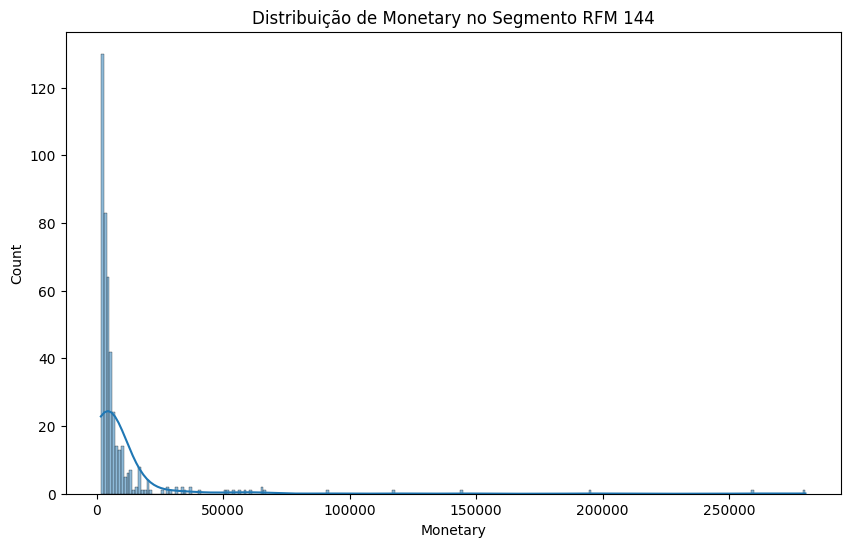



Segmento RFM 324
Número de Clientes: 15
Recência Média: 89.73333333333333
Frequência Média: 30.333333333333332
Monetário Médio: 3322.329333333333


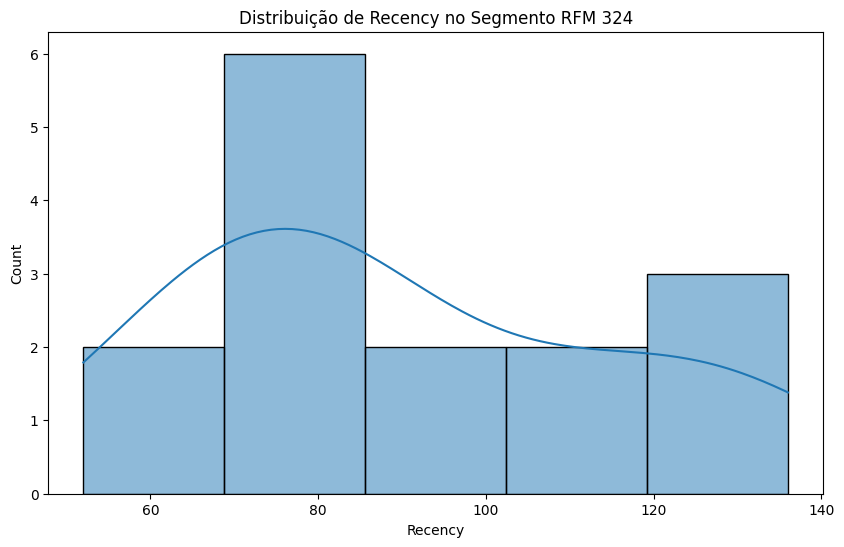

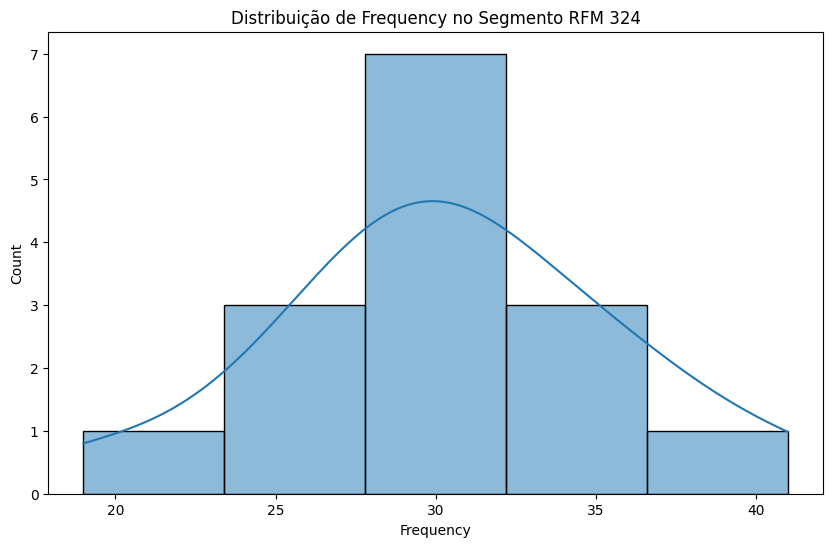

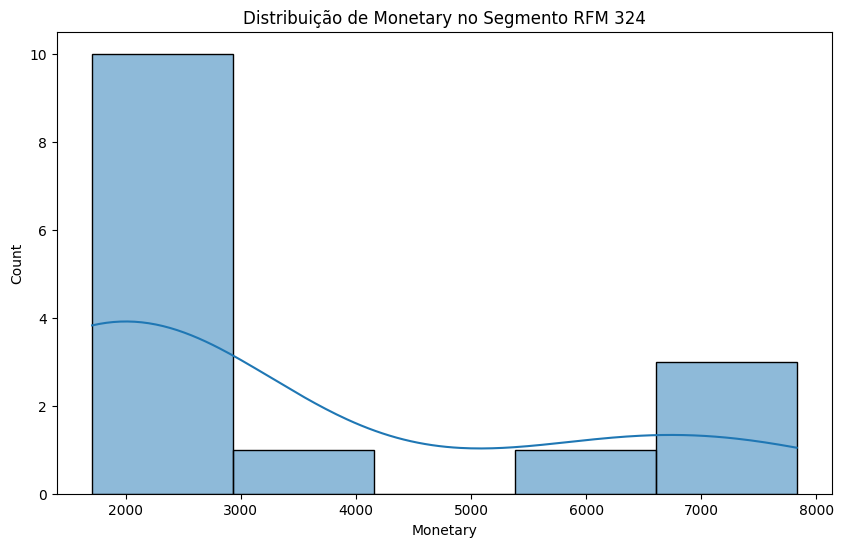



Segmento RFM 234
Número de Clientes: 58
Recência Média: 30.29310344827586
Frequência Média: 75.44827586206897
Monetário Médio: 3439.536034482759


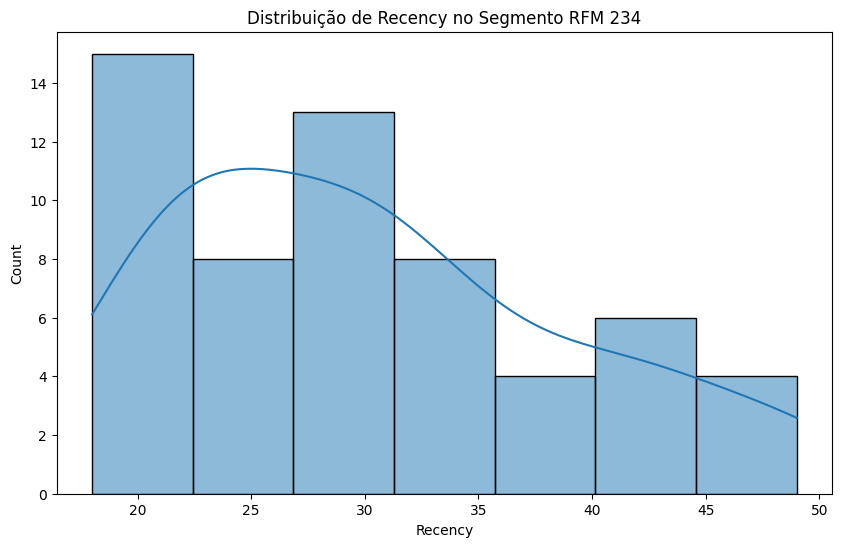

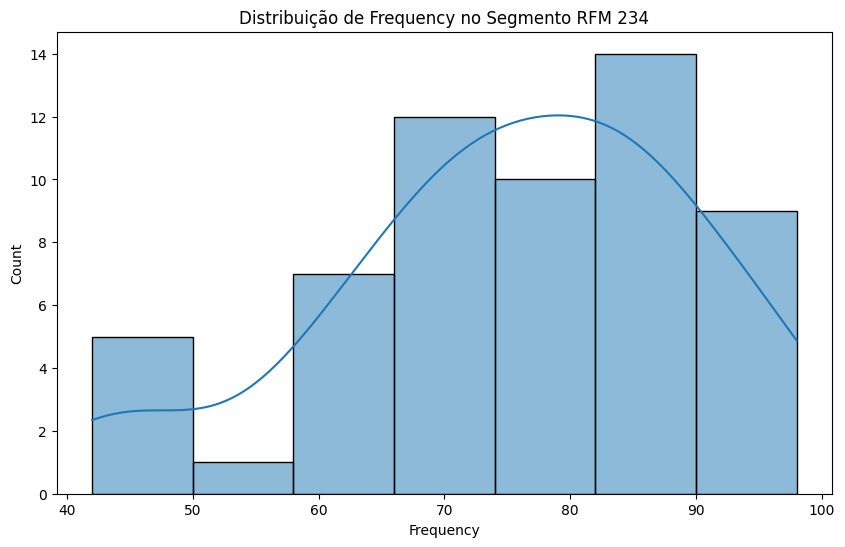

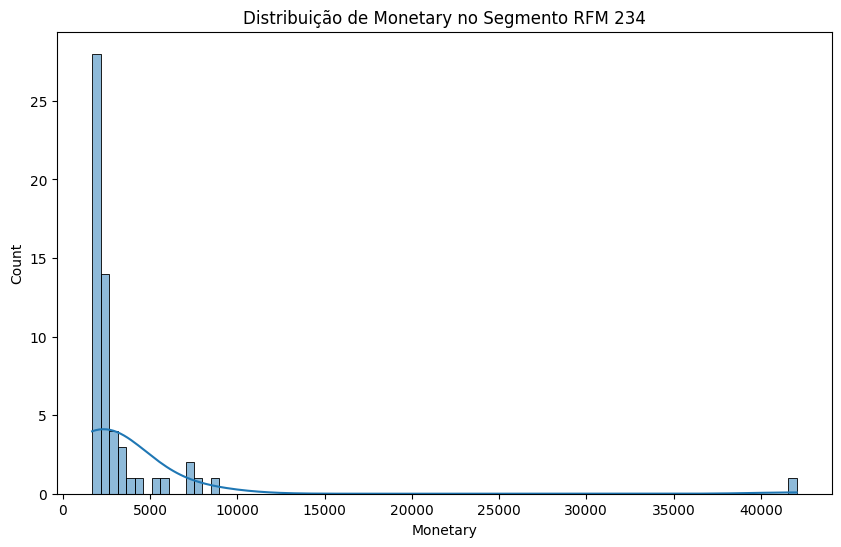



Segmento RFM 412
Número de Clientes: 104
Recência Média: 254.77884615384616
Frequência Média: 10.365384615384615
Monetário Médio: 396.5614423076923


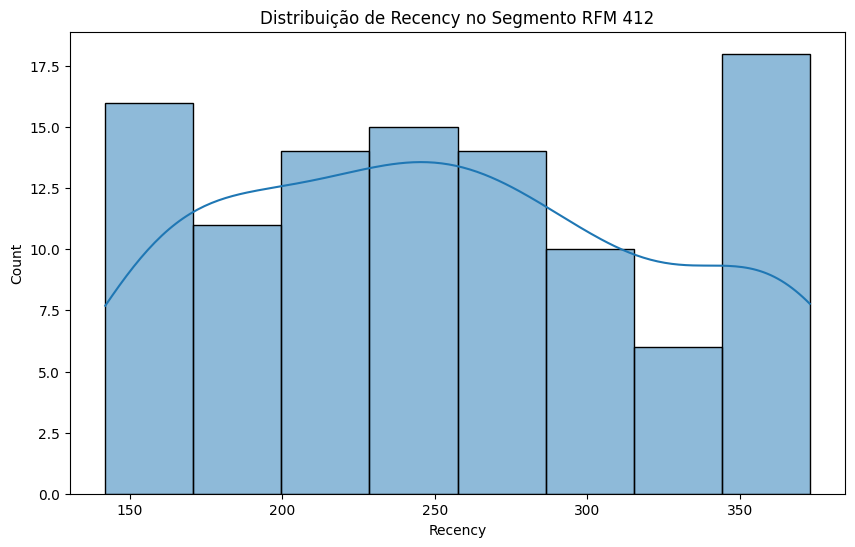

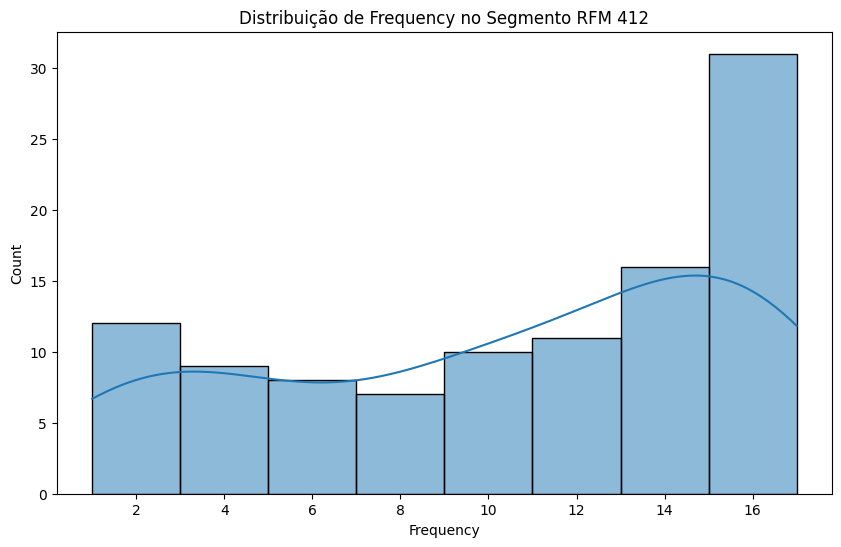

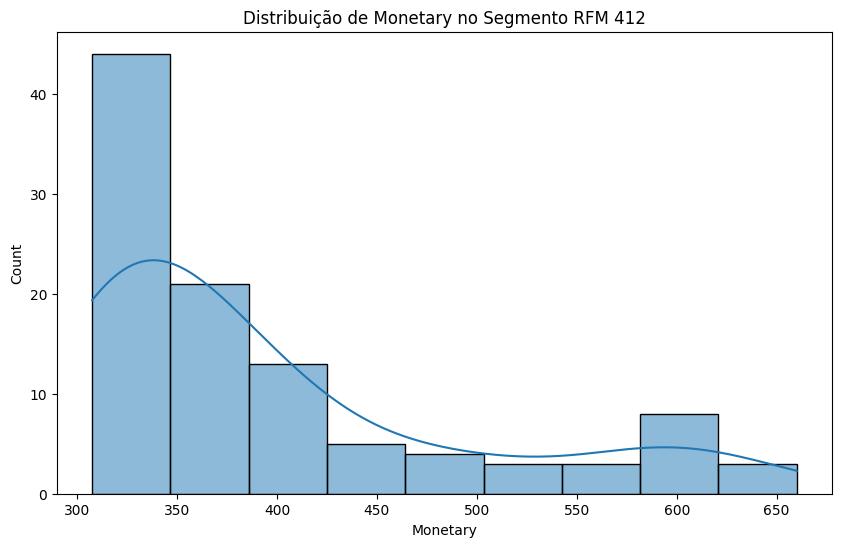



Segmento RFM 411
Número de Clientes: 385
Recência Média: 259.8467532467532
Frequência Média: 8.233766233766234
Monetário Médio: 159.31025974025974


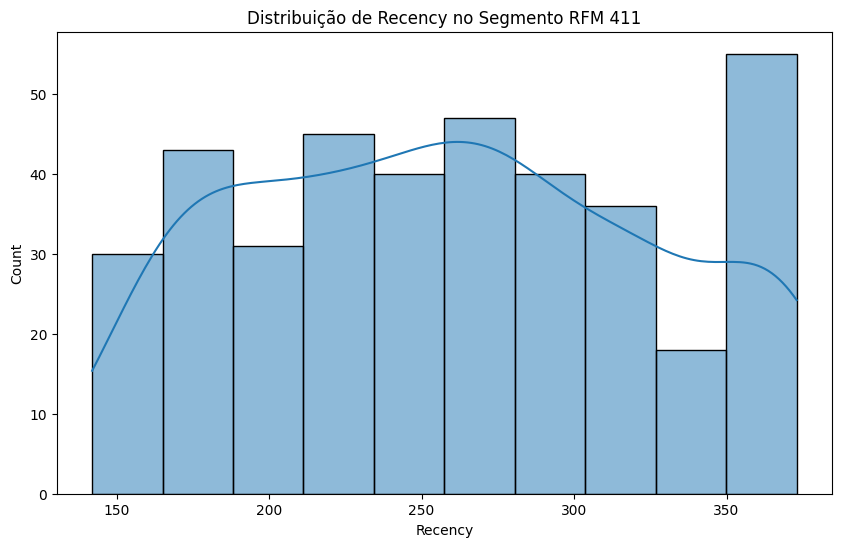

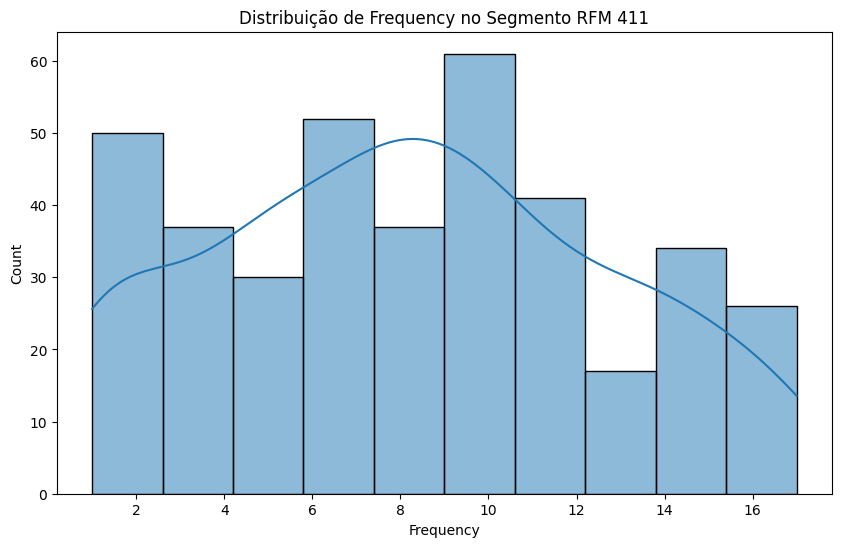

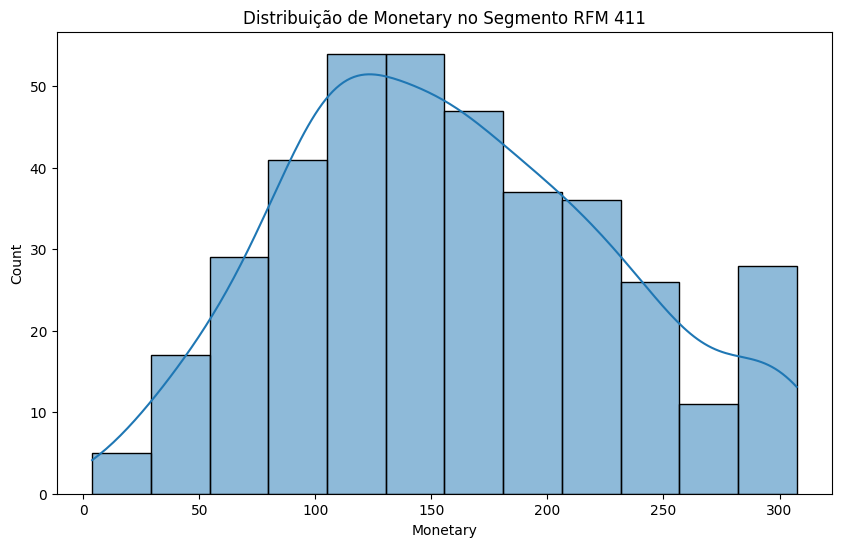



Segmento RFM 433
Número de Clientes: 71
Recência Média: 207.46478873239437
Frequência Média: 62.12676056338028
Monetário Médio: 1070.3953521126764


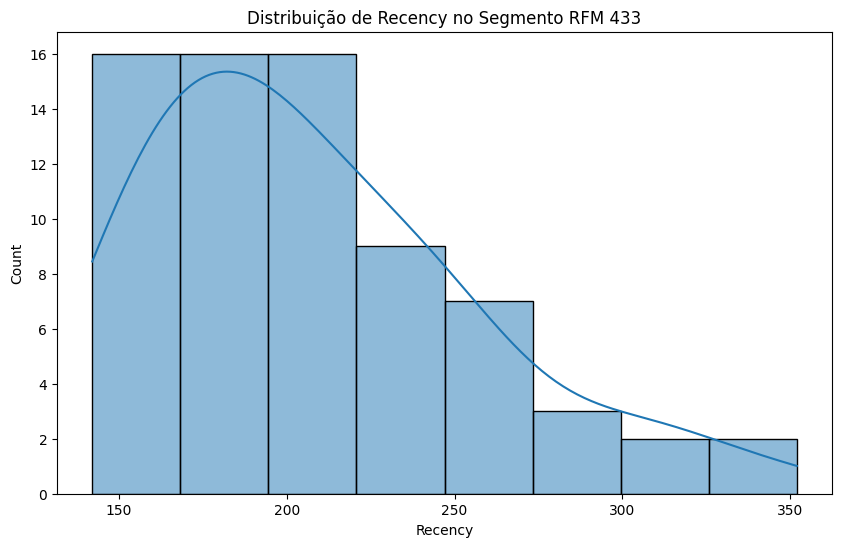

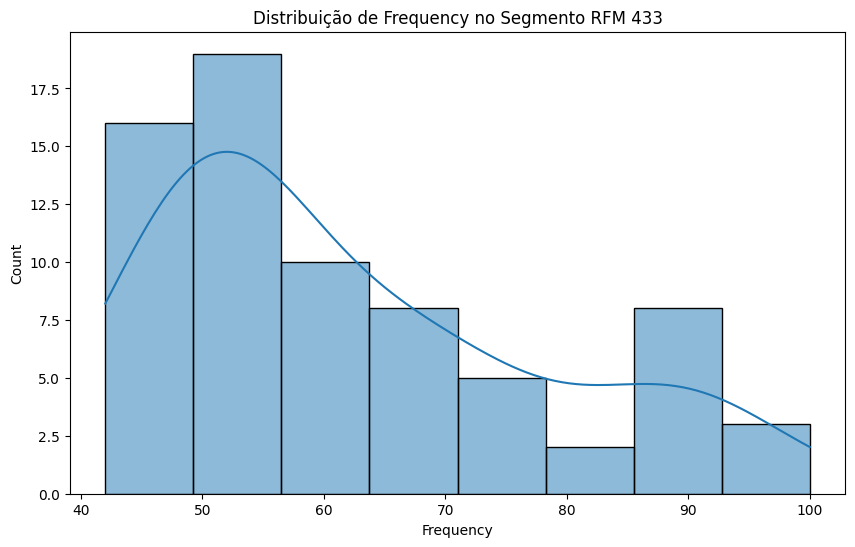

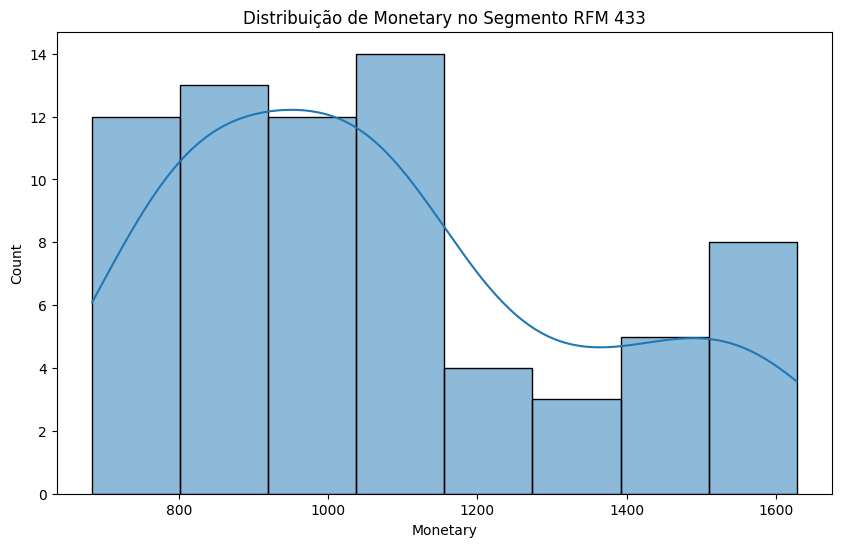



Segmento RFM 244
Número de Clientes: 217
Recência Média: 30.34562211981567
Frequência Média: 231.91705069124424
Monetário Médio: 5141.526820276498


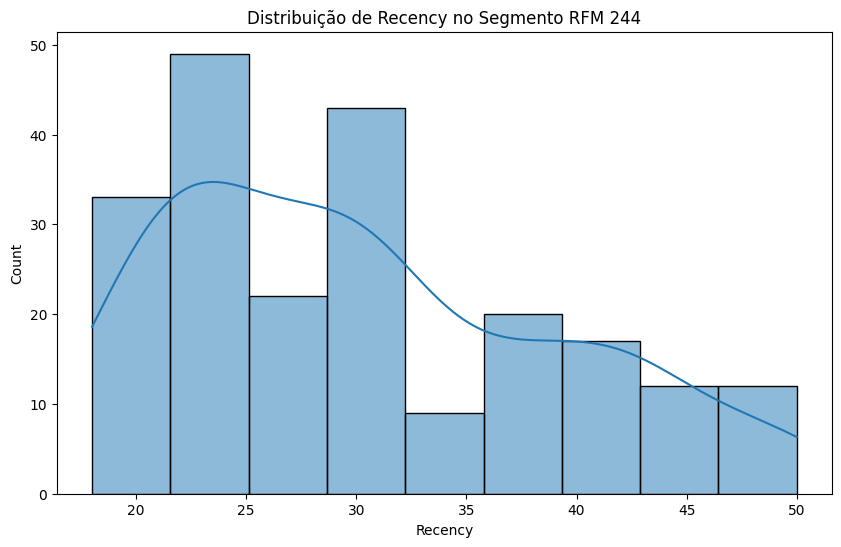

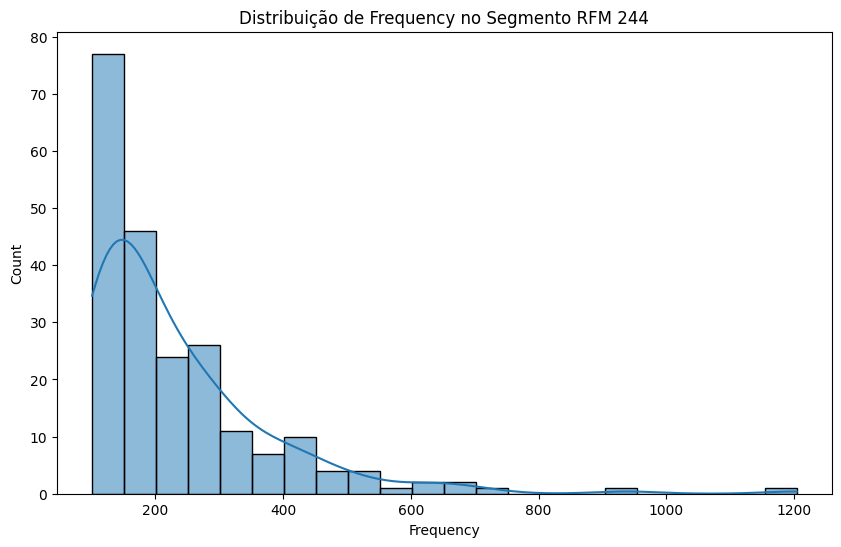

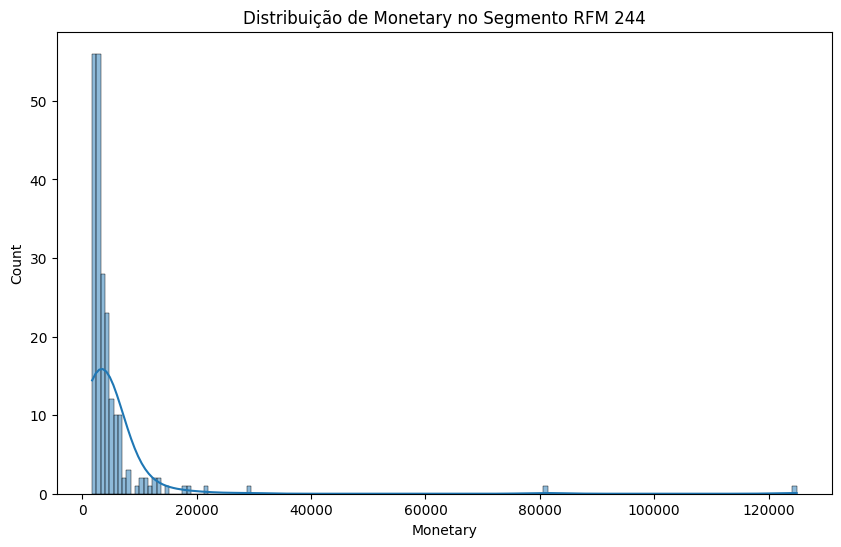



Segmento RFM 123
Número de Clientes: 45
Recência Média: 7.733333333333333
Frequência Média: 32.08888888888889
Monetário Médio: 939.0771111111111


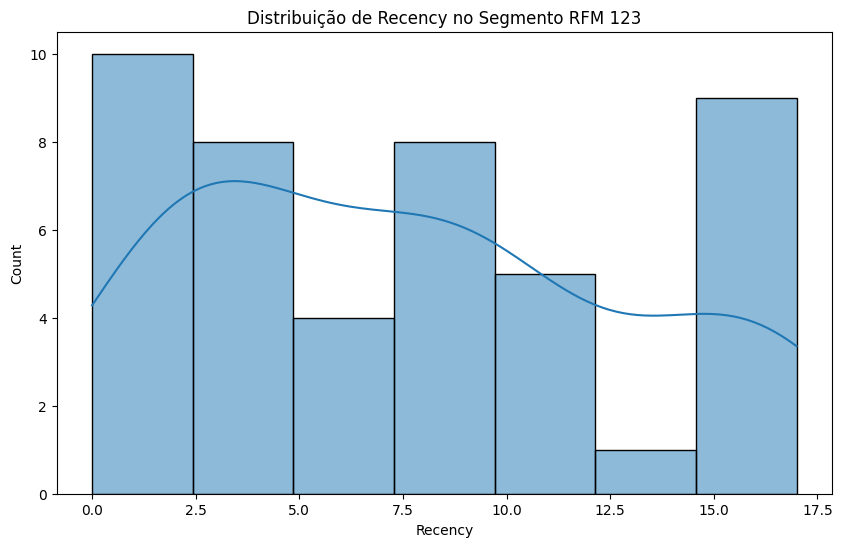

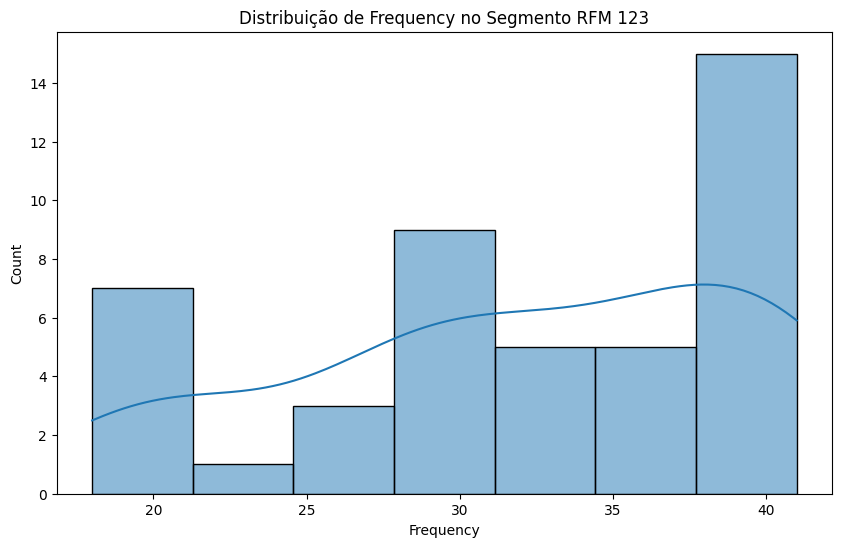

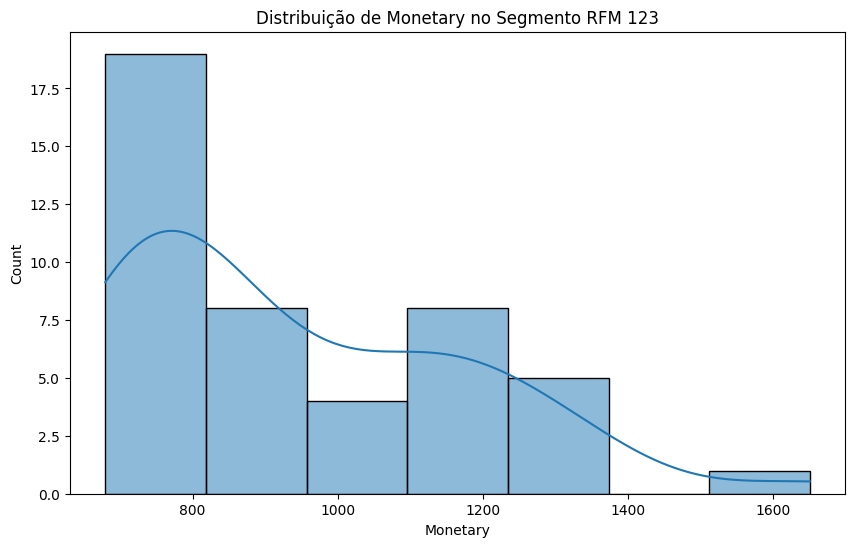



Segmento RFM 344
Número de Clientes: 101
Recência Média: 74.56435643564356
Frequência Média: 168.05940594059405
Monetário Médio: 3317.027524752475


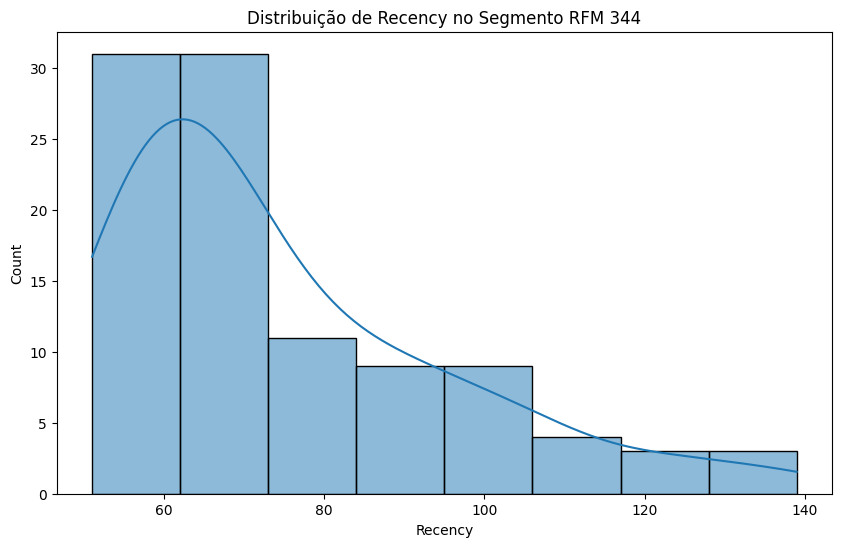

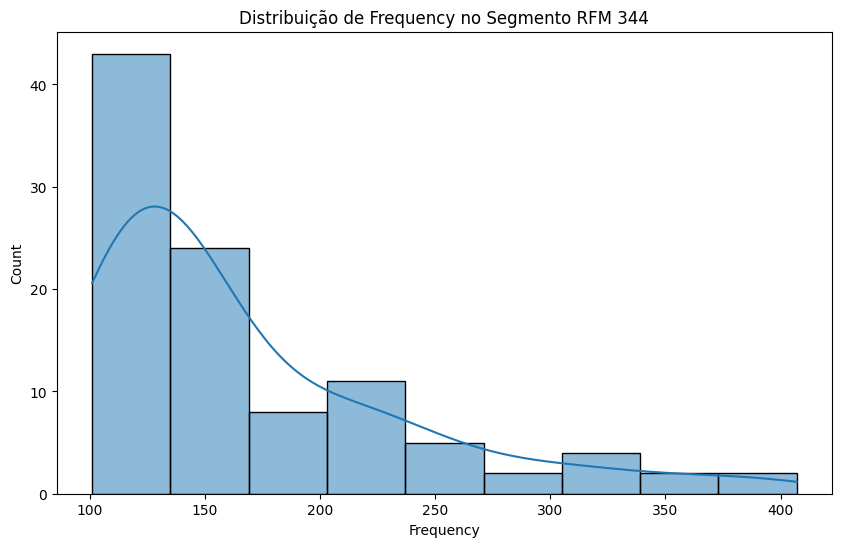

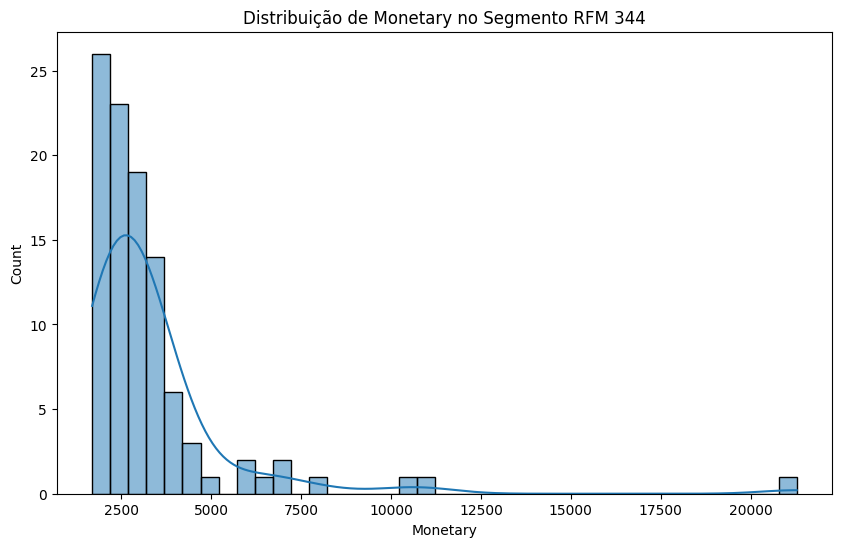



Segmento RFM 322
Número de Clientes: 160
Recência Média: 85.23125
Frequência Média: 27.31875
Monetário Médio: 473.00369375


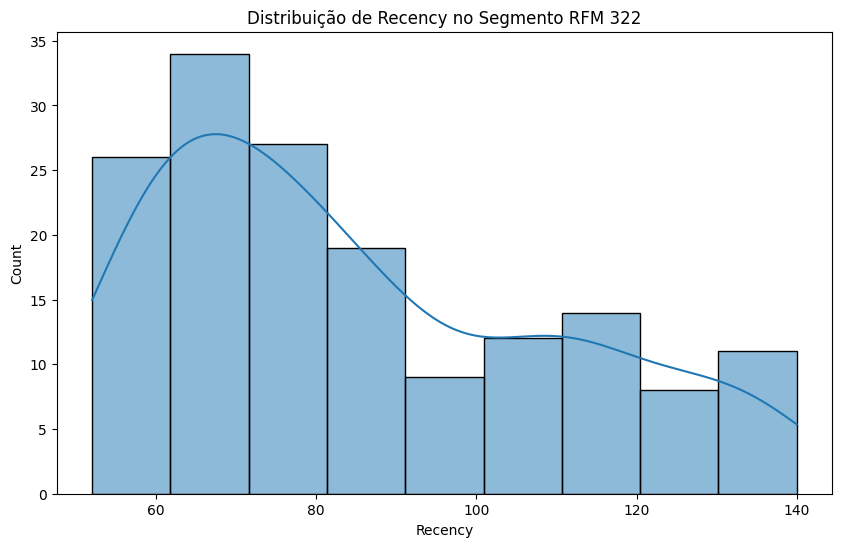

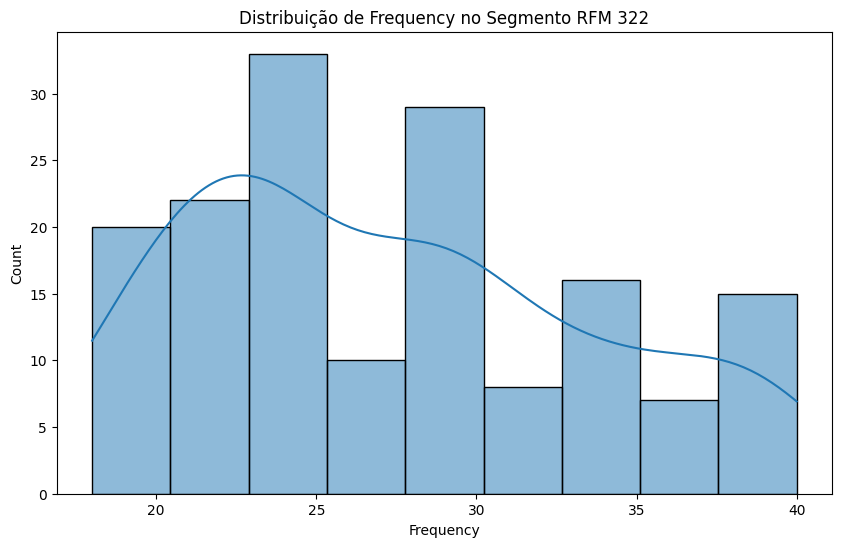

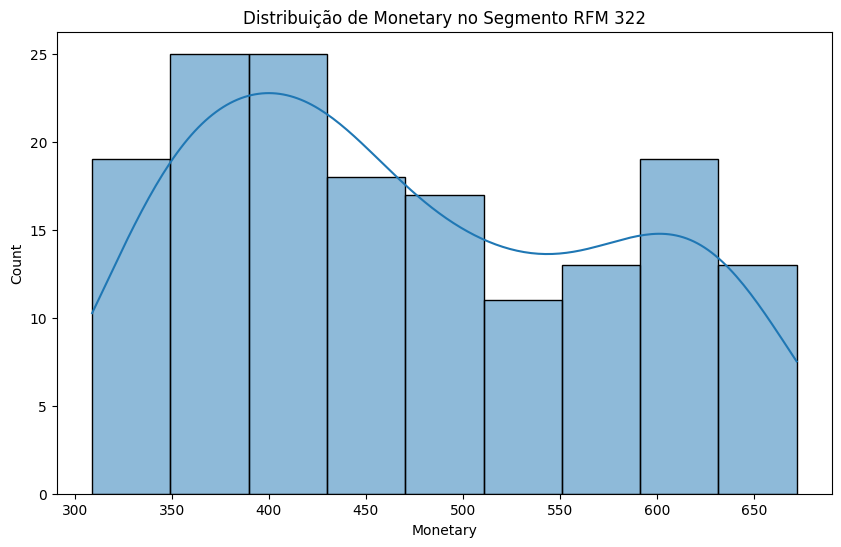



Segmento RFM 133
Número de Clientes: 150
Recência Média: 8.44
Frequência Média: 65.56666666666666
Monetário Médio: 1124.2533333333333


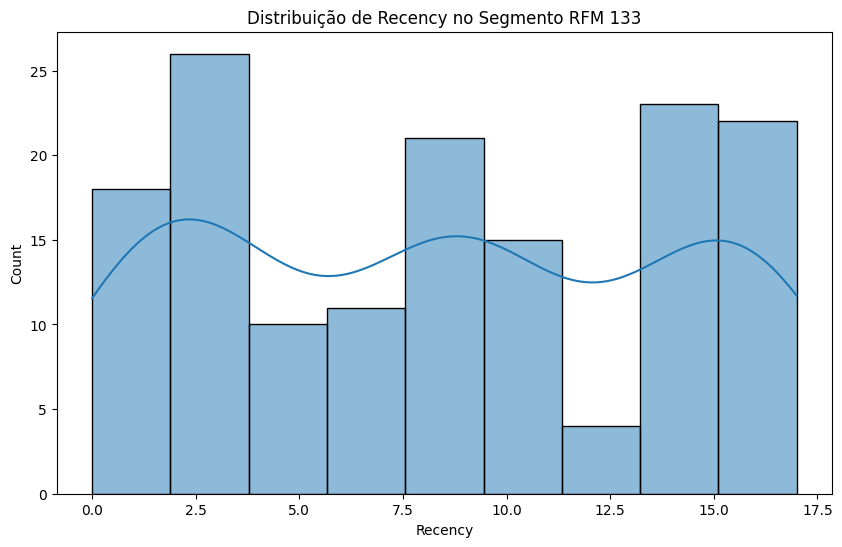

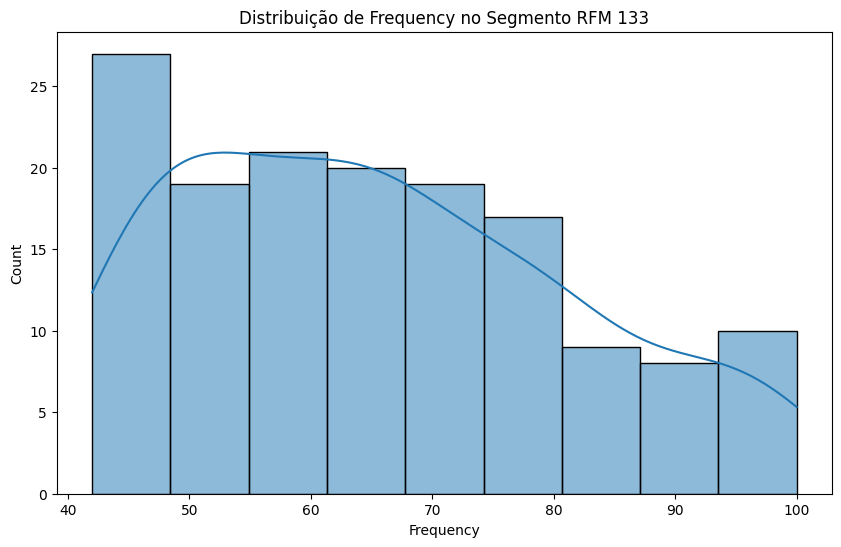

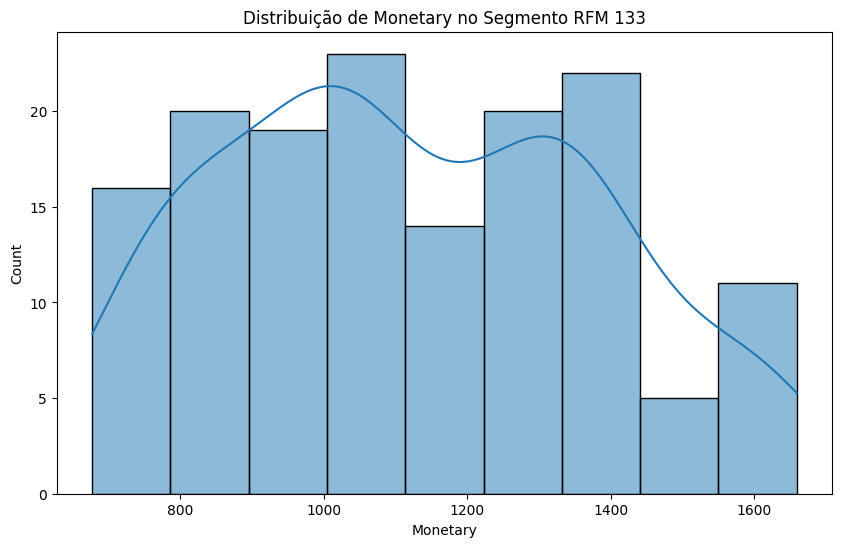



Segmento RFM 422
Número de Clientes: 206
Recência Média: 237.7233009708738
Frequência Média: 26.150485436893202
Monetário Médio: 454.8018932038835


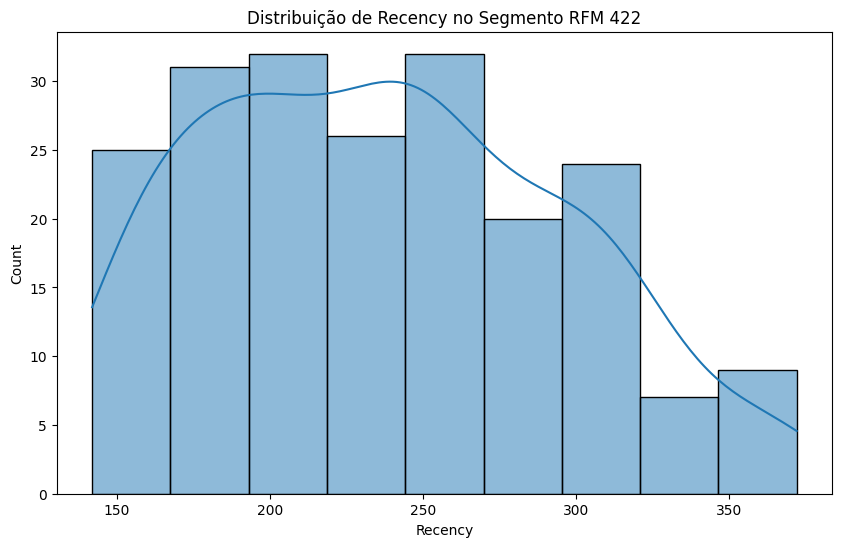

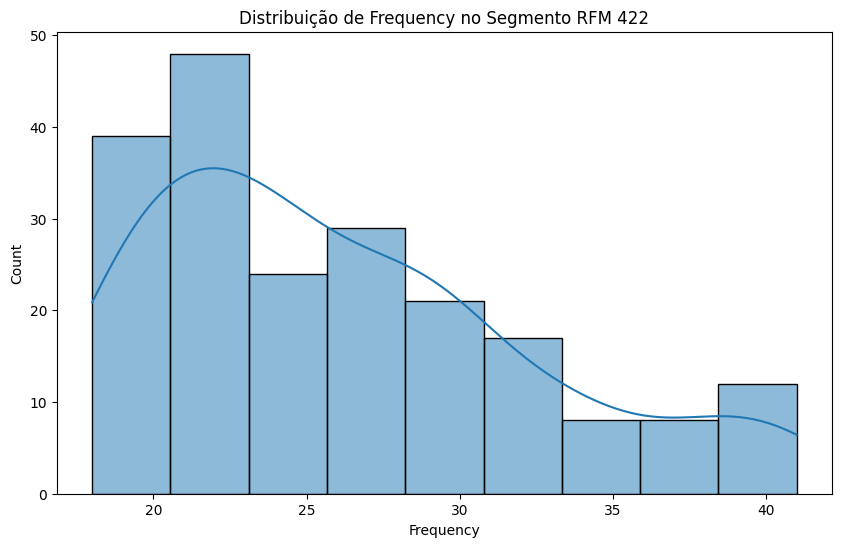

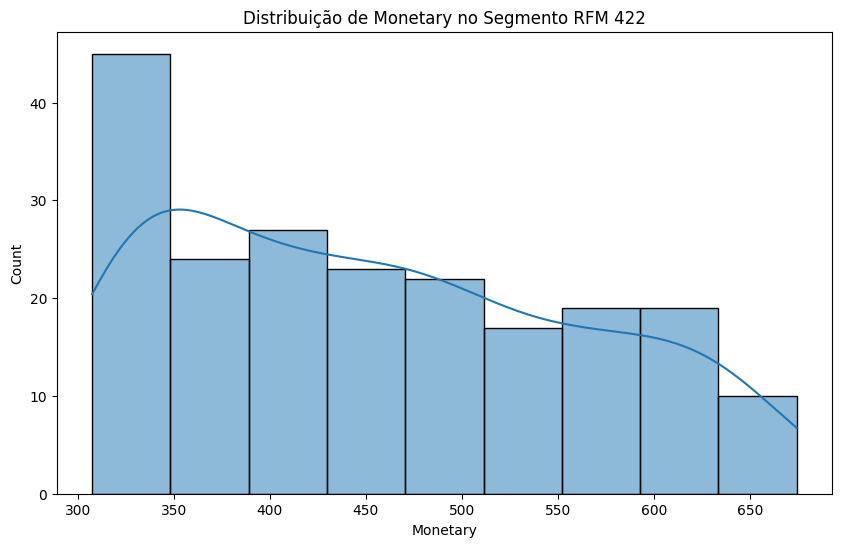



Segmento RFM 111
Número de Clientes: 68
Recência Média: 8.985294117647058
Frequência Média: 8.661764705882353
Monetário Médio: 170.87691176470588


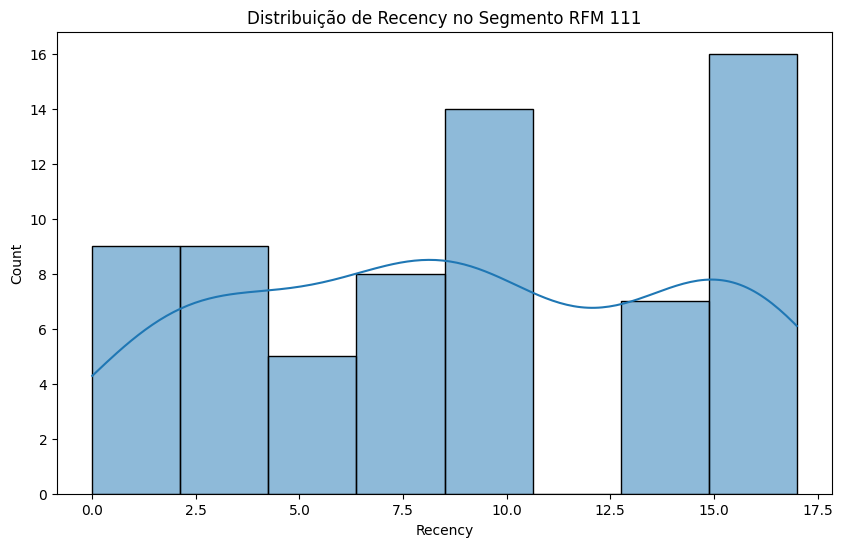

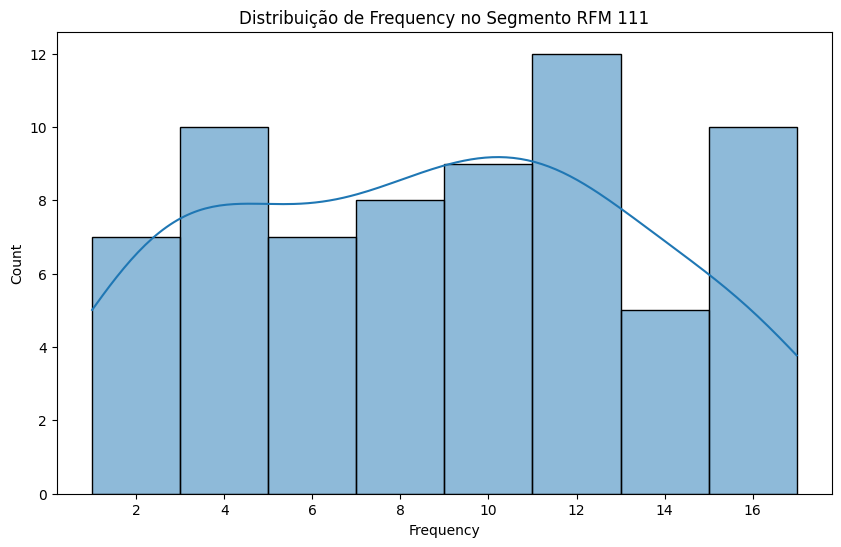

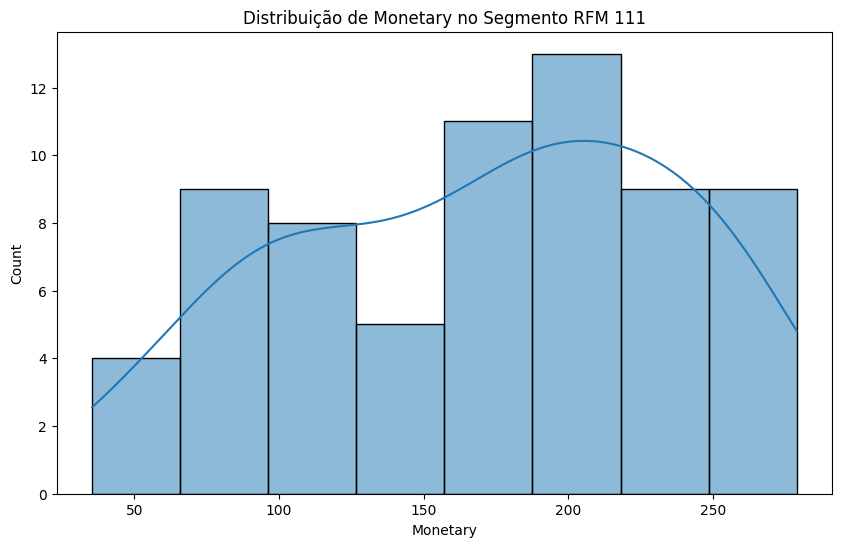

Sugestões: Clientes inativos, considerar estratégias de reativação.


Segmento RFM 333
Número de Clientes: 169
Recência Média: 84.49704142011835
Frequência Média: 61.32544378698225
Monetário Médio: 1074.9663313609467


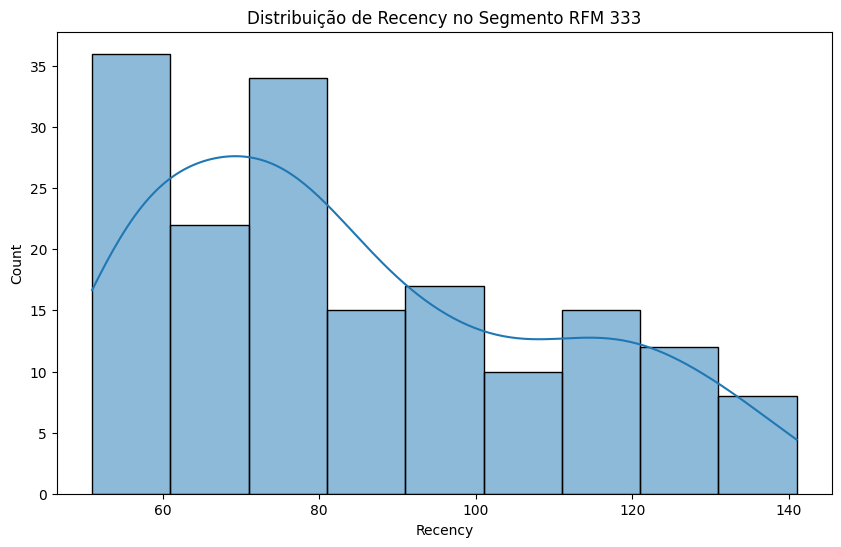

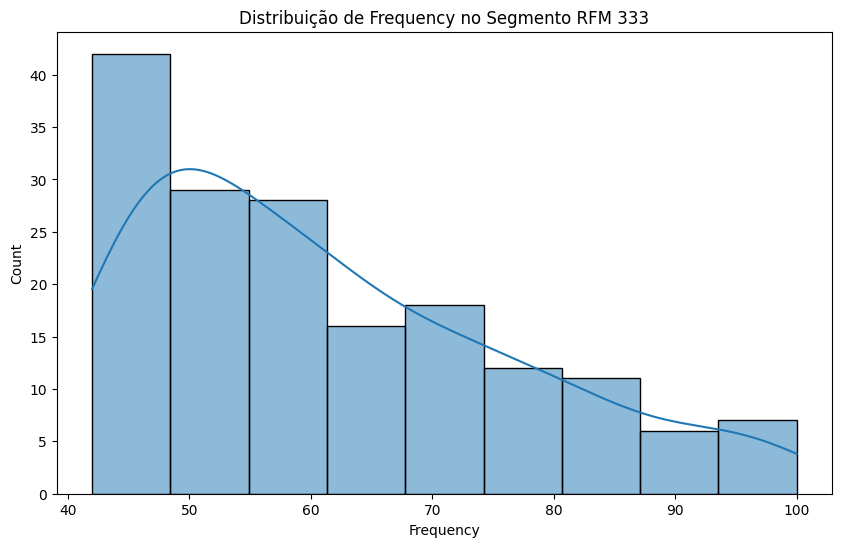

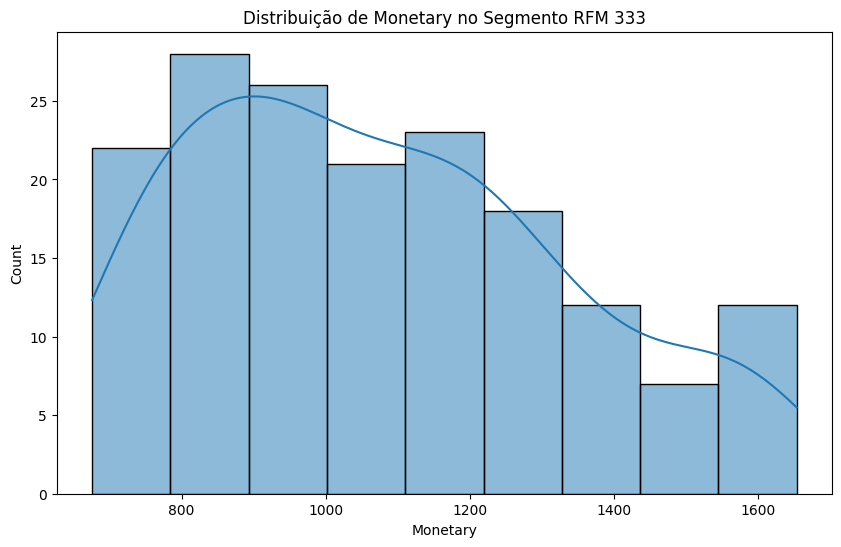



Segmento RFM 223
Número de Clientes: 45
Recência Média: 33.577777777777776
Frequência Média: 31.88888888888889
Monetário Médio: 935.2840000000001


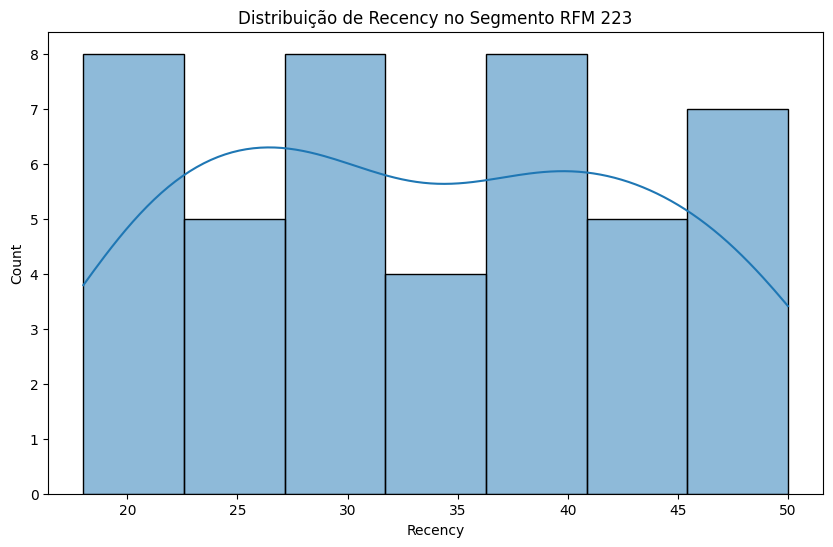

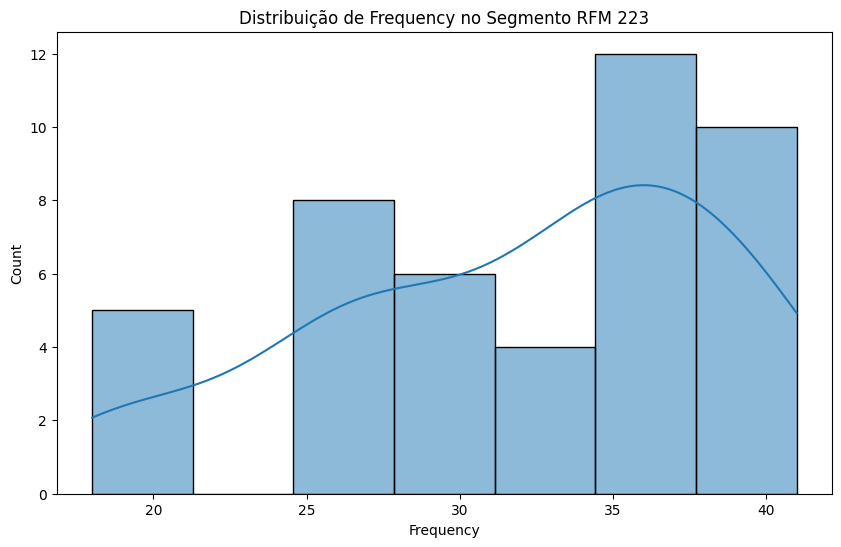

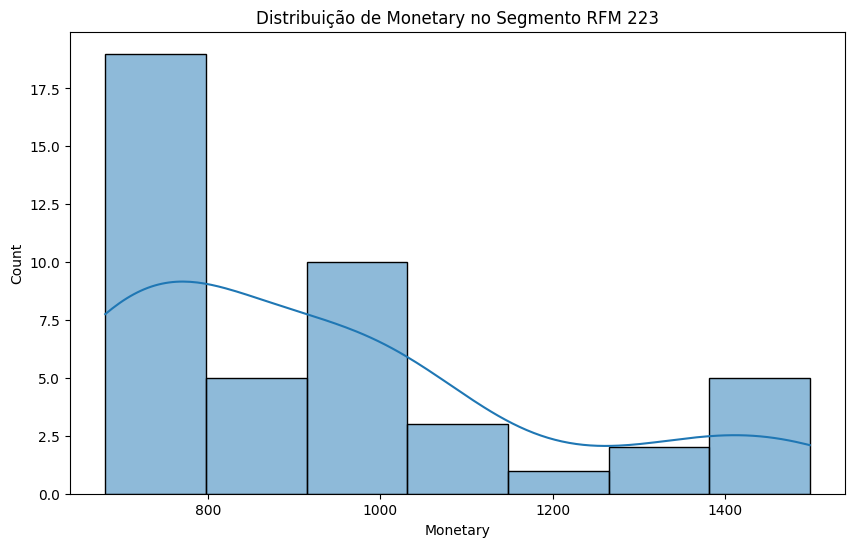



Segmento RFM 112
Número de Clientes: 23
Recência Média: 9.26086956521739
Frequência Média: 10.608695652173912
Monetário Médio: 402.40521739130435


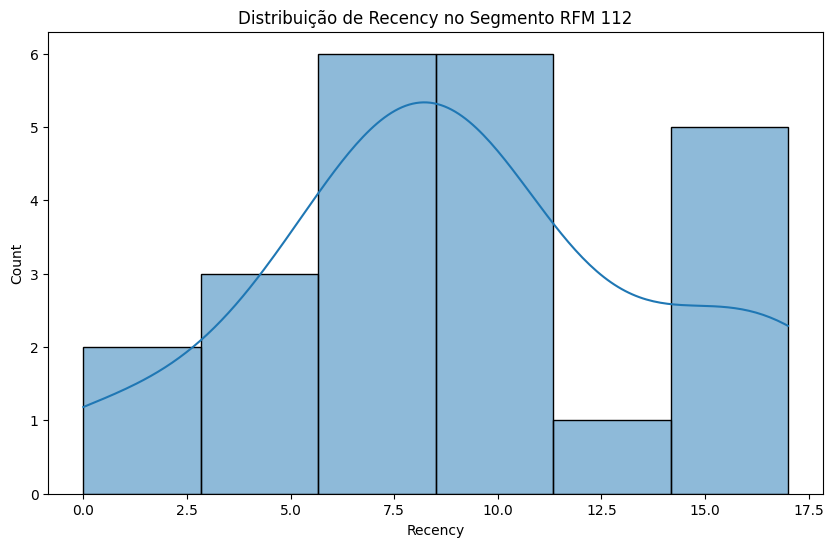

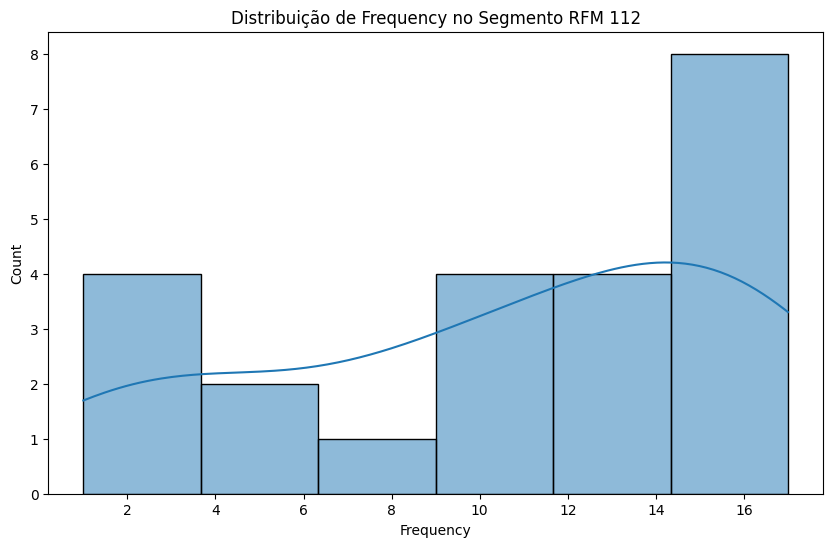

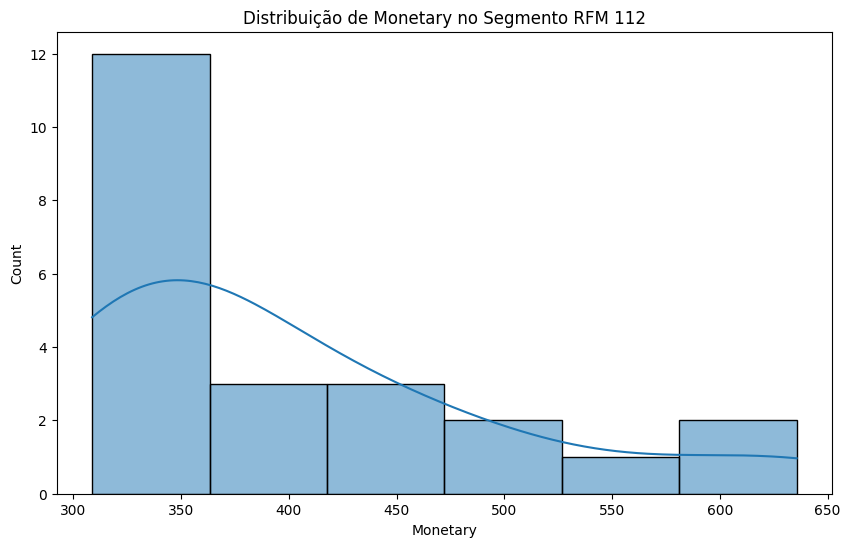



Segmento RFM 323
Número de Clientes: 91
Recência Média: 82.27472527472527
Frequência Média: 31.34065934065934
Monetário Médio: 981.1054945054944


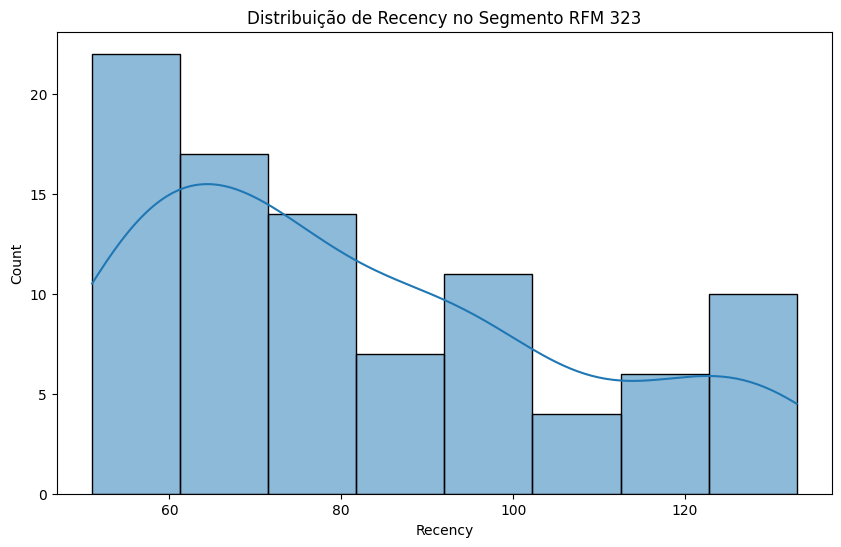

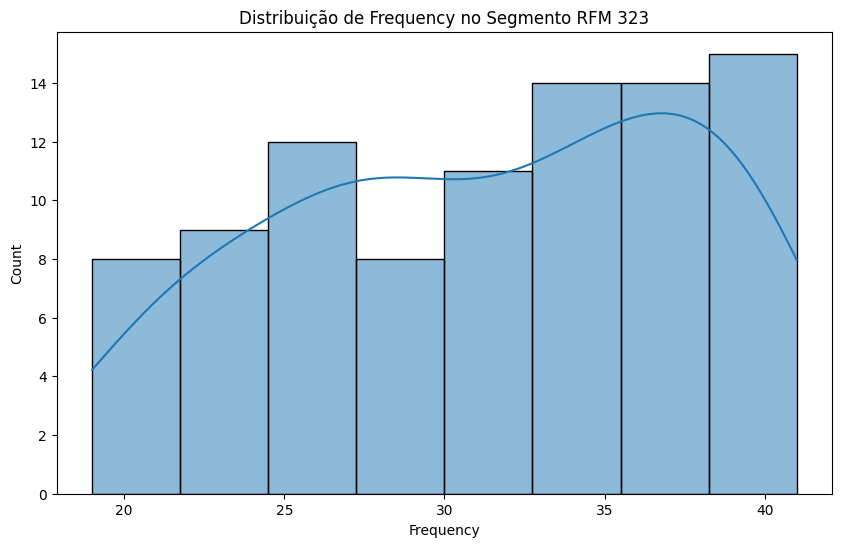

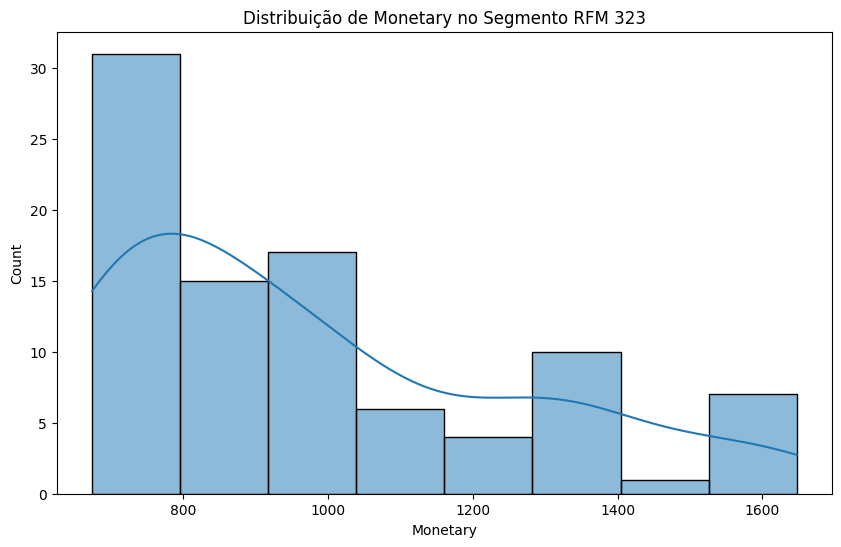



Segmento RFM 134
Número de Clientes: 87
Recência Média: 7.436781609195402
Frequência Média: 78.1264367816092
Monetário Médio: 4382.555057471264


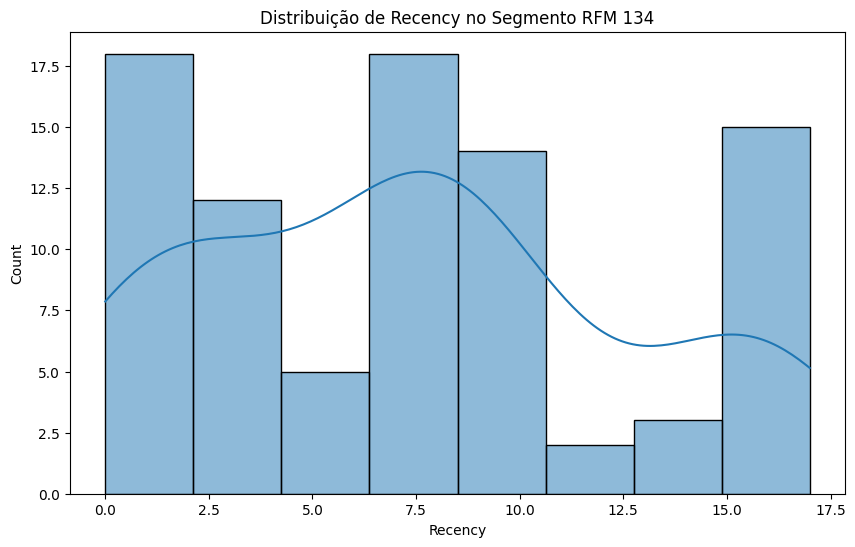

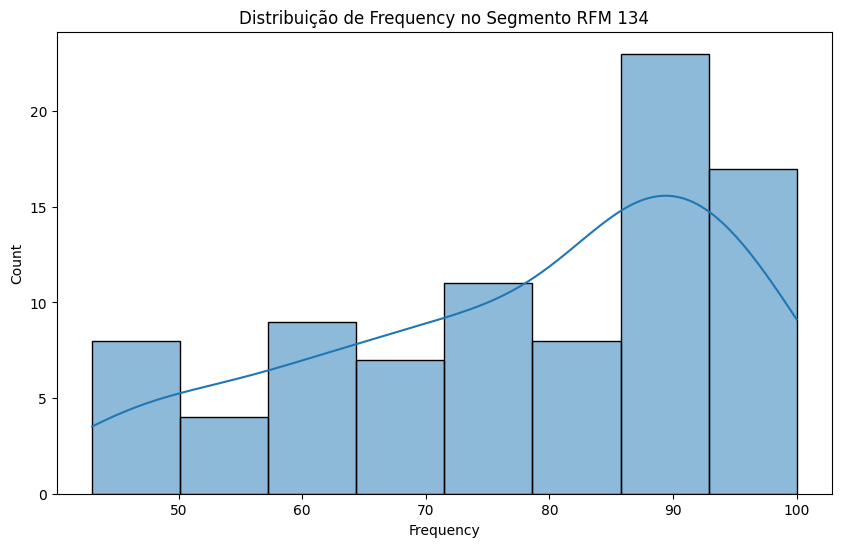

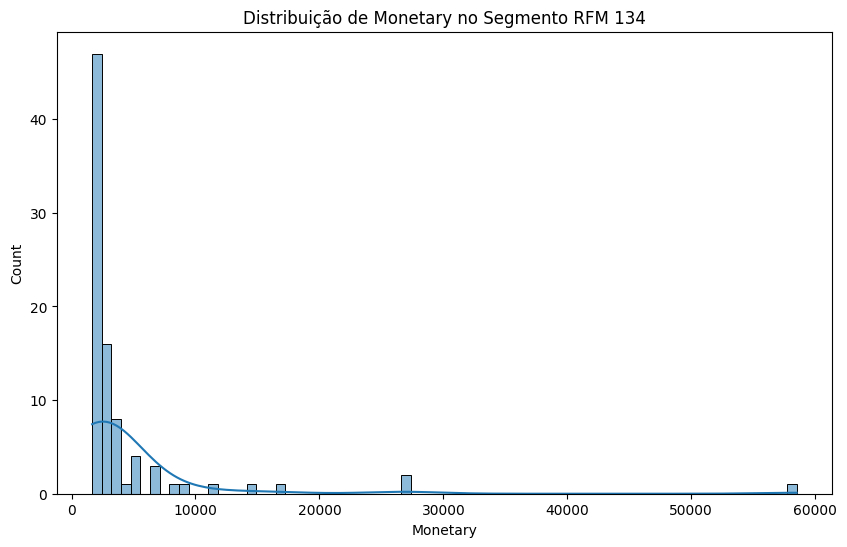



Segmento RFM 434
Número de Clientes: 14
Recência Média: 205.28571428571428
Frequência Média: 69.28571428571429
Monetário Médio: 3205.7228571428573


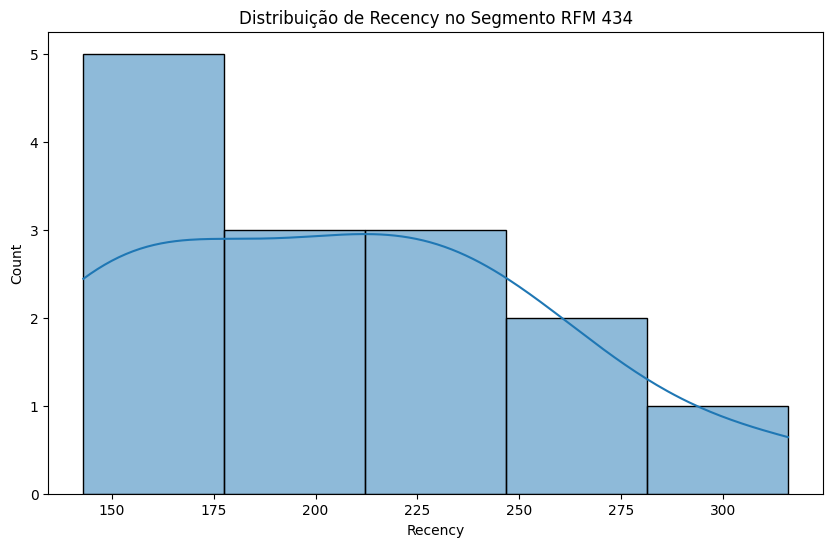

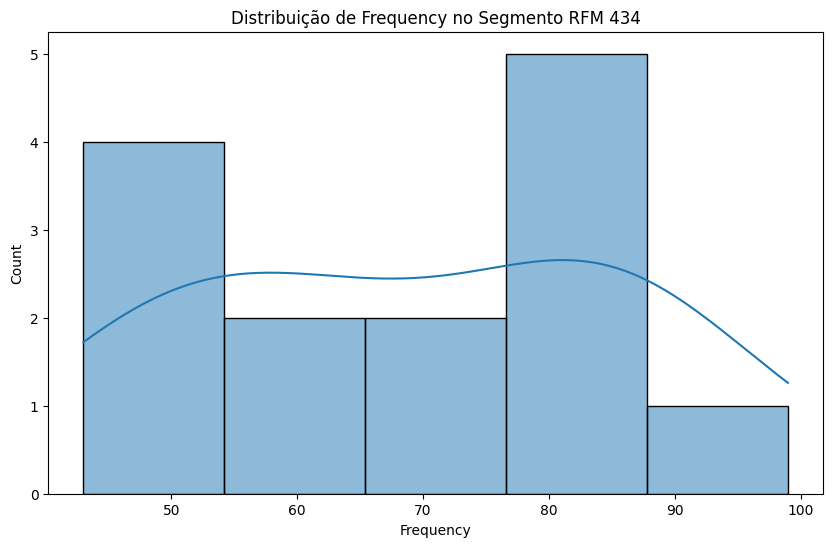

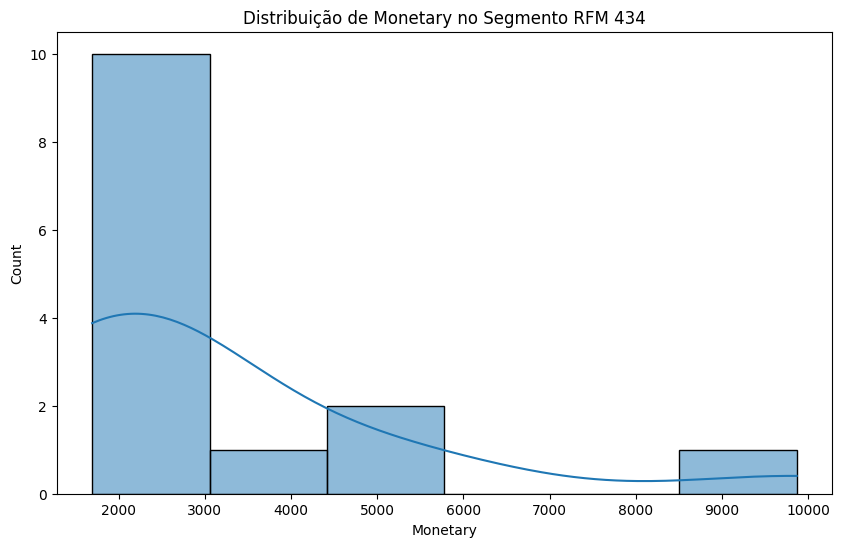



Segmento RFM 222
Número de Clientes: 130
Recência Média: 33.223076923076924
Frequência Média: 27.423076923076923
Monetário Médio: 488.74892307692306


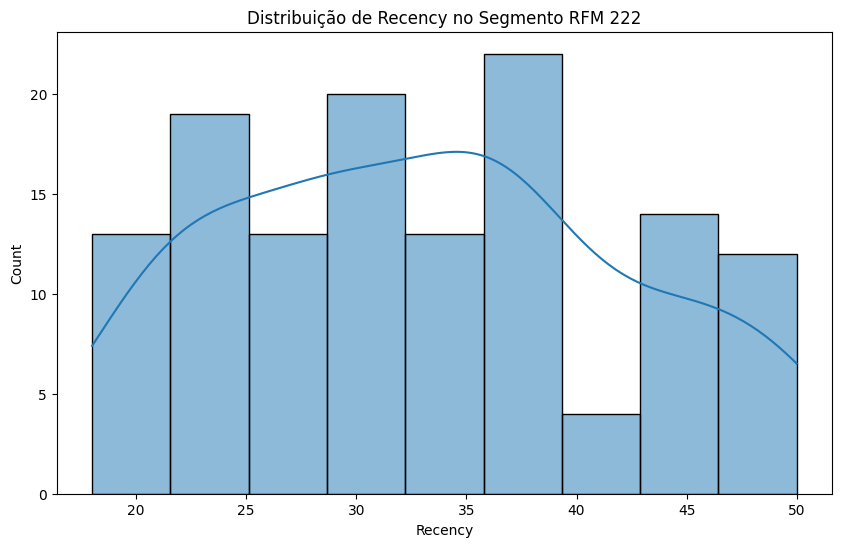

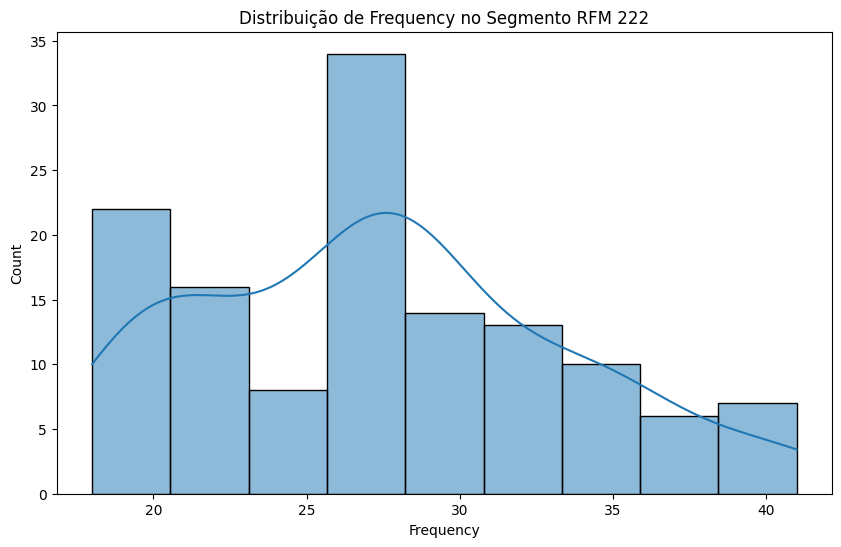

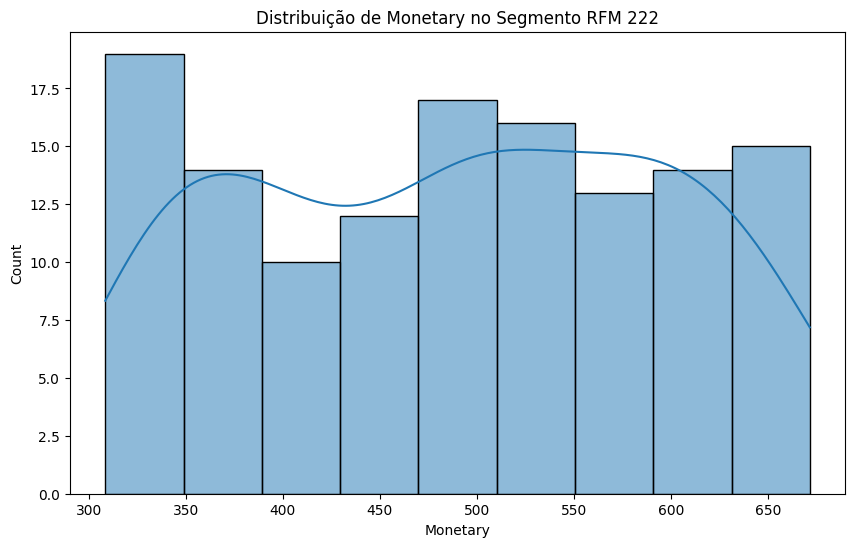



Segmento RFM 232
Número de Clientes: 69
Recência Média: 30.47826086956522
Frequência Média: 64.76811594202898
Monetário Médio: 470.62695652173915


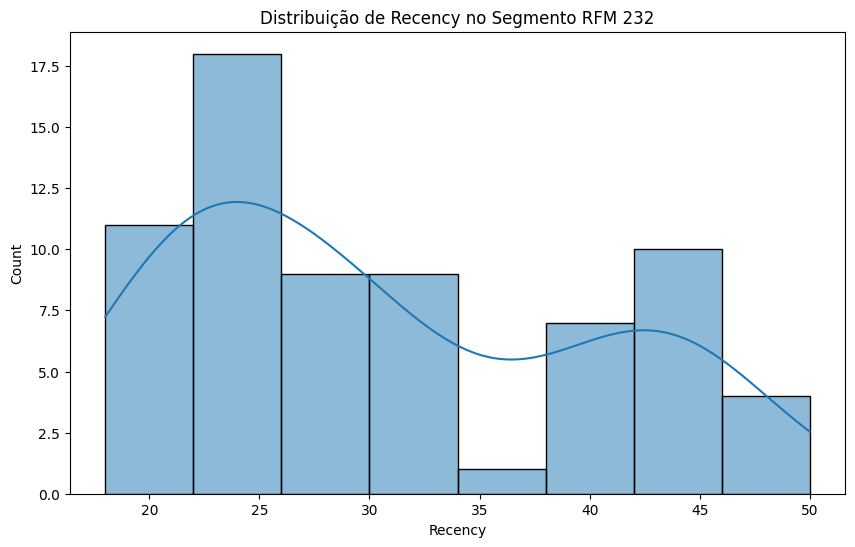

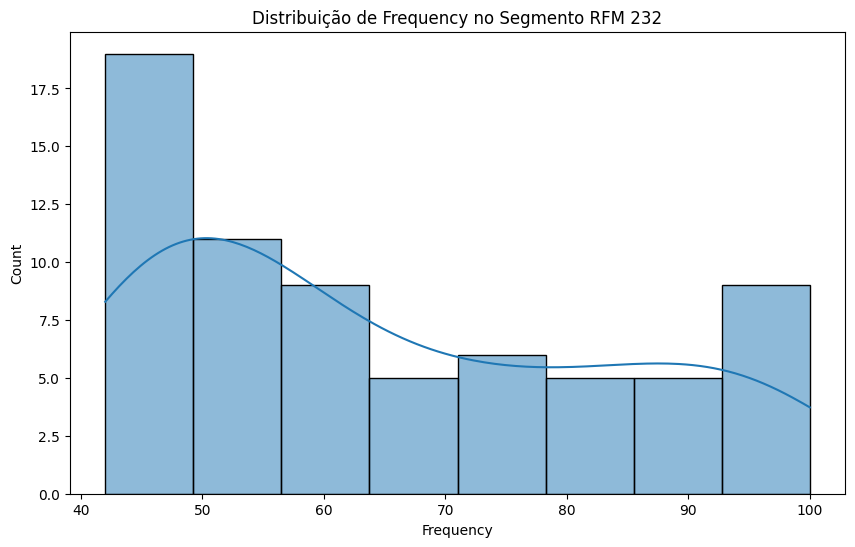

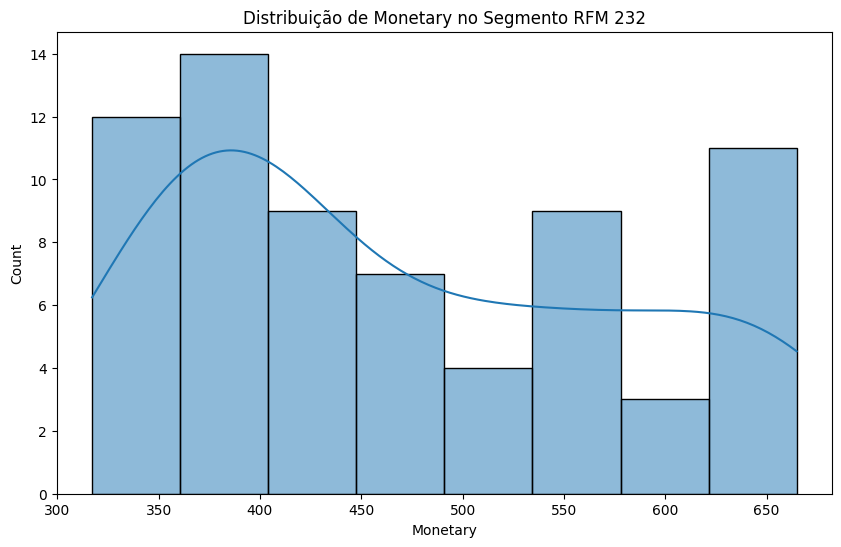



Segmento RFM 233
Número de Clientes: 166
Recência Média: 29.93975903614458
Frequência Média: 65.07228915662651
Monetário Médio: 1086.2369939759037


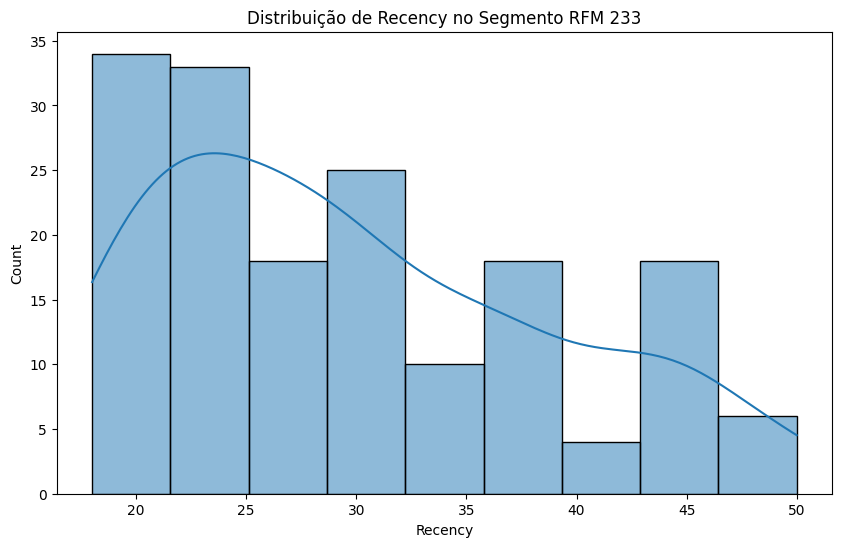

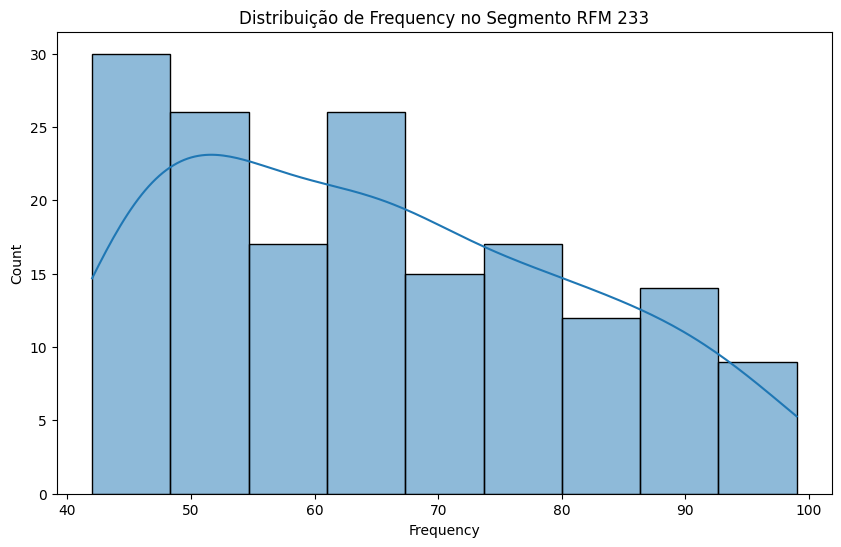

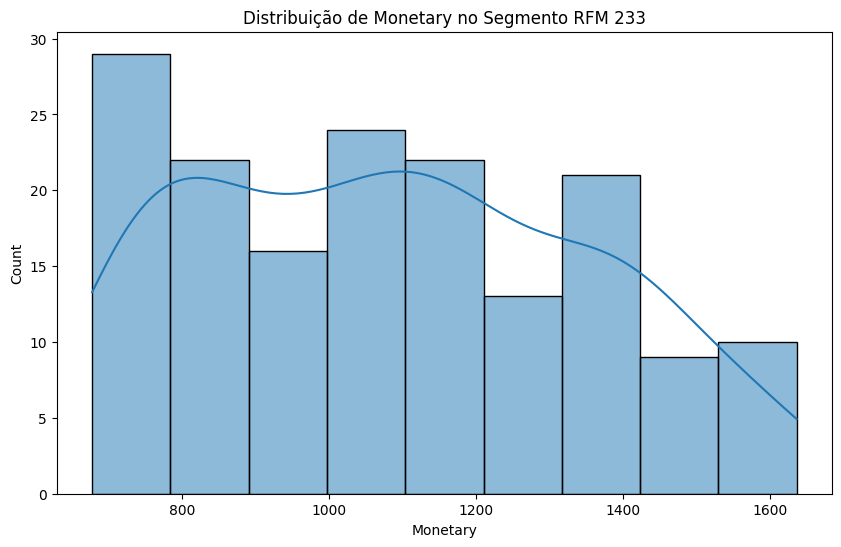



Segmento RFM 212
Número de Clientes: 35
Recência Média: 36.91428571428571
Frequência Média: 10.485714285714286
Monetário Médio: 428.81000000000006


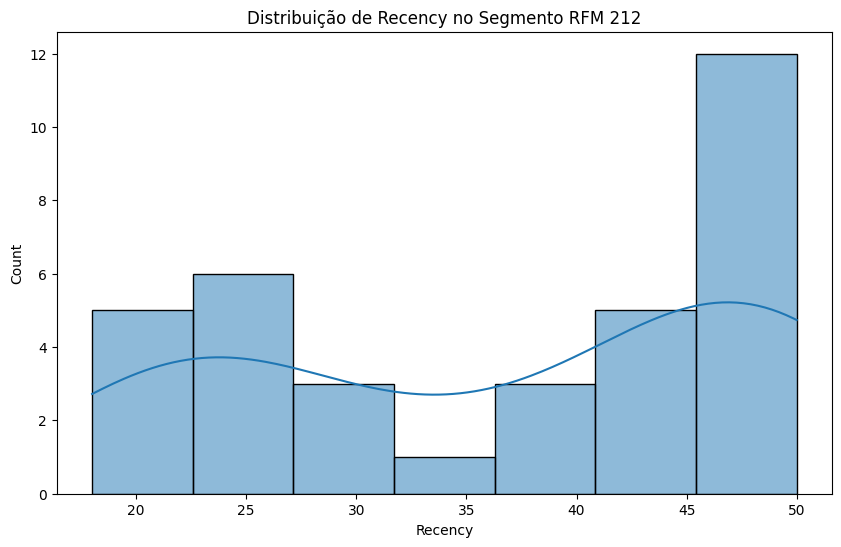

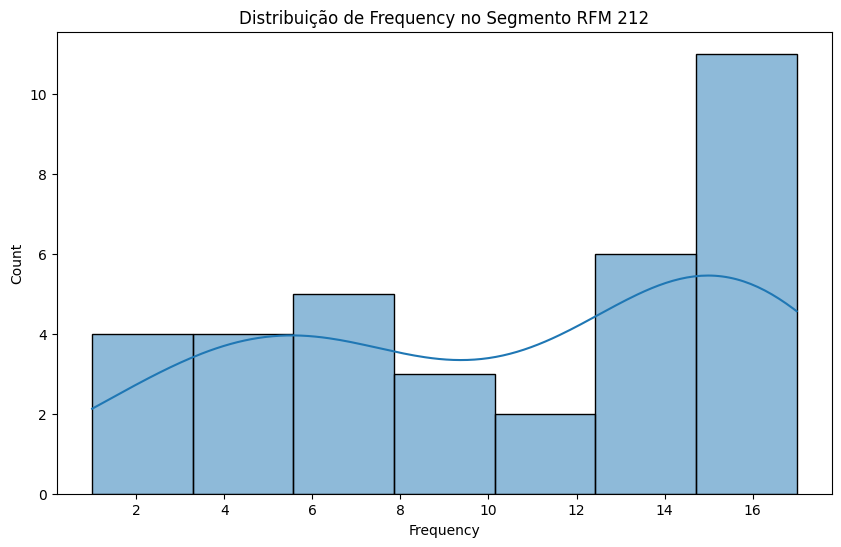

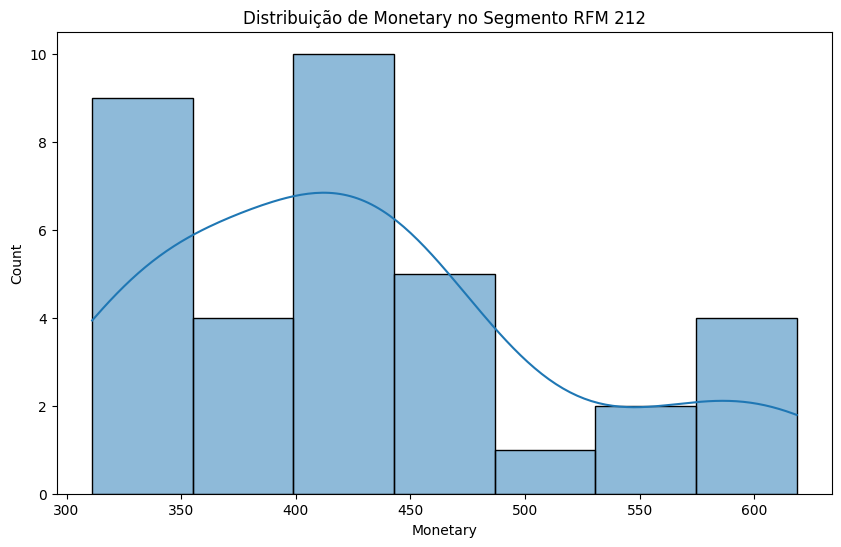



Segmento RFM 423
Número de Clientes: 36
Recência Média: 236.80555555555554
Frequência Média: 31.72222222222222
Monetário Médio: 936.9013888888888


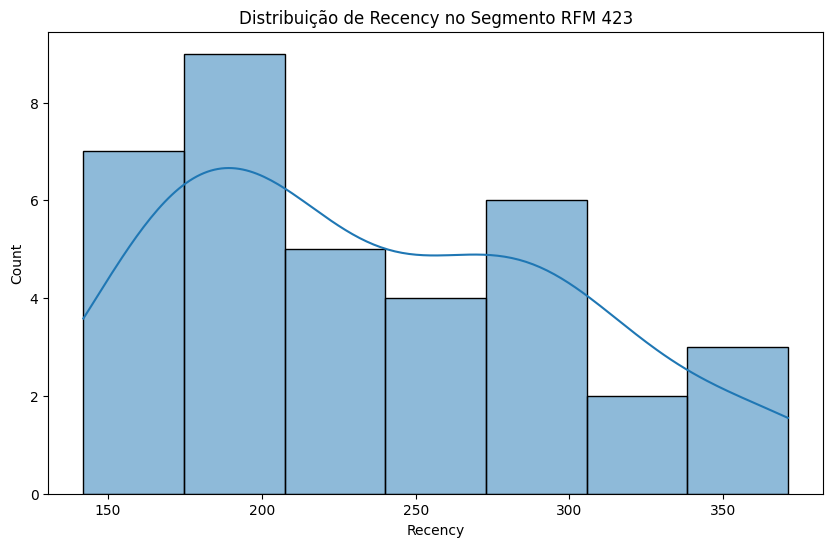

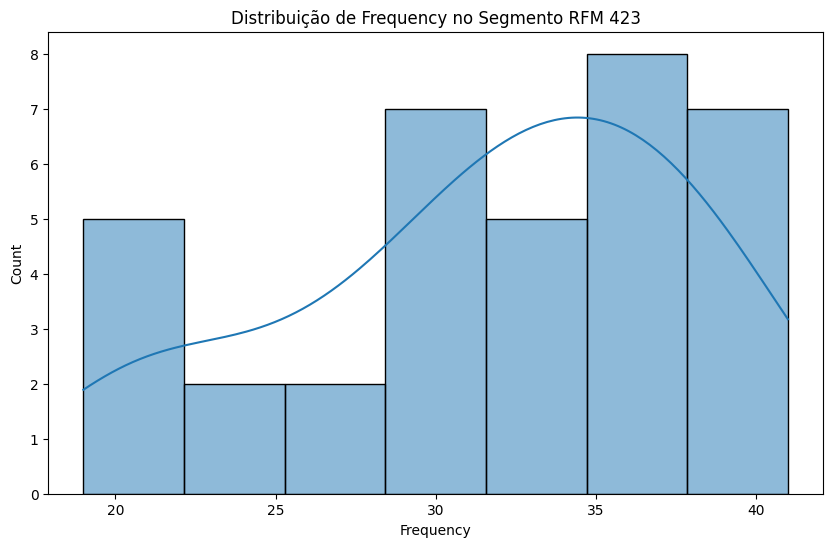

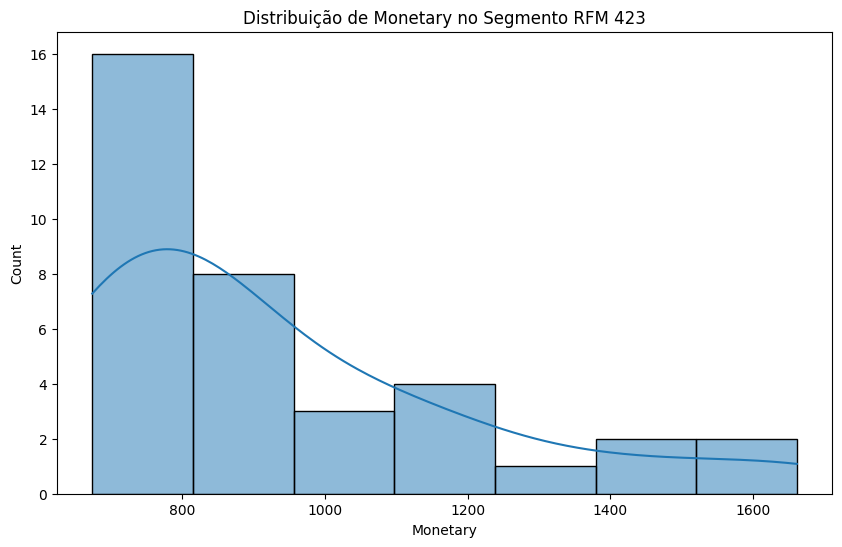



Segmento RFM 424
Número de Clientes: 5
Recência Média: 212.0
Frequência Média: 29.6
Monetário Médio: 3092.8119999999994


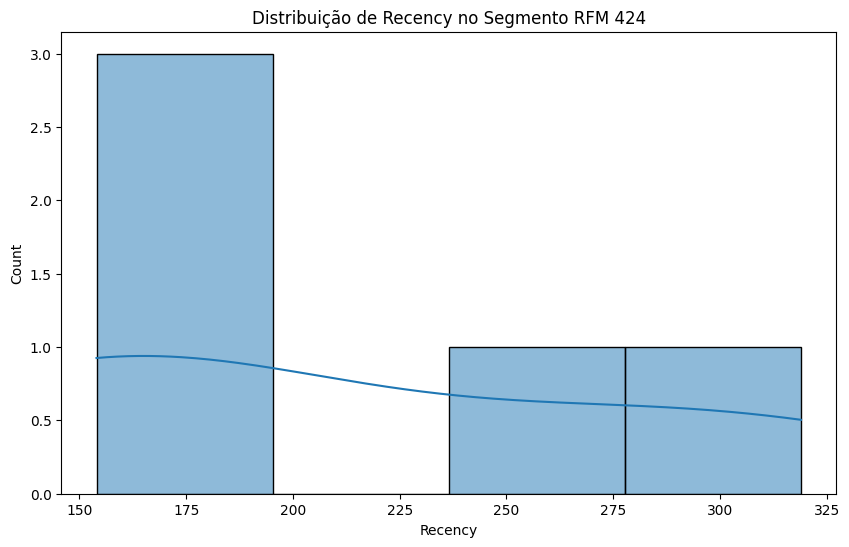

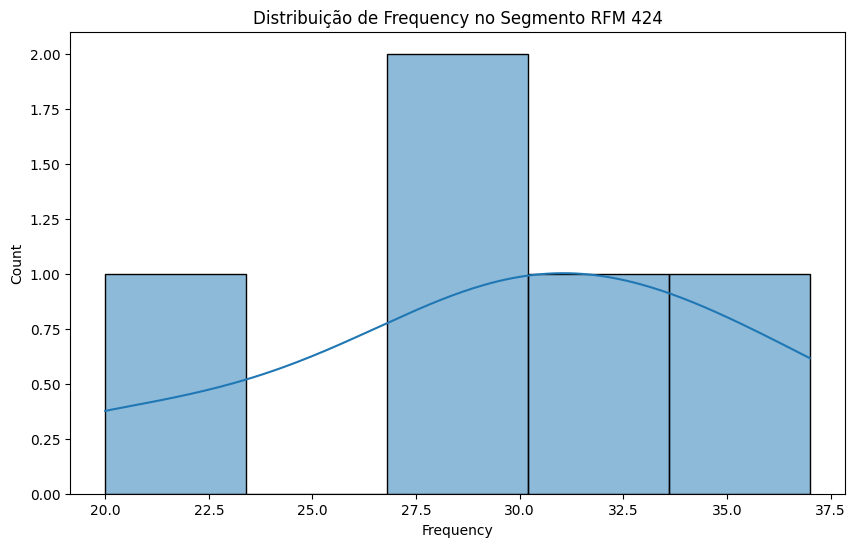

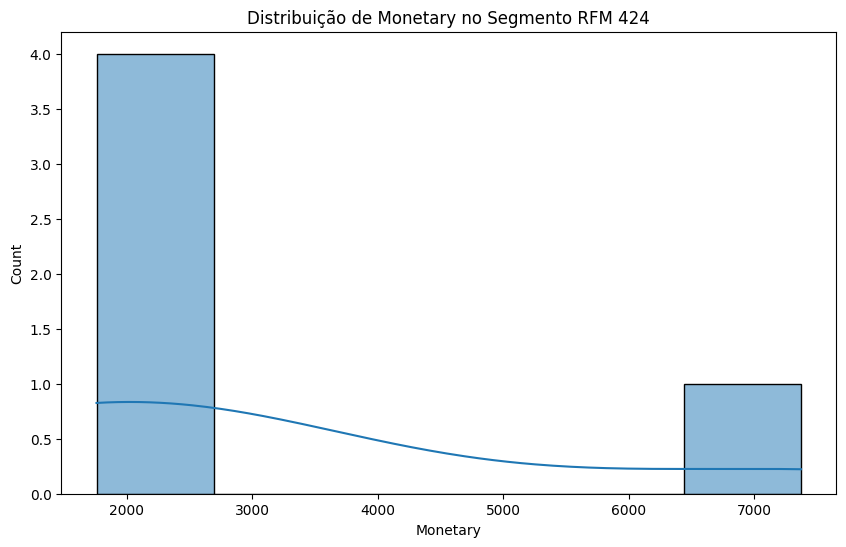



Segmento RFM 211
Número de Clientes: 122
Recência Média: 31.729508196721312
Frequência Média: 9.254098360655737
Monetário Médio: 172.26852459016396


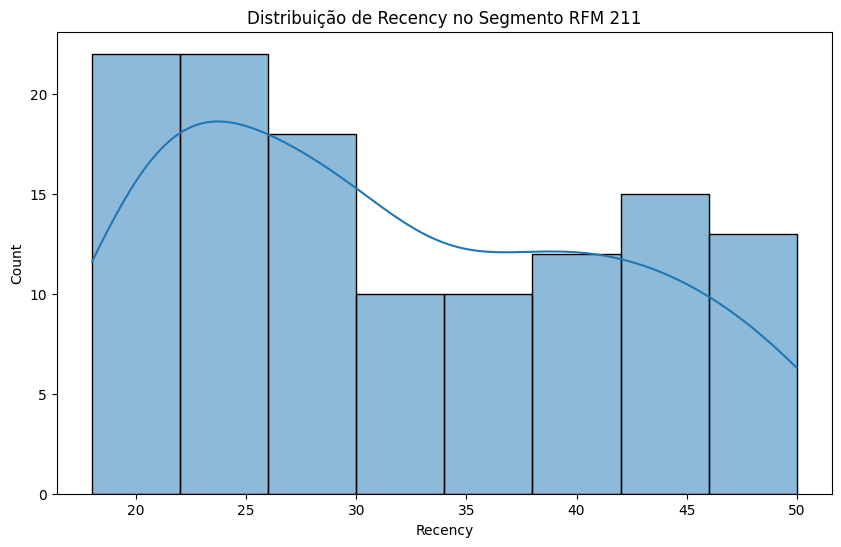

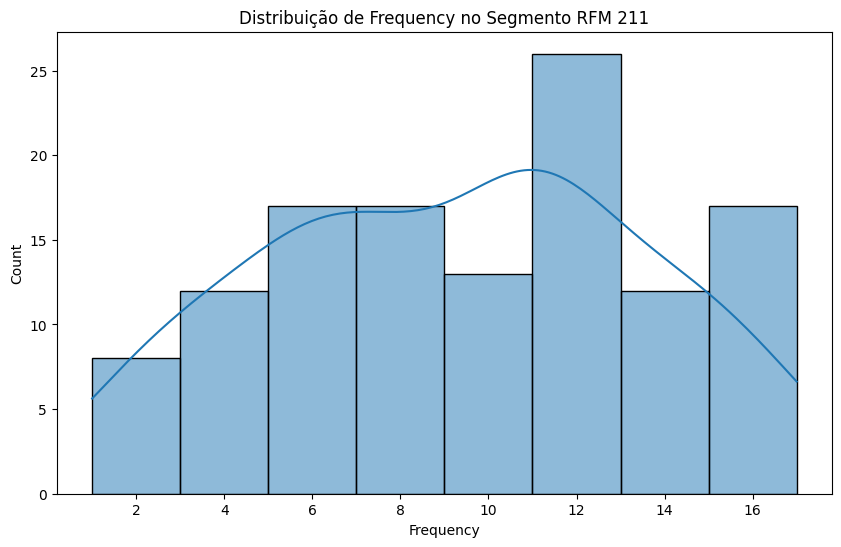

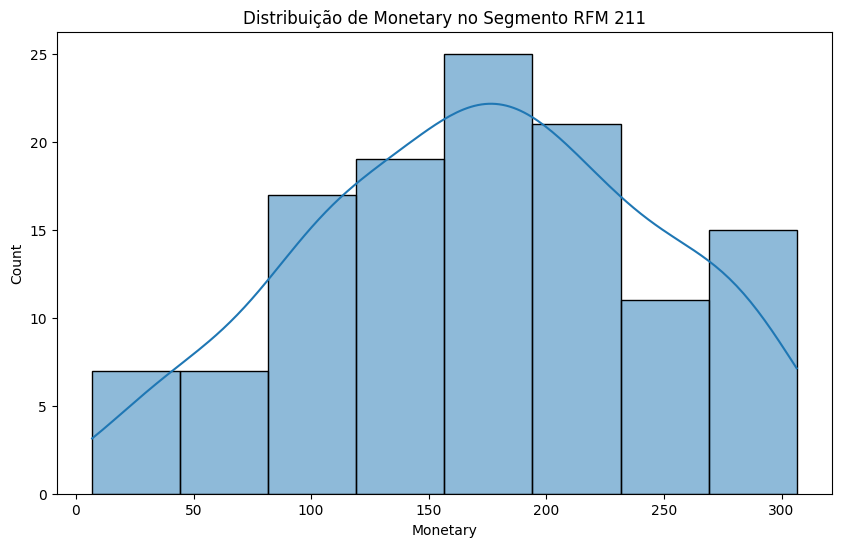



Segmento RFM 312
Número de Clientes: 75
Recência Média: 85.36
Frequência Média: 10.6
Monetário Médio: 438.10054666666673


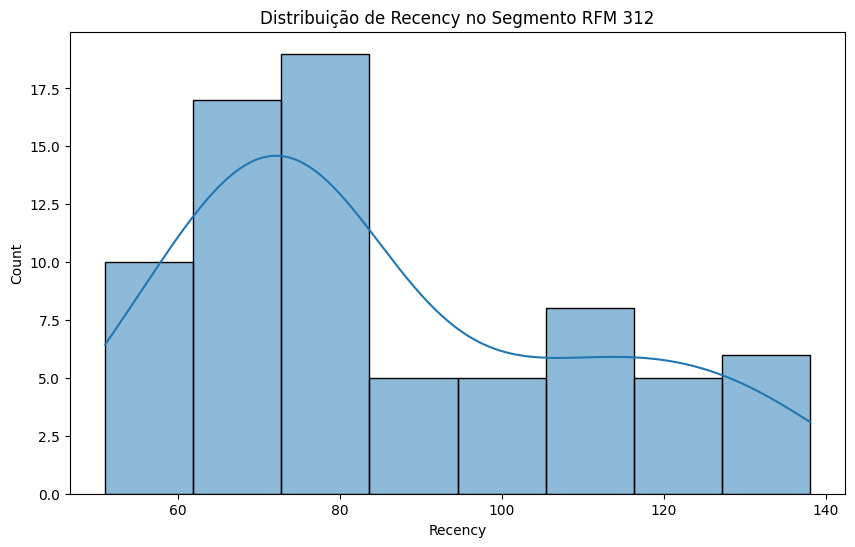

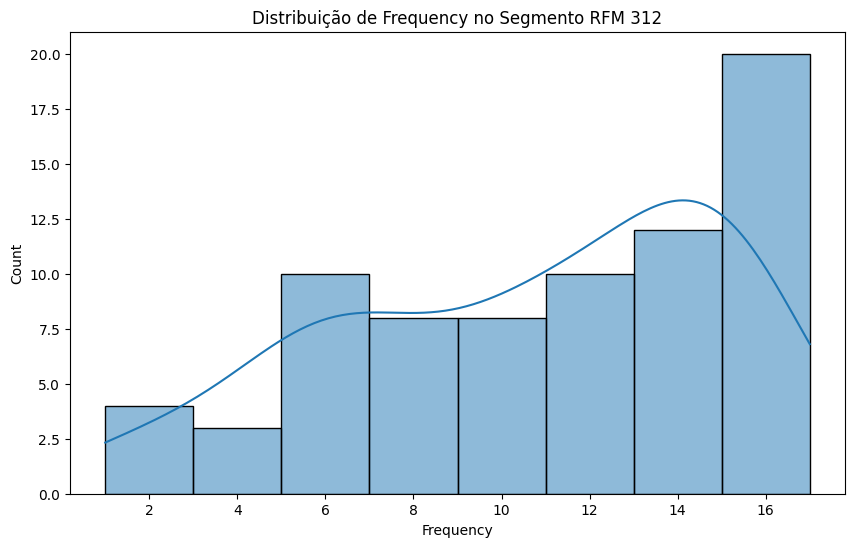

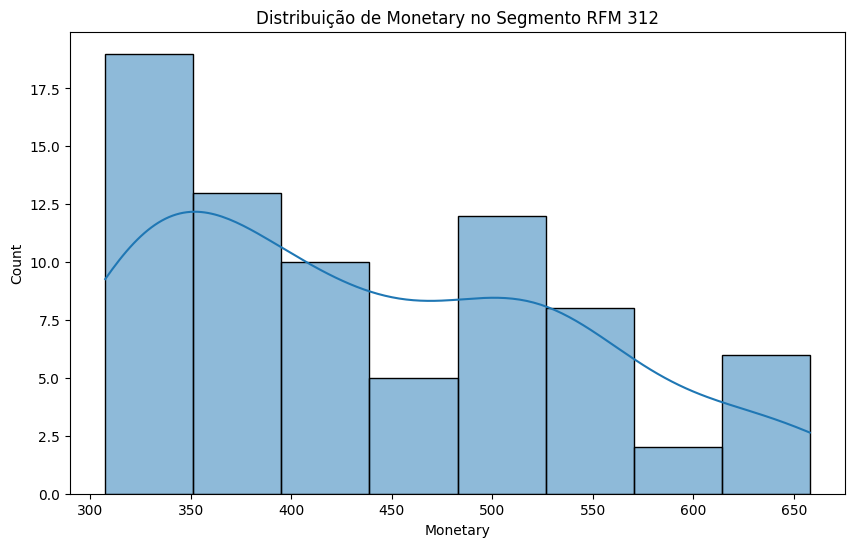



Segmento RFM 122
Número de Clientes: 75
Recência Média: 8.773333333333333
Frequência Média: 27.786666666666665
Monetário Médio: 479.4417333333335


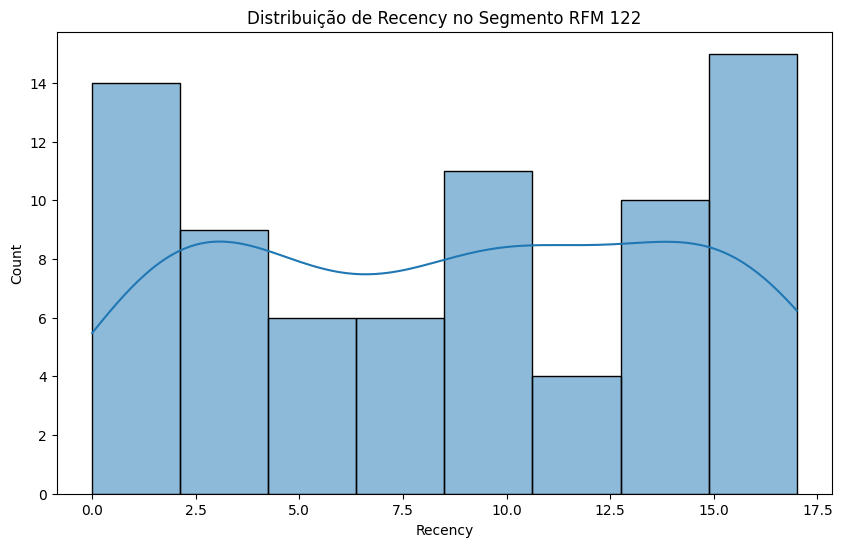

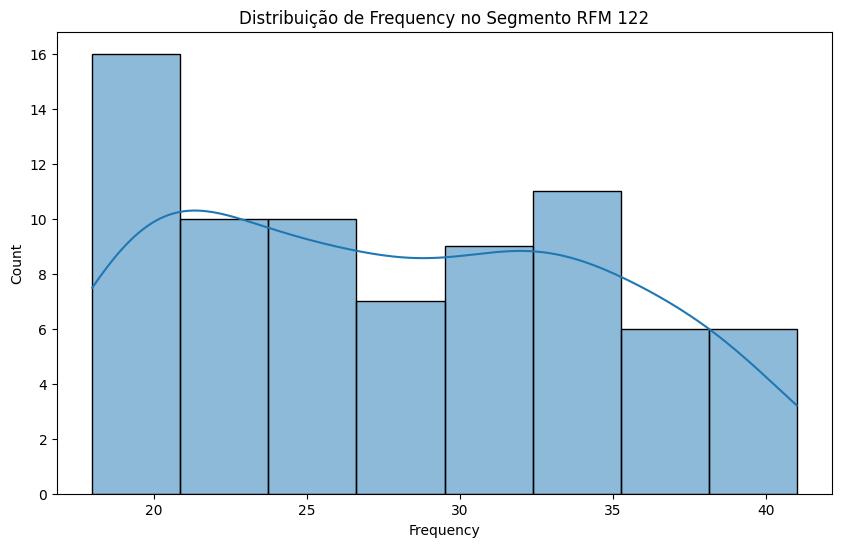

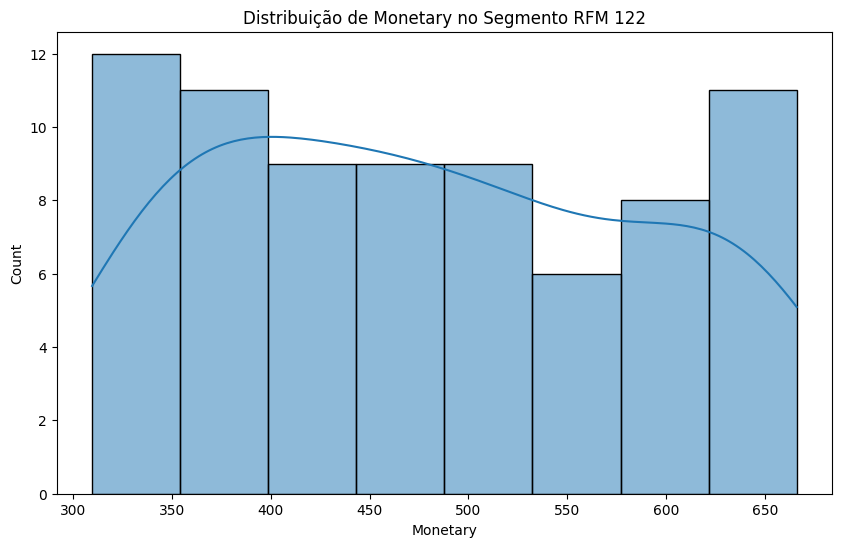



Segmento RFM 314
Número de Clientes: 14
Recência Média: 87.0
Frequência Média: 9.857142857142858
Monetário Médio: 2725.1535714285715


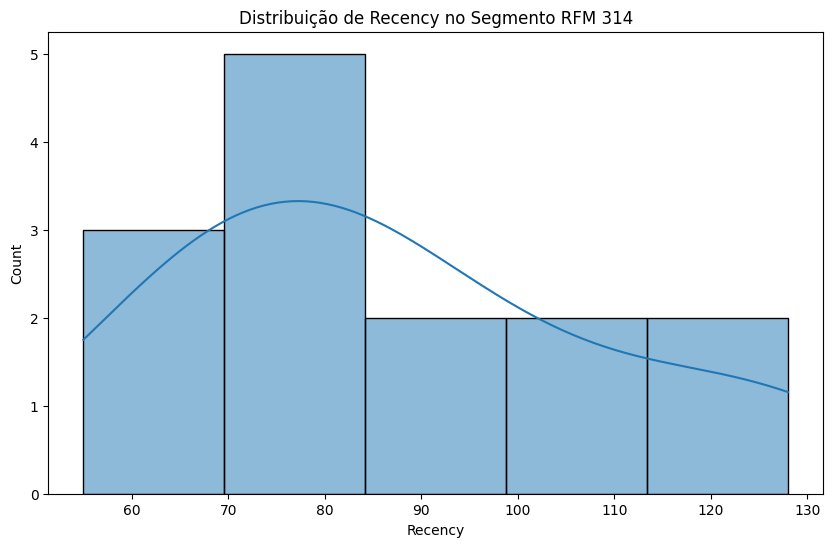

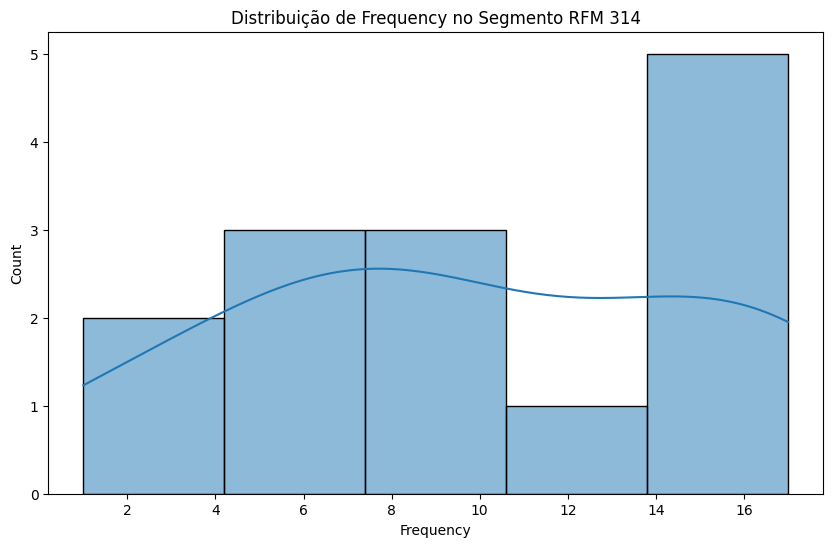

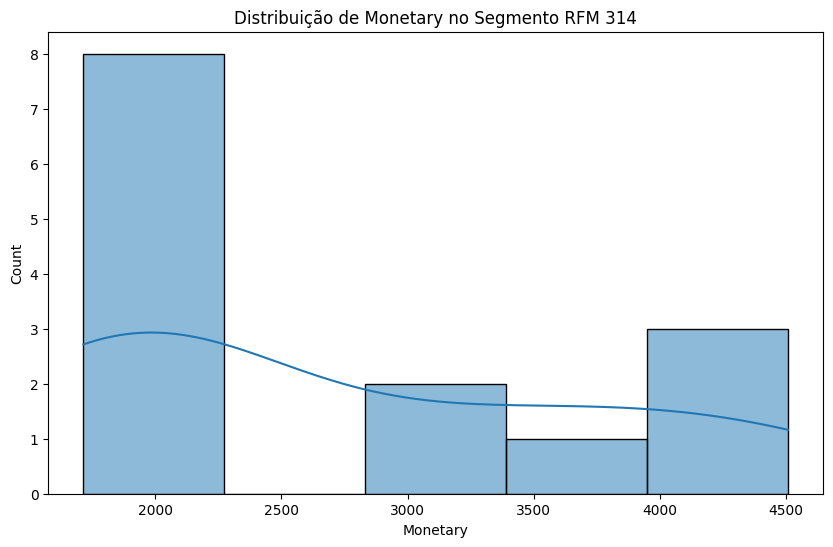



Segmento RFM 334
Número de Clientes: 52
Recência Média: 83.0
Frequência Média: 74.78846153846153
Monetário Médio: 2771.7719230769226


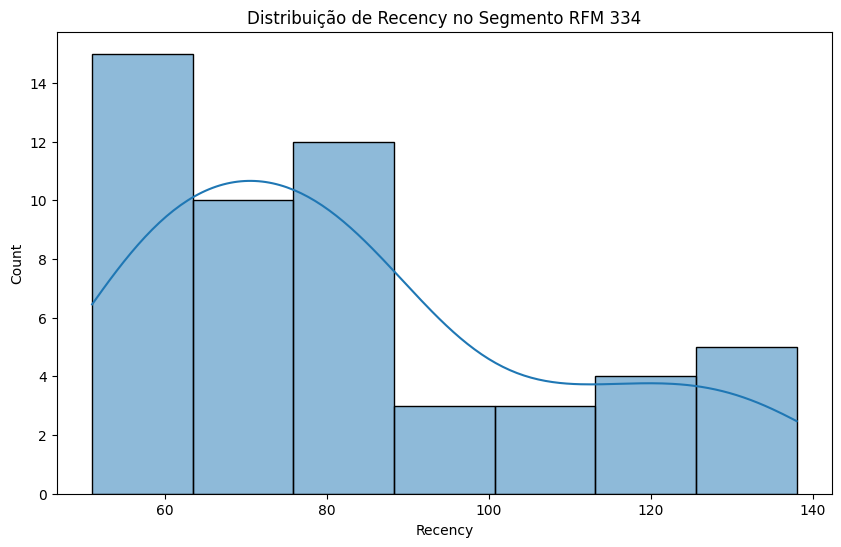

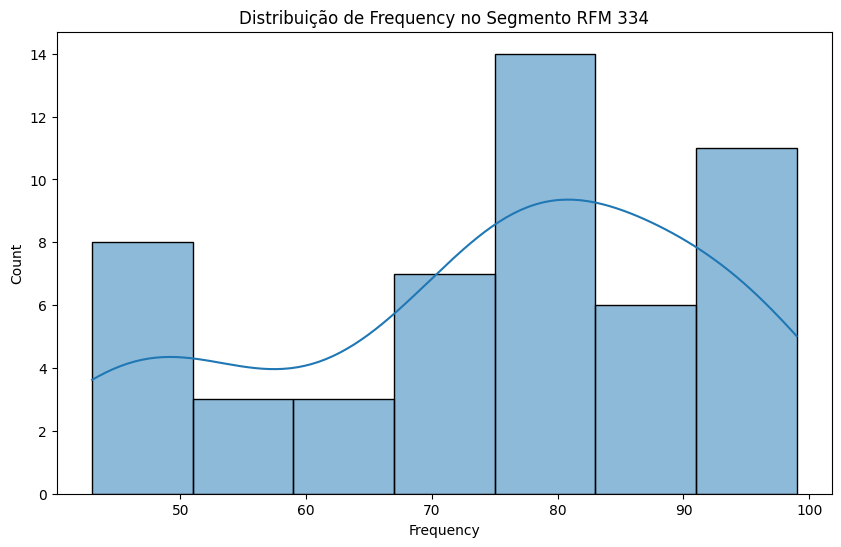

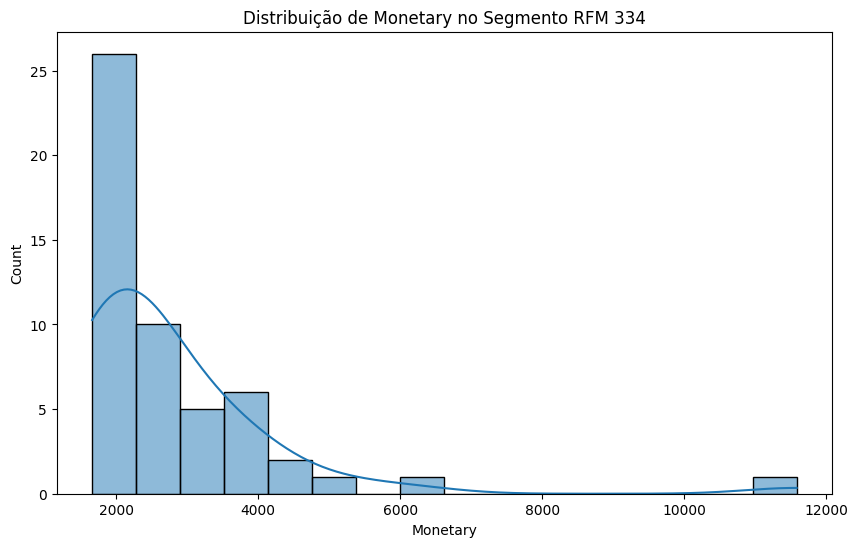



Segmento RFM 321
Número de Clientes: 53
Recência Média: 89.11320754716981
Frequência Média: 26.566037735849058
Monetário Médio: 206.75226415094338


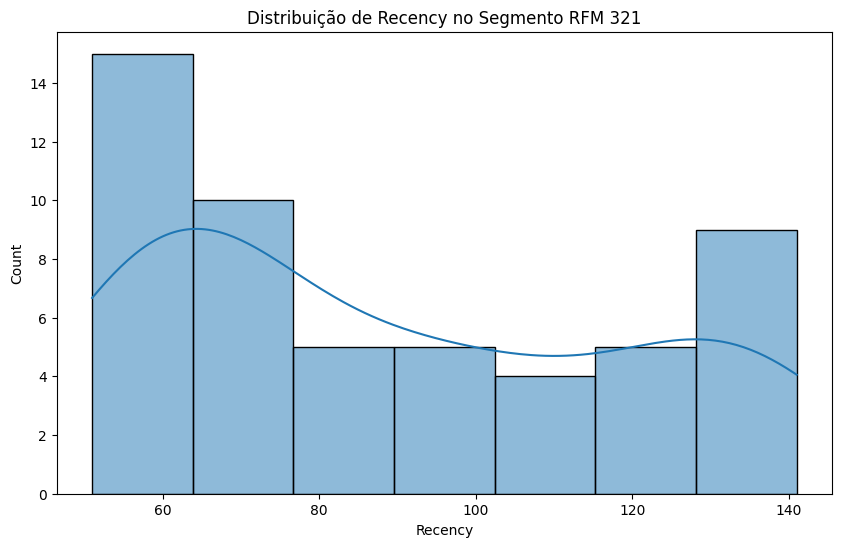

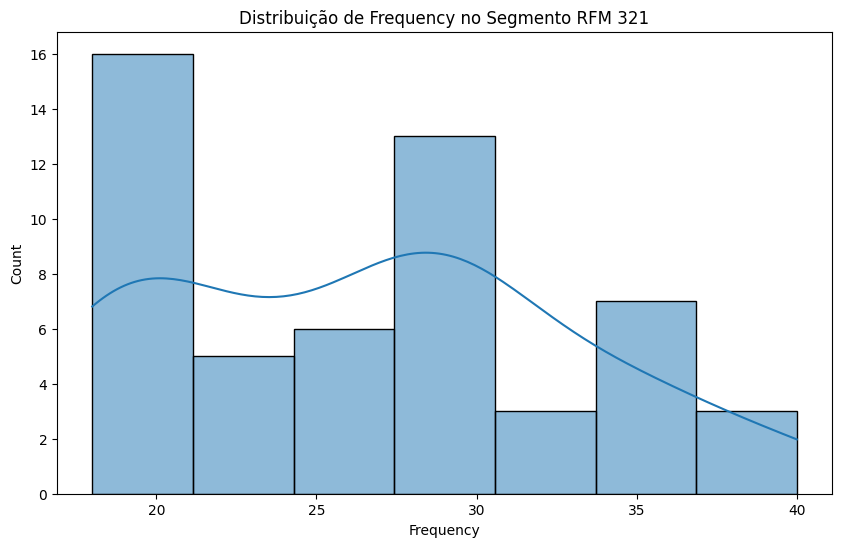

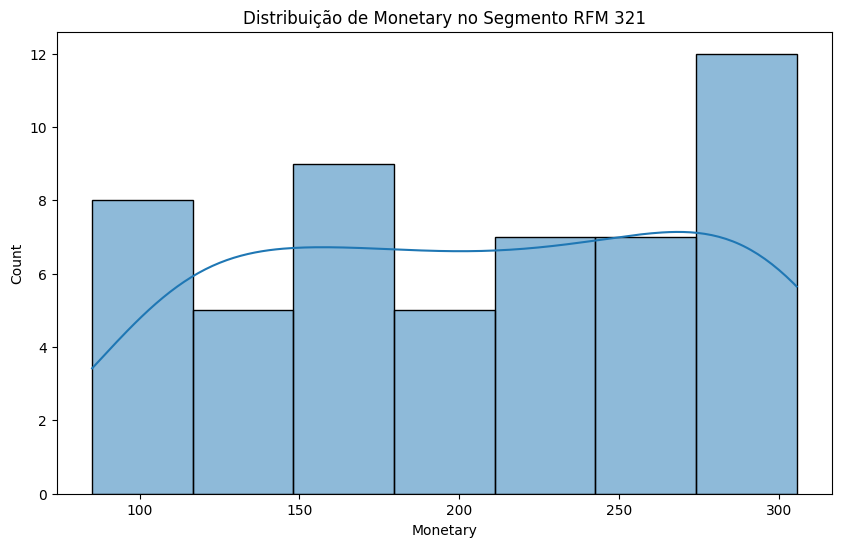



Segmento RFM 313
Número de Clientes: 28
Recência Média: 88.53571428571429
Frequência Média: 9.571428571428571
Monetário Médio: 990.8289285714285


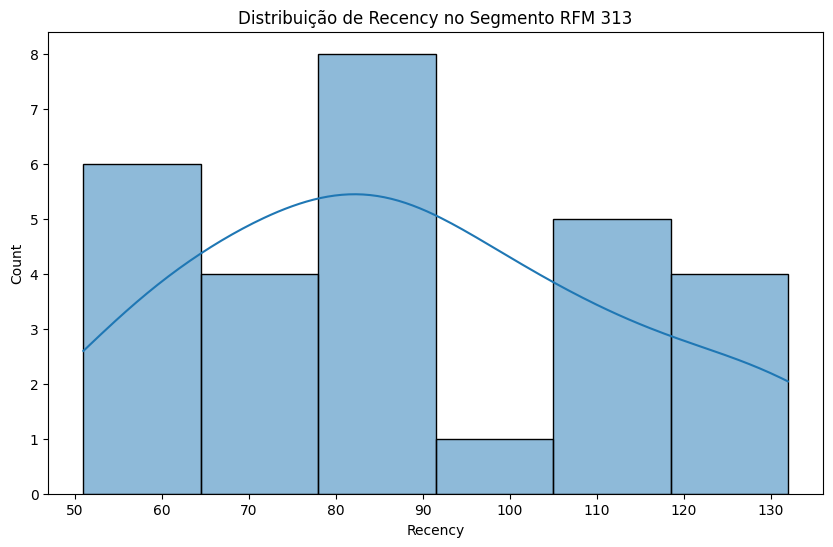

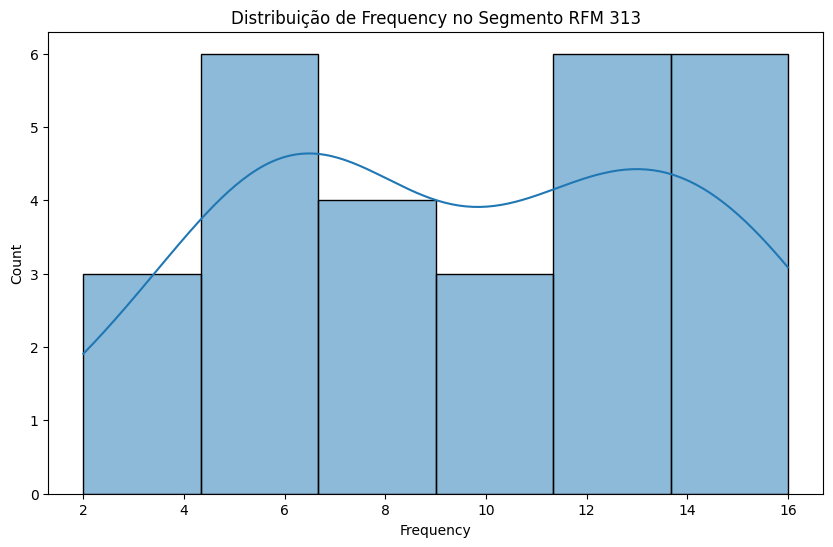

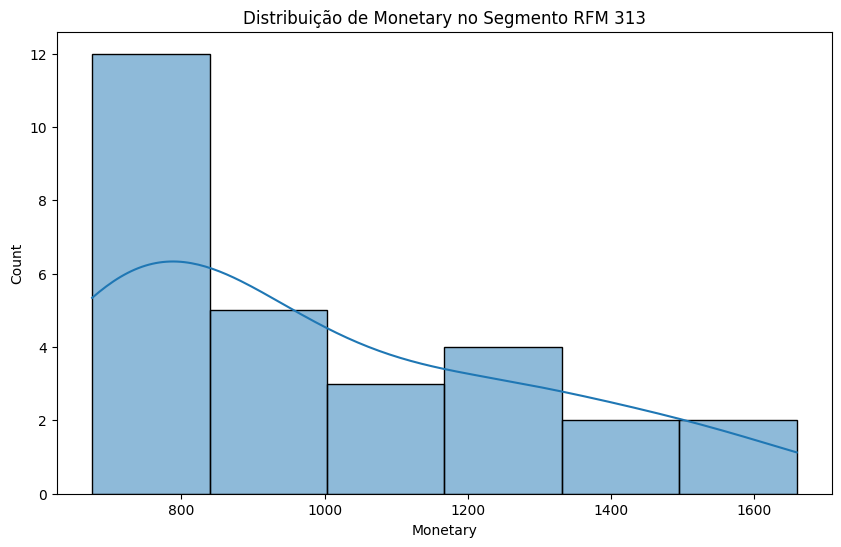



Segmento RFM 444
Número de Clientes: 21
Recência Média: 208.57142857142858
Frequência Média: 176.33333333333334
Monetário Médio: 3025.424333333333


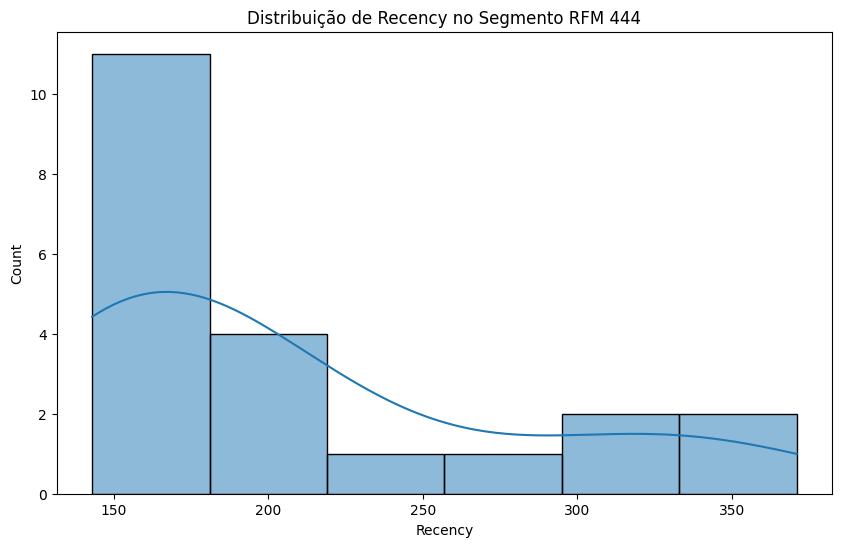

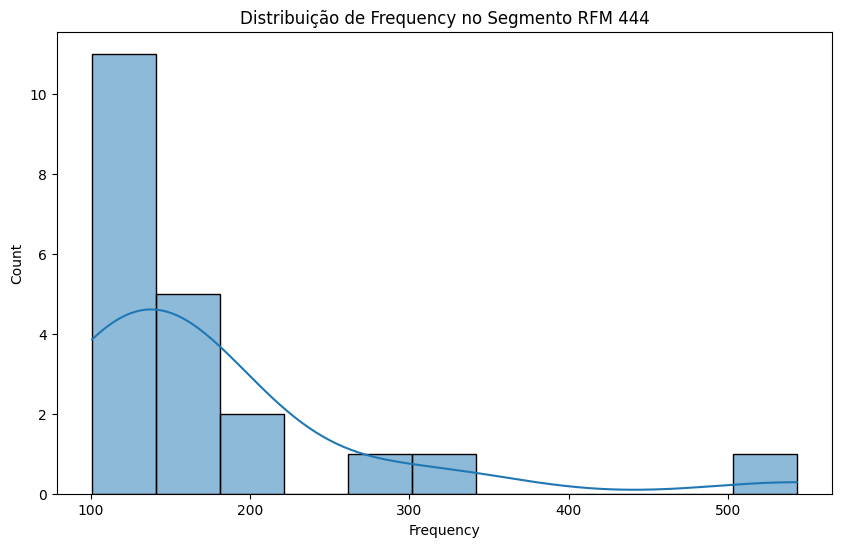

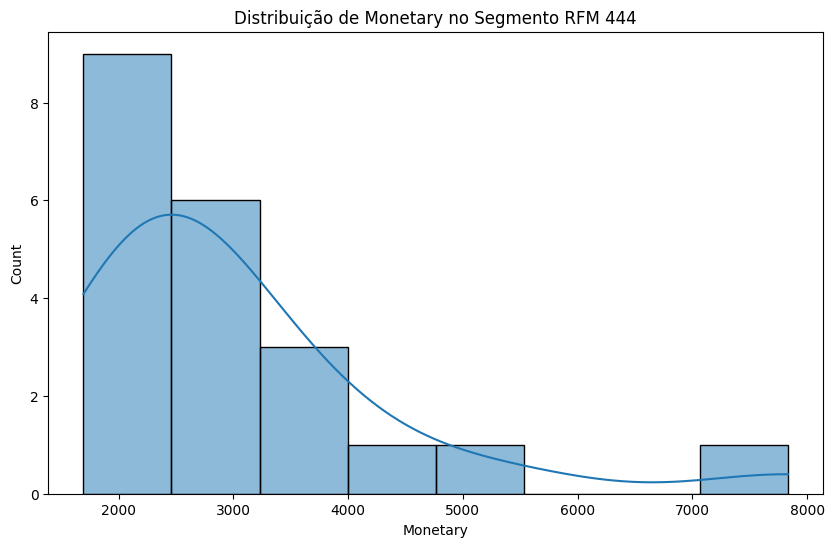

Sugestões: Clientes leais e de alto valor, investir em programas de fidelidade.


Segmento RFM 421
Número de Clientes: 99
Recência Média: 252.14141414141415
Frequência Média: 26.03030303030303
Monetário Médio: 201.6395959595959


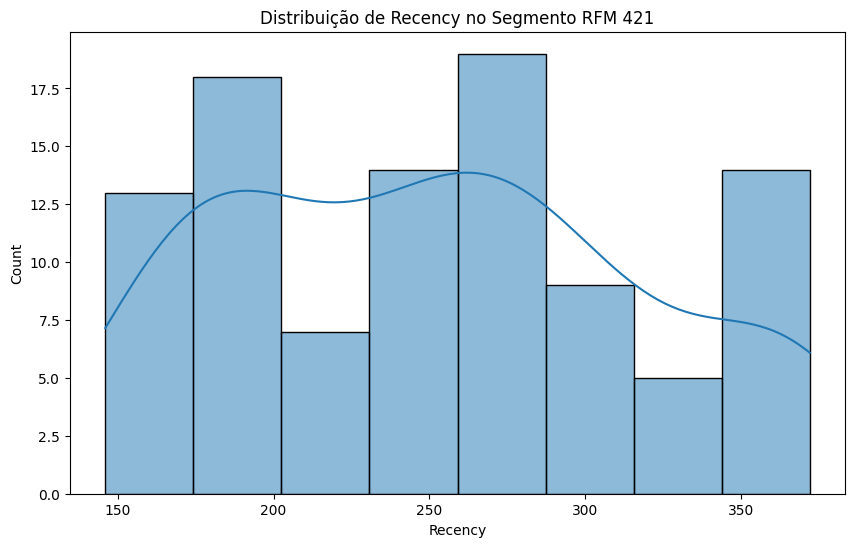

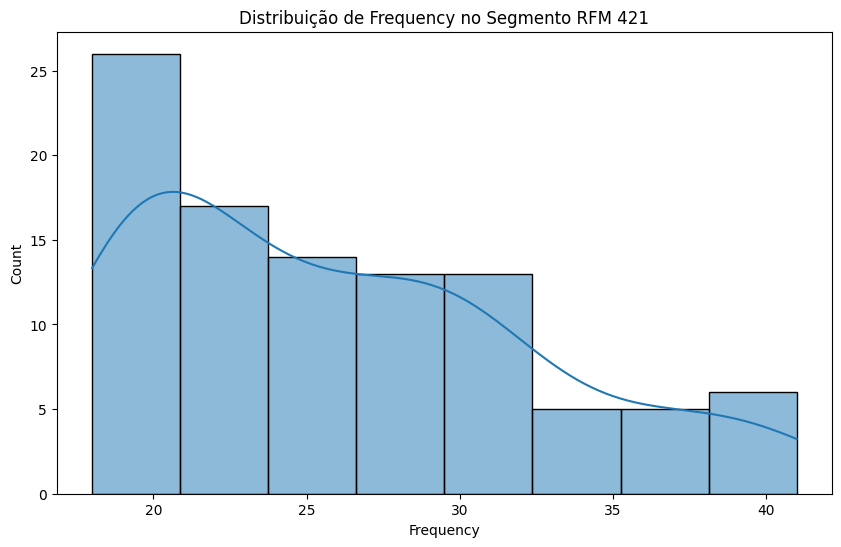

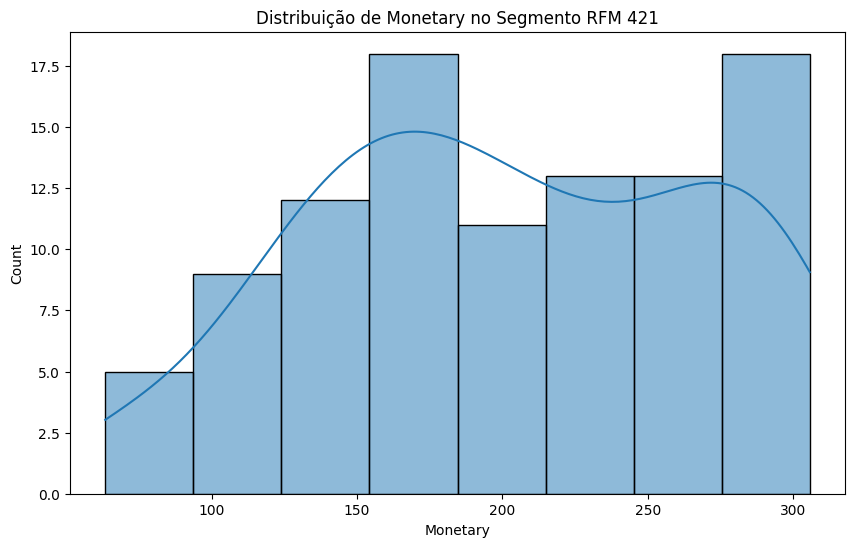



Segmento RFM 242
Número de Clientes: 27
Recência Média: 31.333333333333332
Frequência Média: 137.03703703703704
Monetário Médio: 589.7044444444444


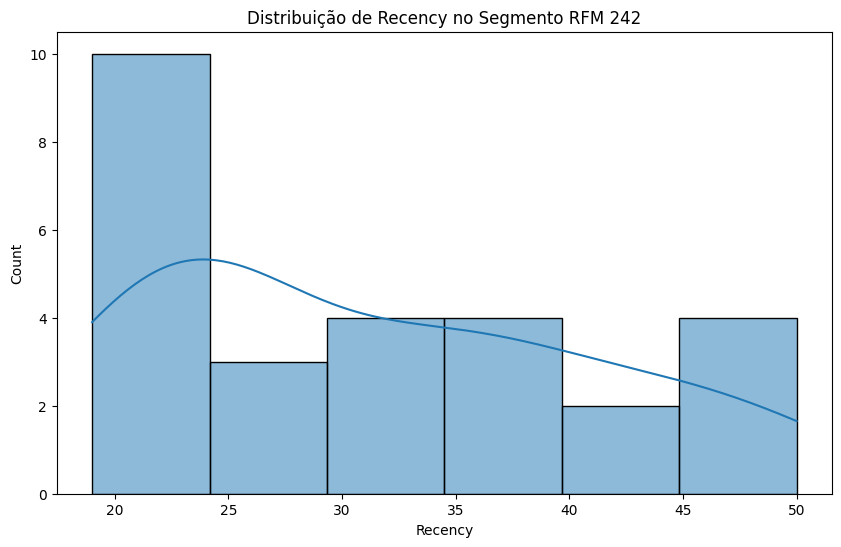

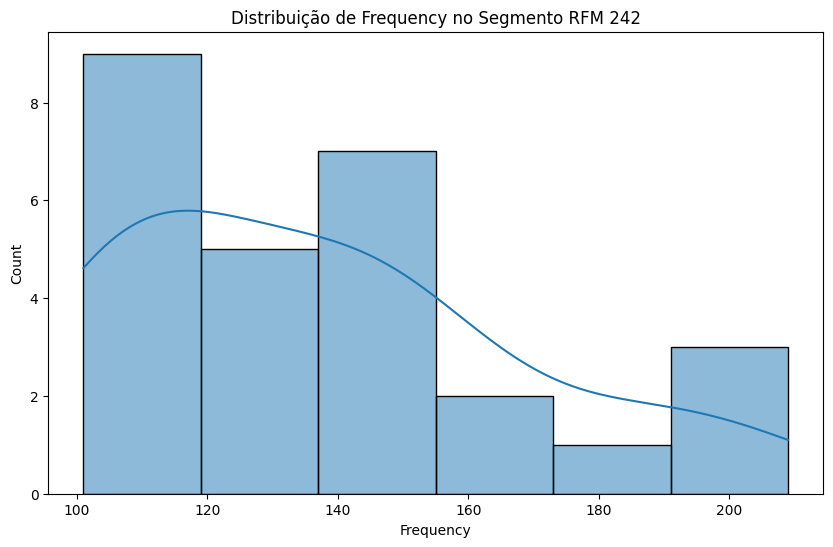

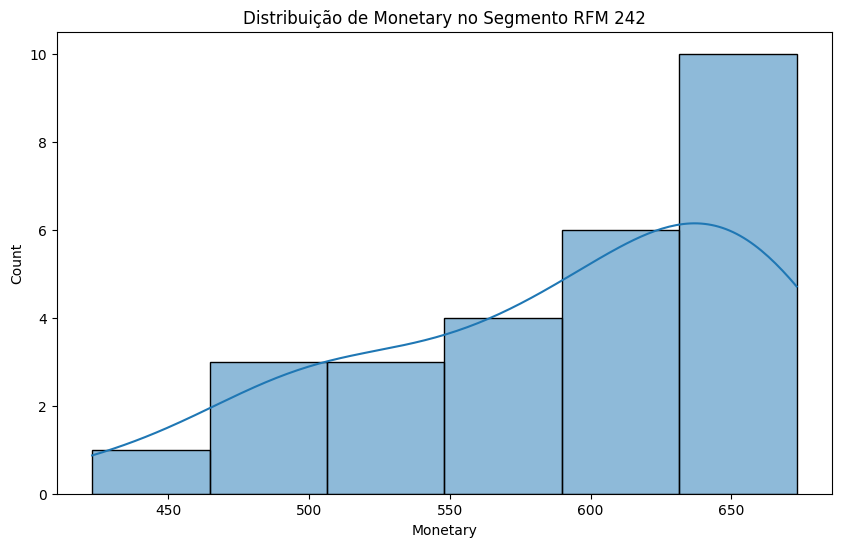



Segmento RFM 124
Número de Clientes: 19
Recência Média: 8.052631578947368
Frequência Média: 30.68421052631579
Monetário Médio: 3522.5205263157895


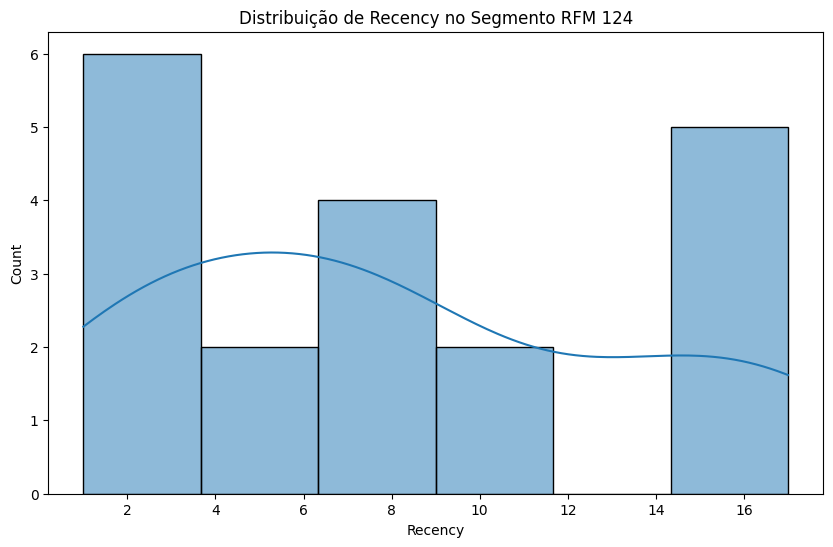

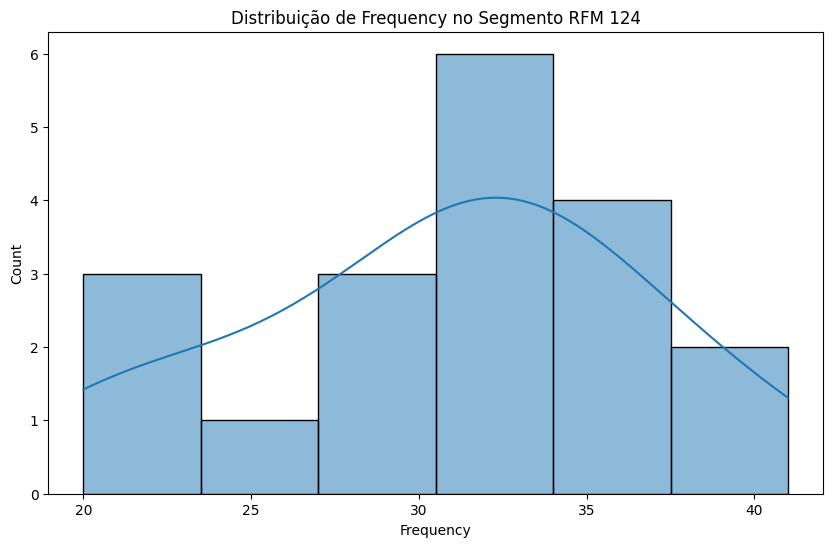

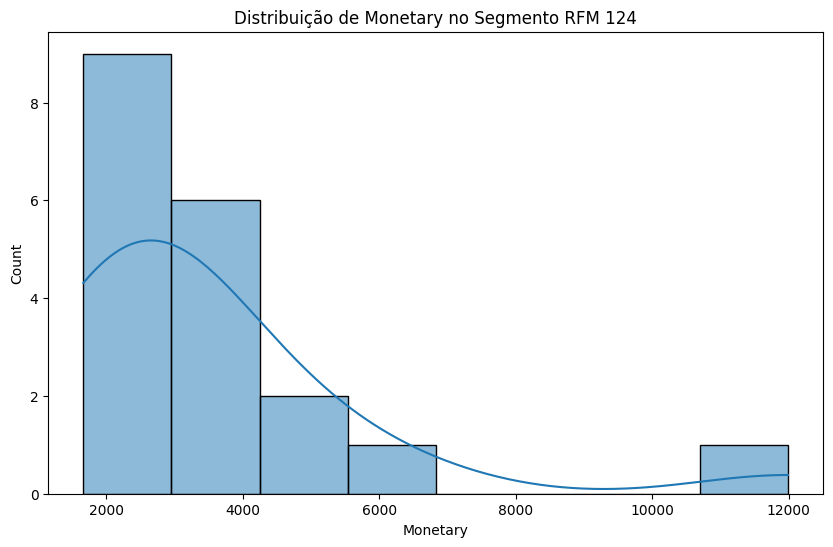



Segmento RFM 311
Número de Clientes: 179
Recência Média: 84.60893854748603
Frequência Média: 8.659217877094973
Monetário Médio: 169.0208379888268


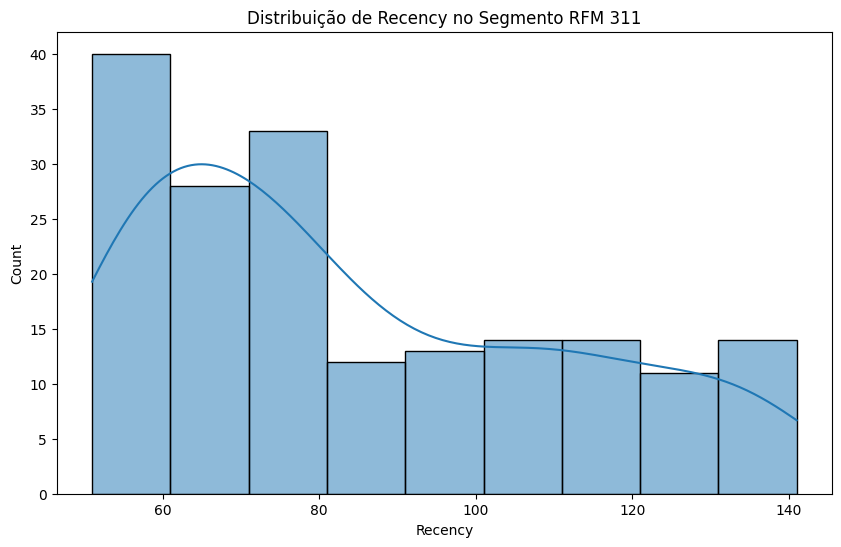

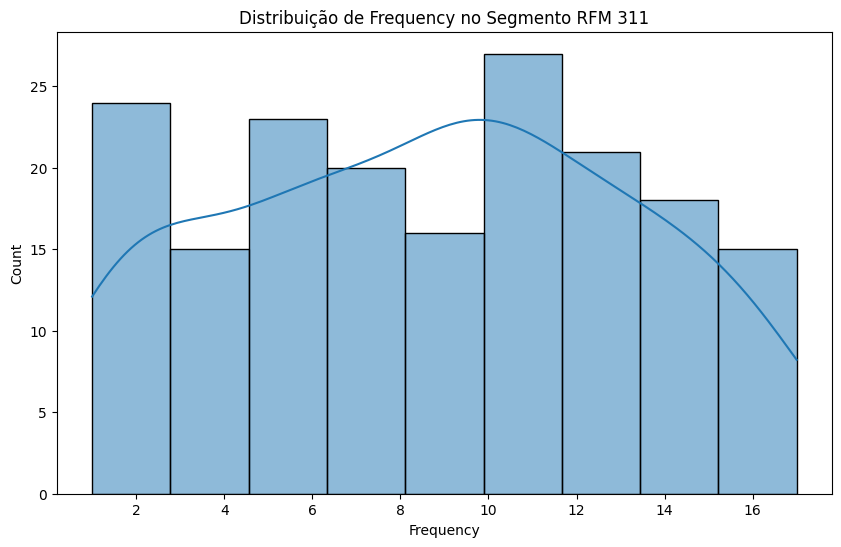

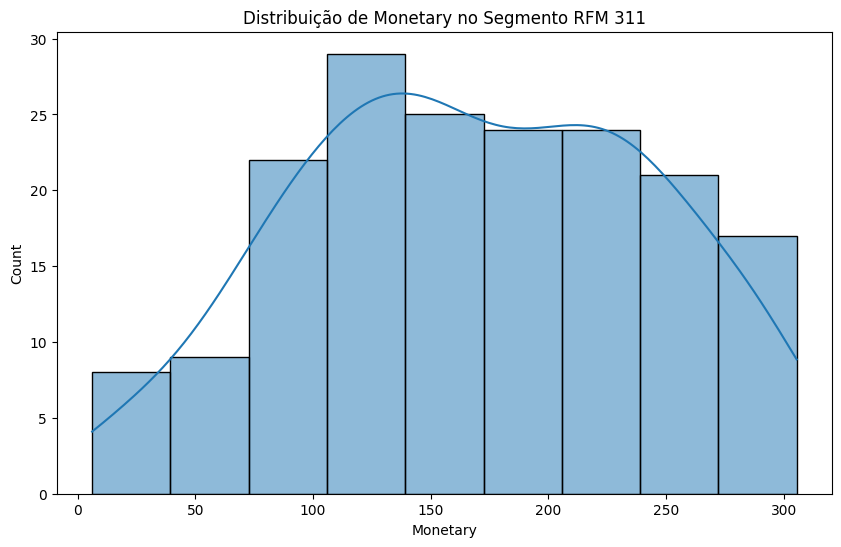



Segmento RFM 213
Número de Clientes: 15
Recência Média: 30.466666666666665
Frequência Média: 10.4
Monetário Médio: 1002.0353333333333


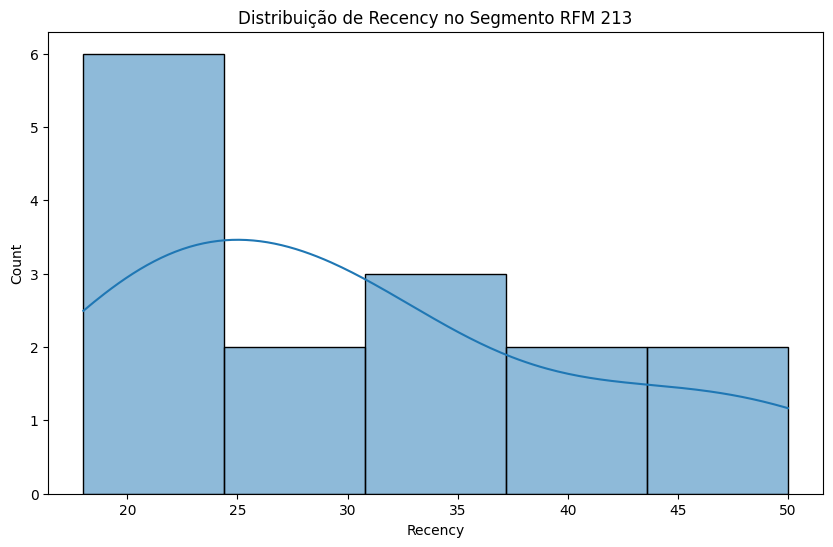

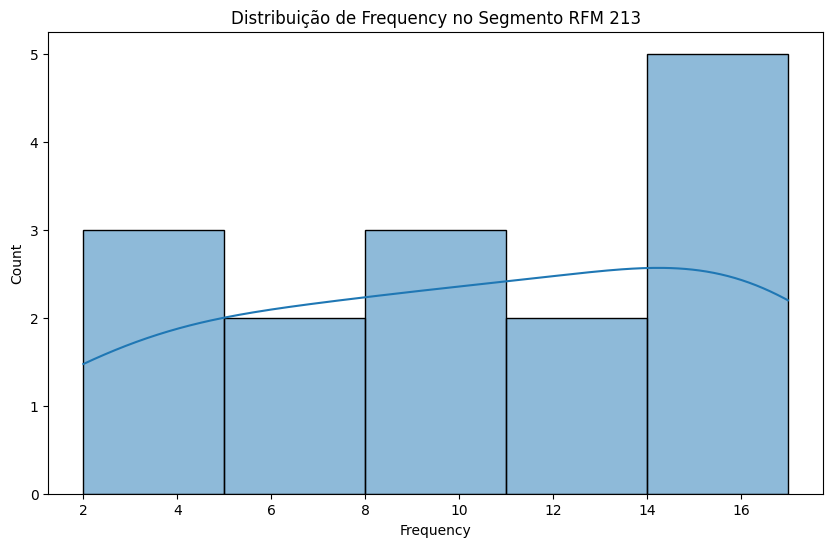

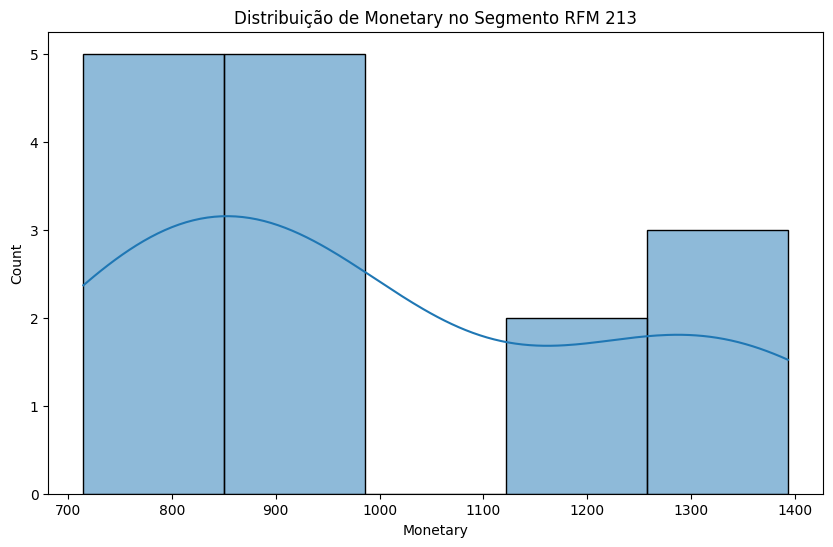



Segmento RFM 343
Número de Clientes: 40
Recência Média: 76.4
Frequência Média: 152.475
Monetário Médio: 1173.81475


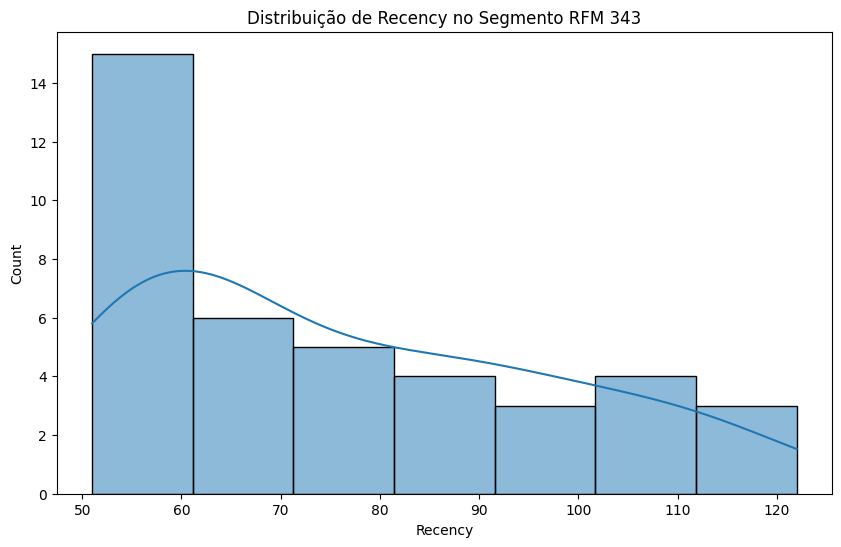

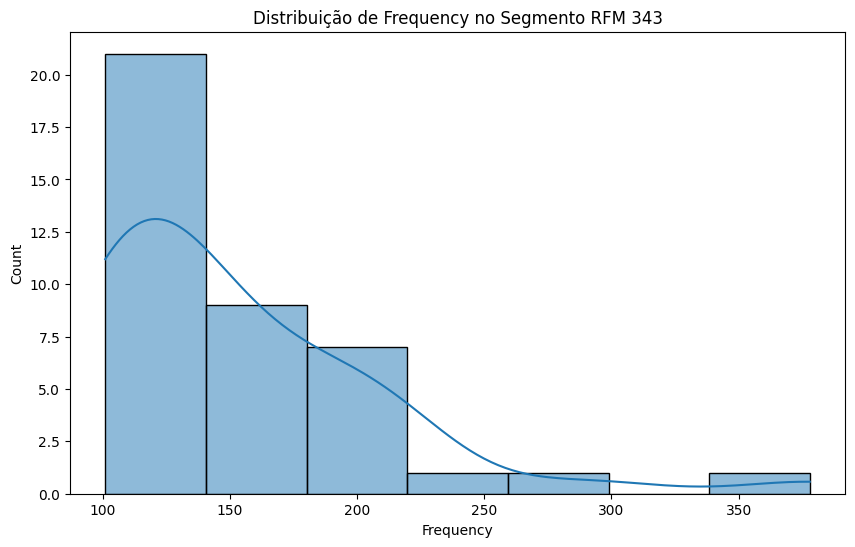

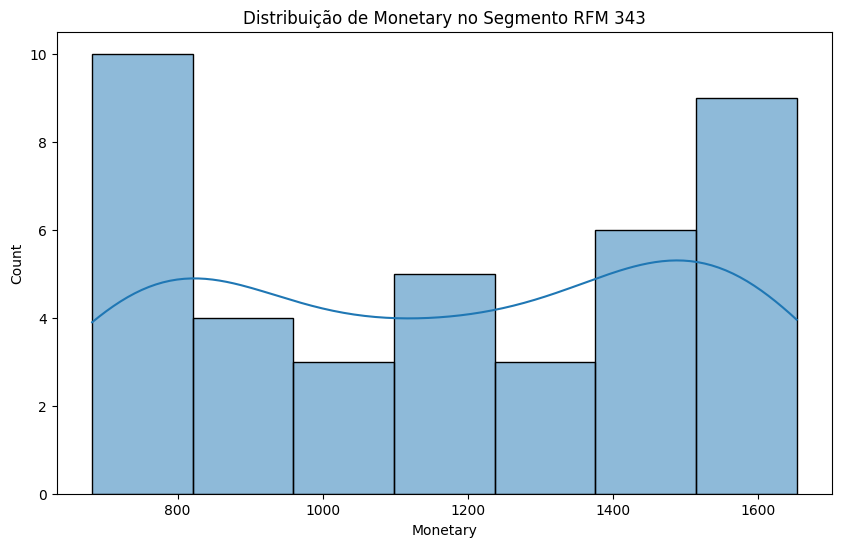



Segmento RFM 132
Número de Clientes: 45
Recência Média: 7.977777777777778
Frequência Média: 66.13333333333334
Monetário Médio: 472.2795555555556


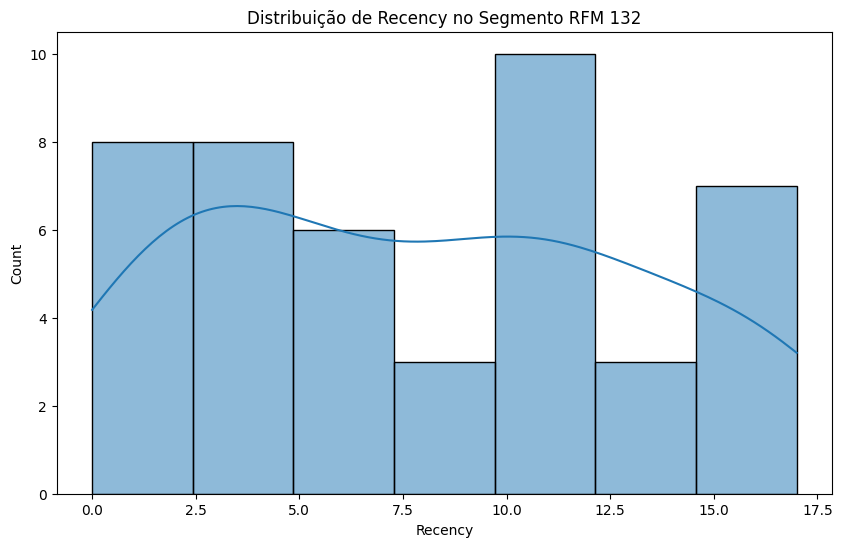

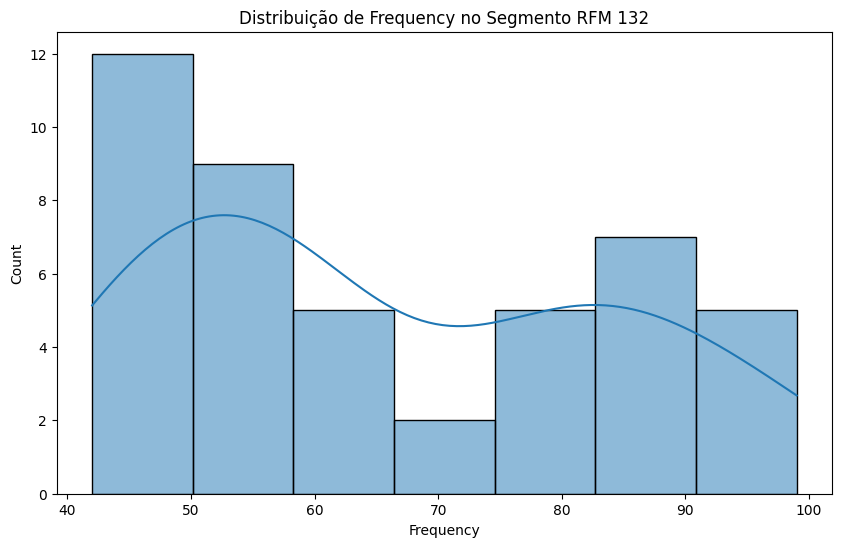

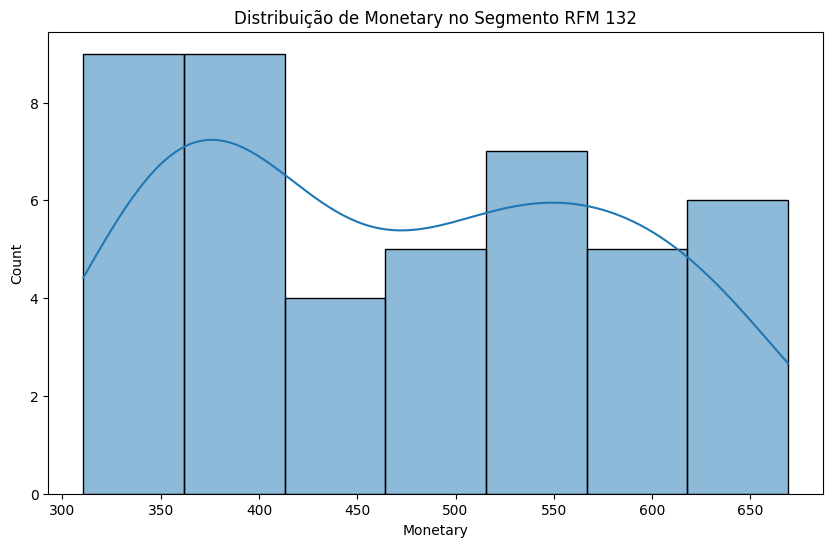



Segmento RFM 342
Número de Clientes: 13
Recência Média: 87.15384615384616
Frequência Média: 137.46153846153845
Monetário Médio: 552.6715384615384


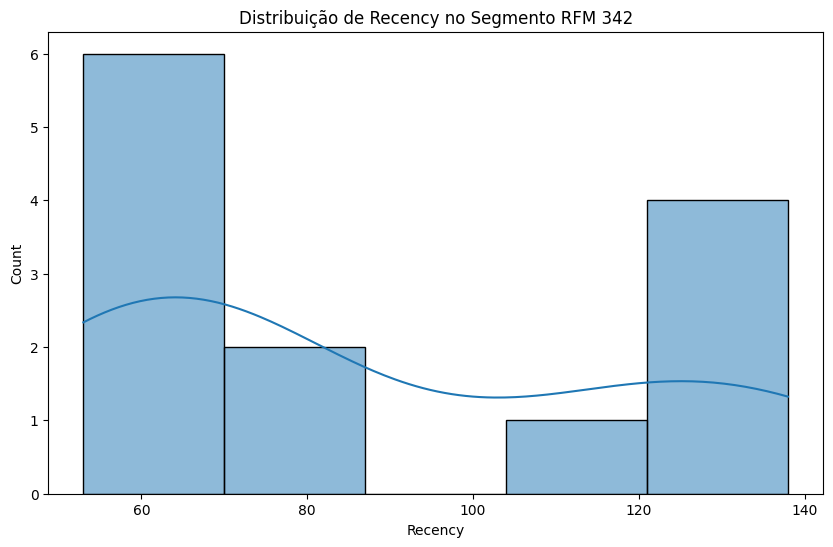

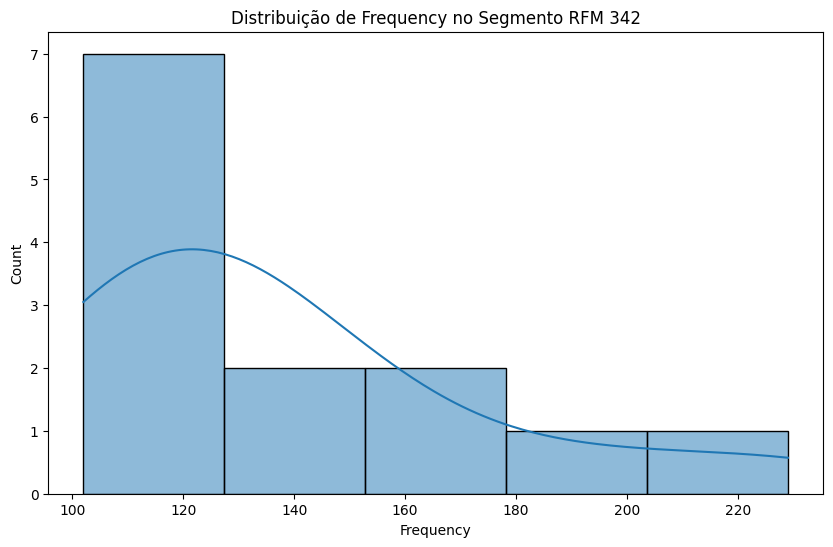

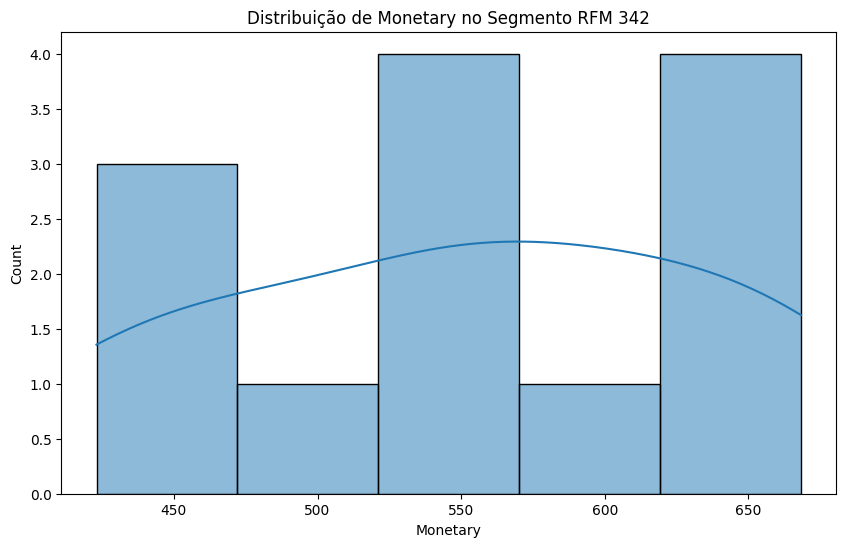



Segmento RFM 413
Número de Clientes: 24
Recência Média: 239.375
Frequência Média: 8.791666666666666
Monetário Médio: 961.3283333333334


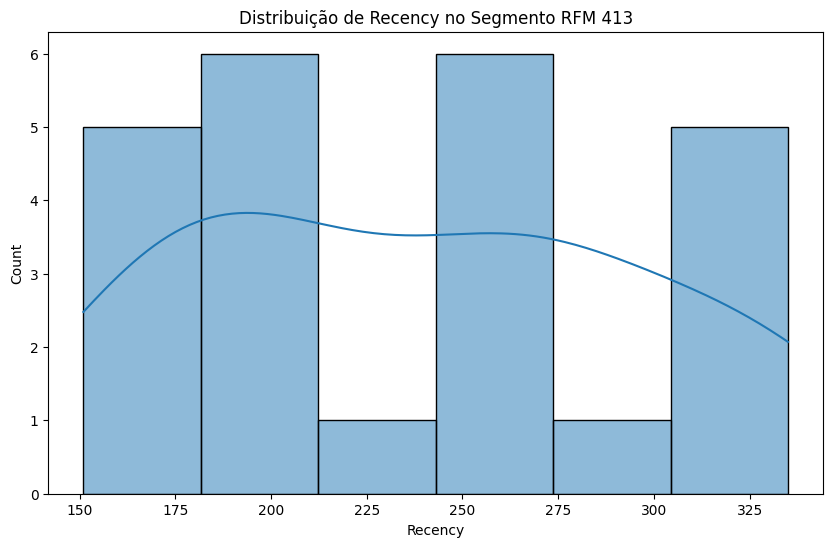

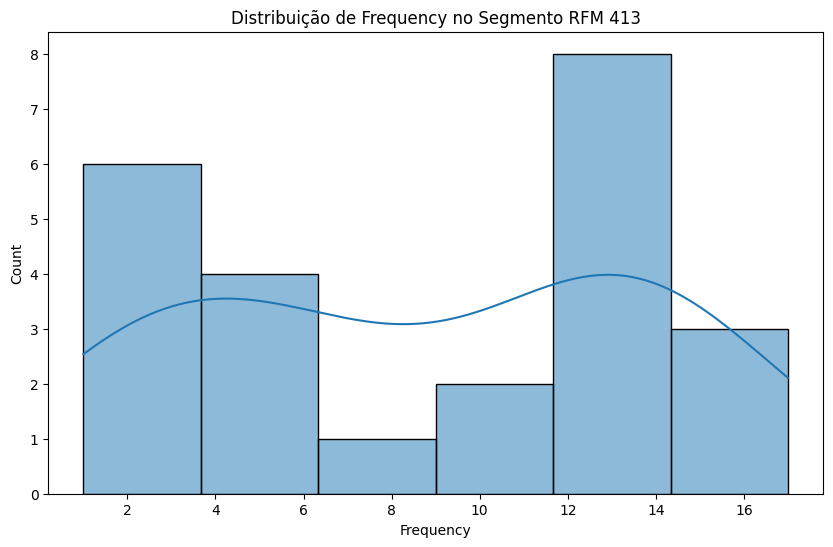

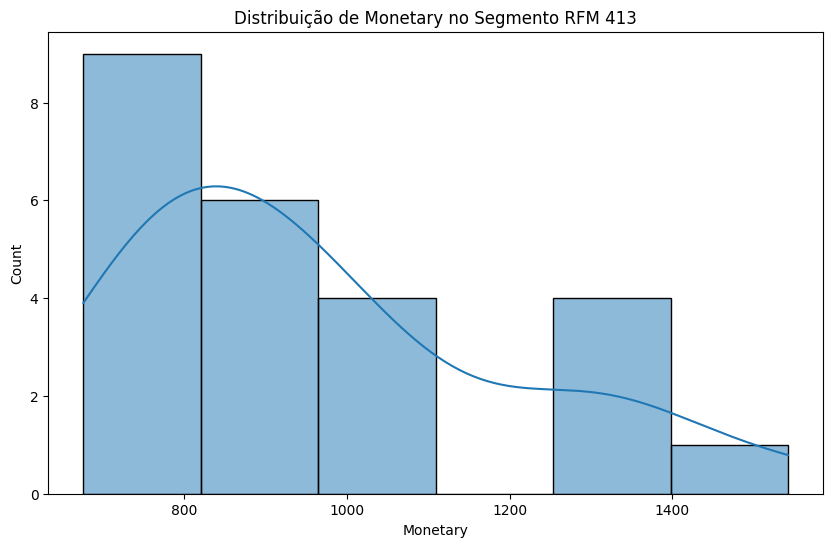



Segmento RFM 114
Número de Clientes: 6
Recência Média: 7.166666666666667
Frequência Média: 6.0
Monetário Médio: 33370.706666666665


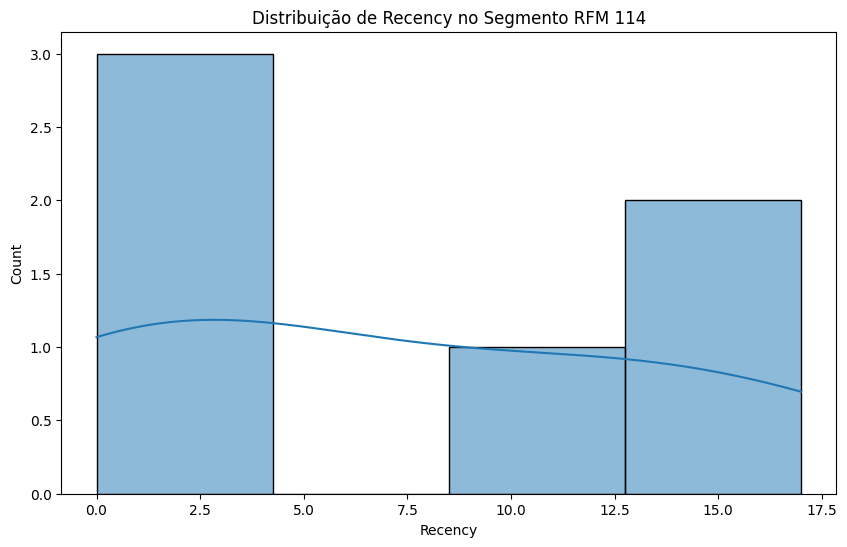

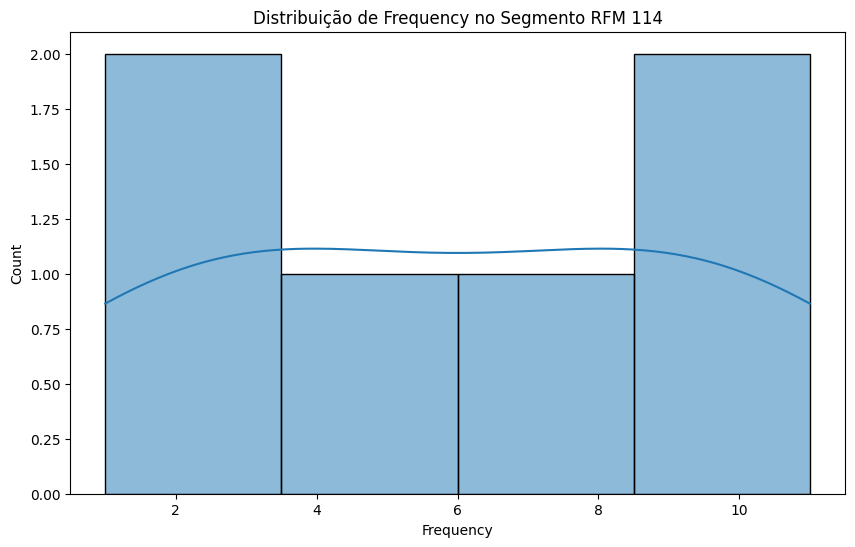

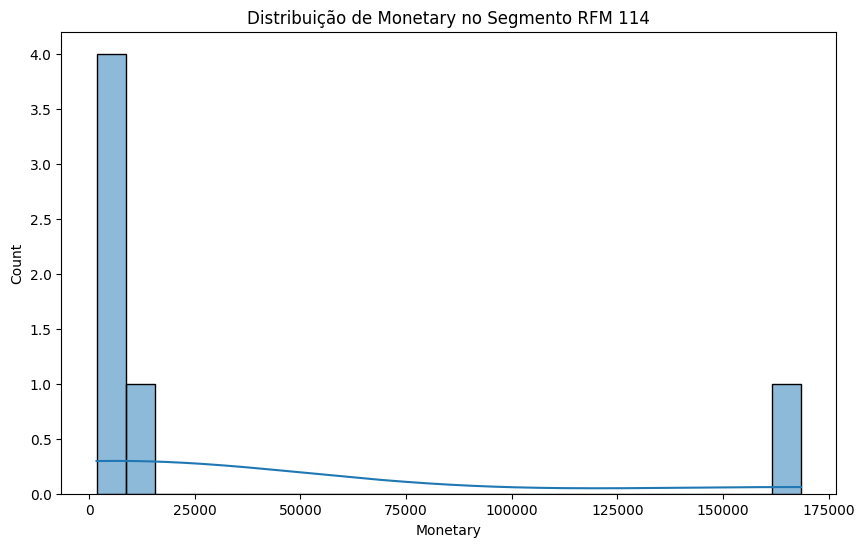



Segmento RFM 224
Número de Clientes: 12
Recência Média: 34.083333333333336
Frequência Média: 28.916666666666668
Monetário Médio: 2974.605833333333


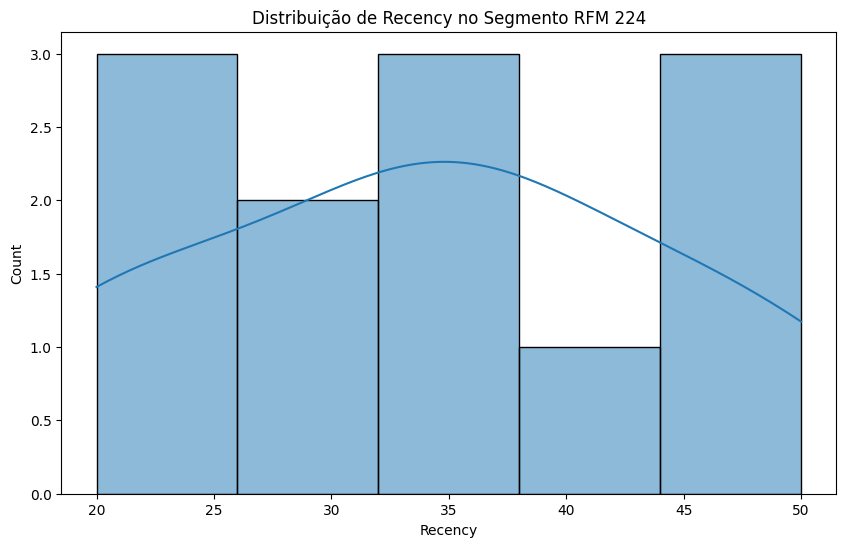

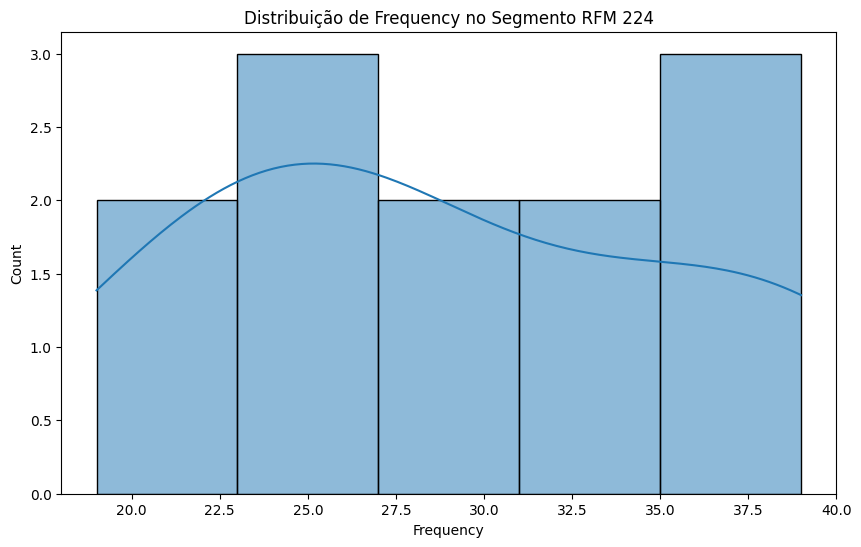

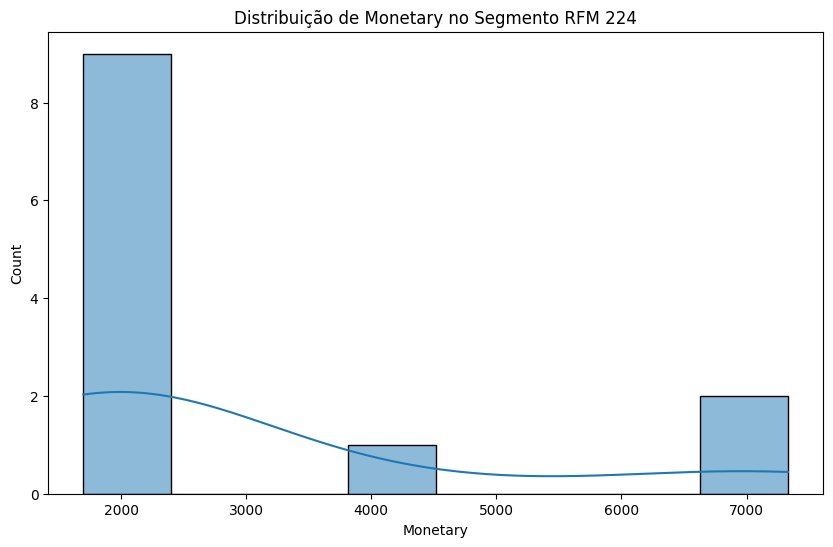



Segmento RFM 243
Número de Clientes: 82
Recência Média: 29.121951219512194
Frequência Média: 170.0
Monetário Médio: 1149.9525609756097


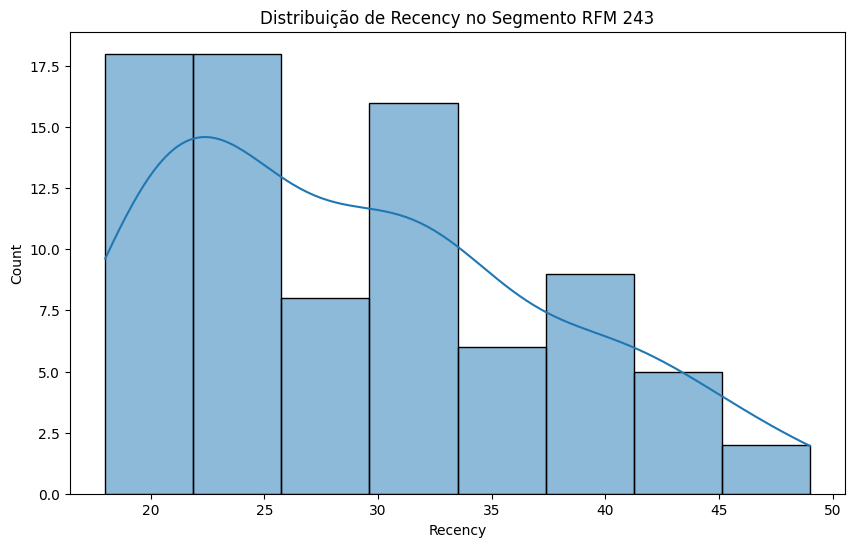

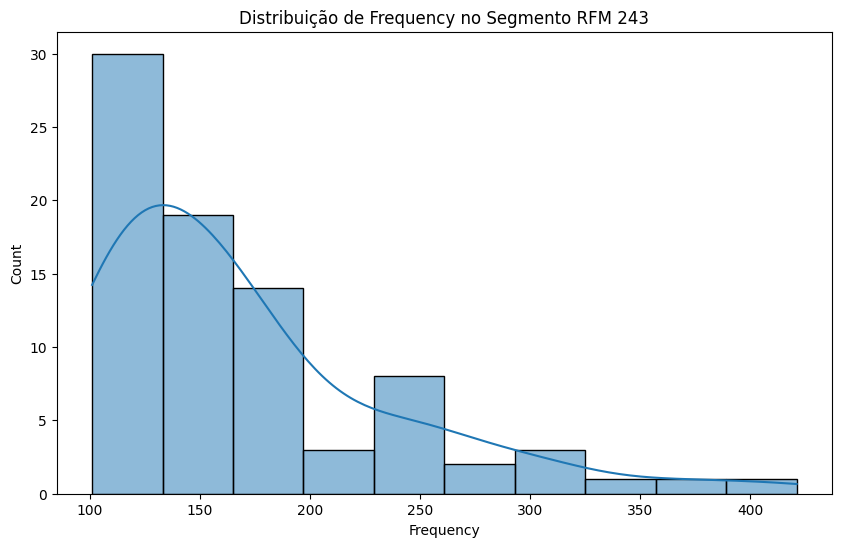

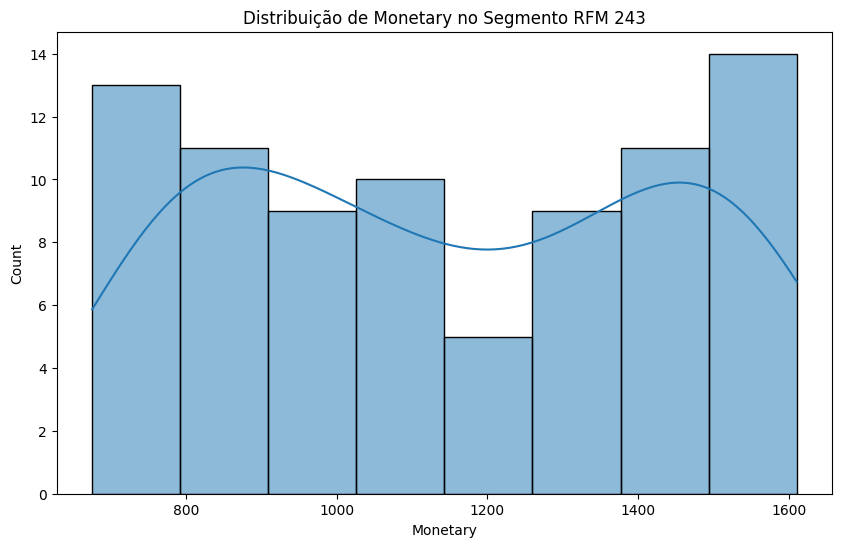



Segmento RFM 331
Número de Clientes: 22
Recência Média: 75.95454545454545
Frequência Média: 59.09090909090909
Monetário Médio: 219.18954545454542


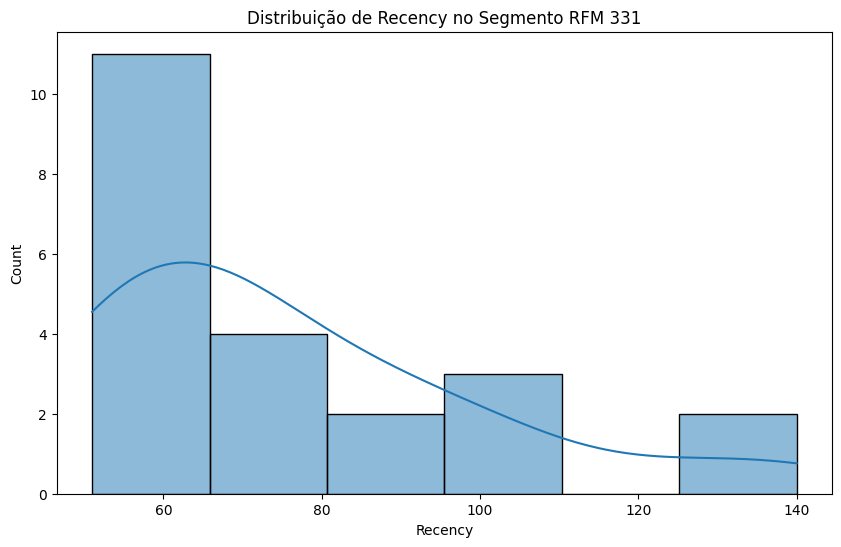

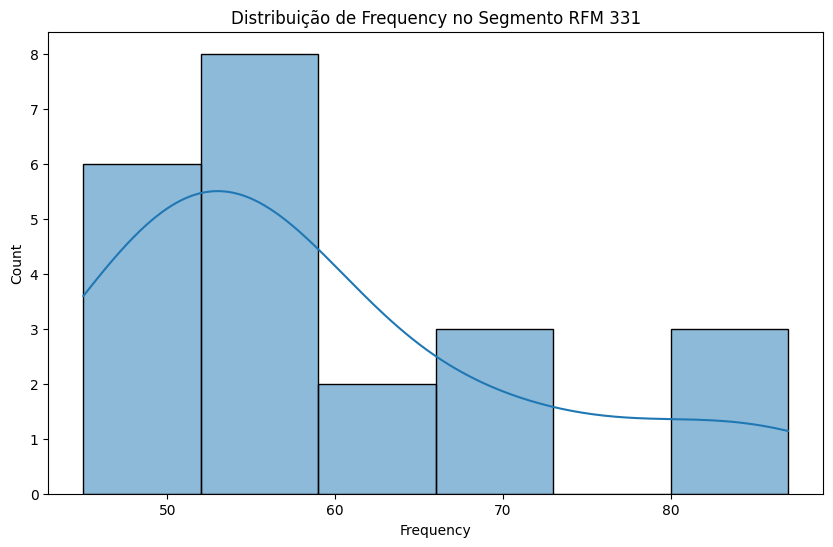

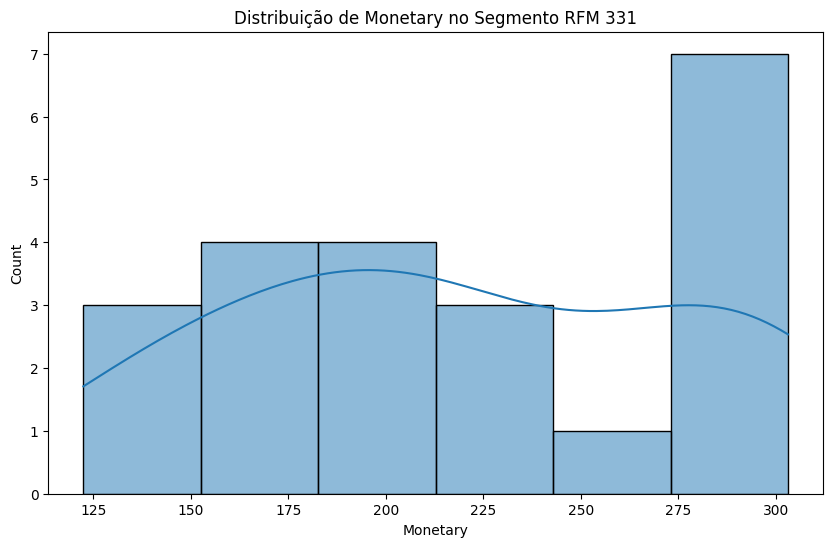



Segmento RFM 443
Número de Clientes: 21
Recência Média: 213.85714285714286
Frequência Média: 156.42857142857142
Monetário Médio: 1101.6771428571428


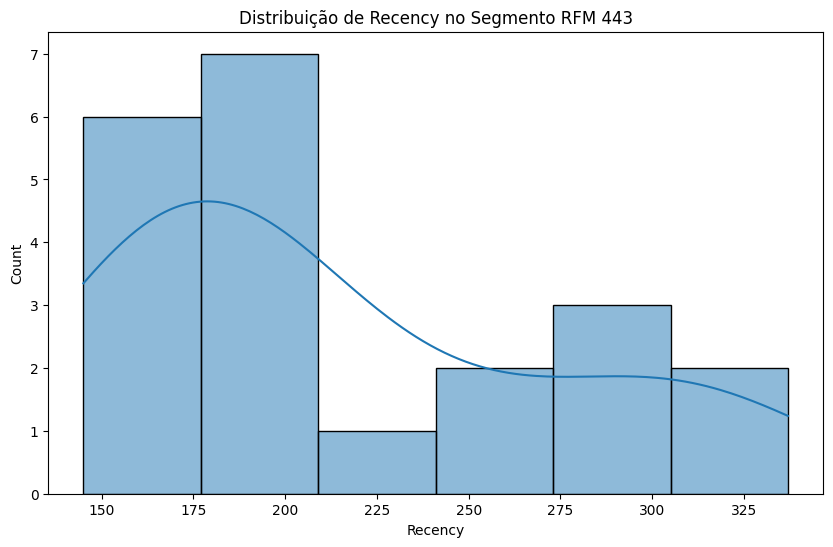

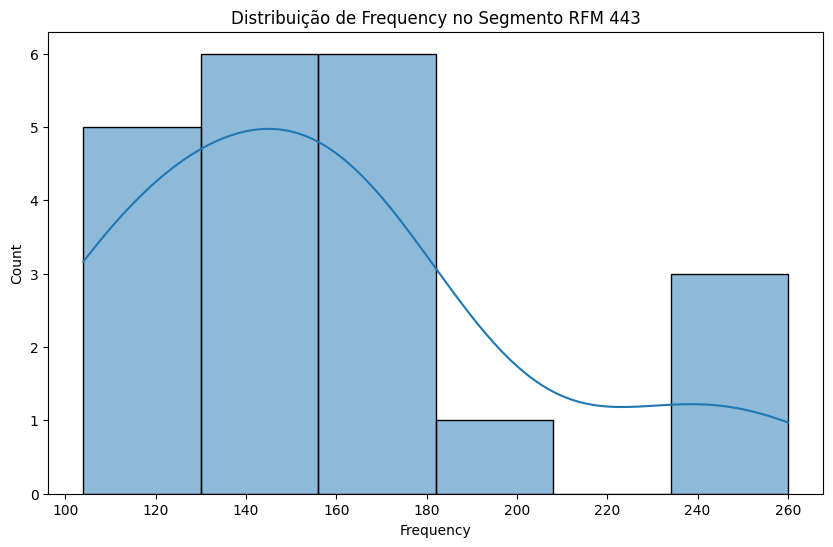

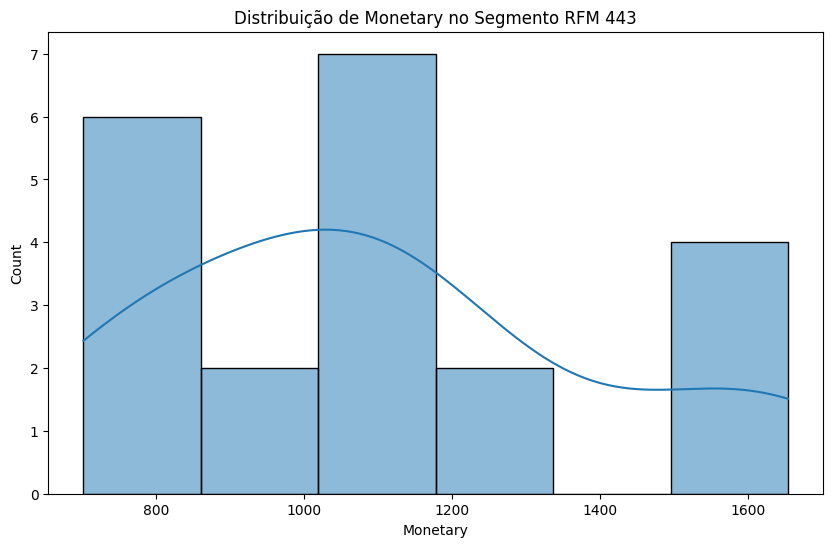



Segmento RFM 432
Número de Clientes: 48
Recência Média: 239.41666666666666
Frequência Média: 67.14583333333333
Monetário Médio: 469.64354166666664


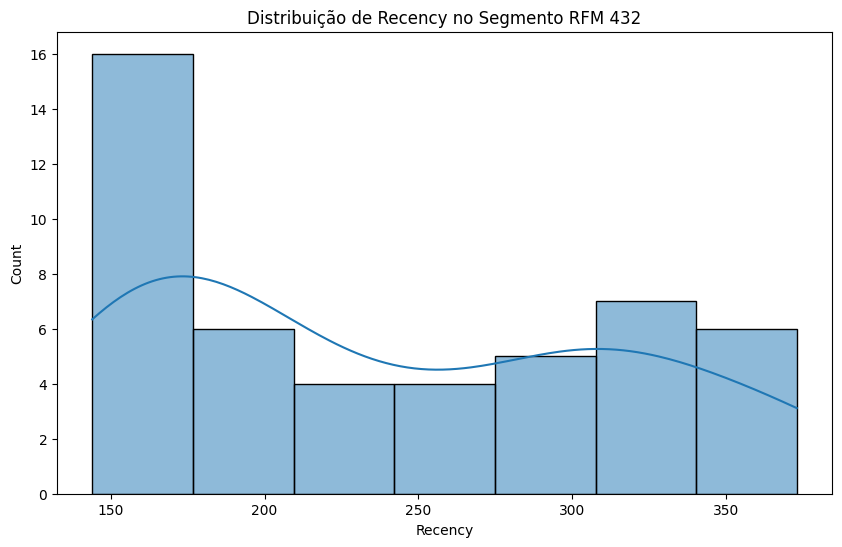

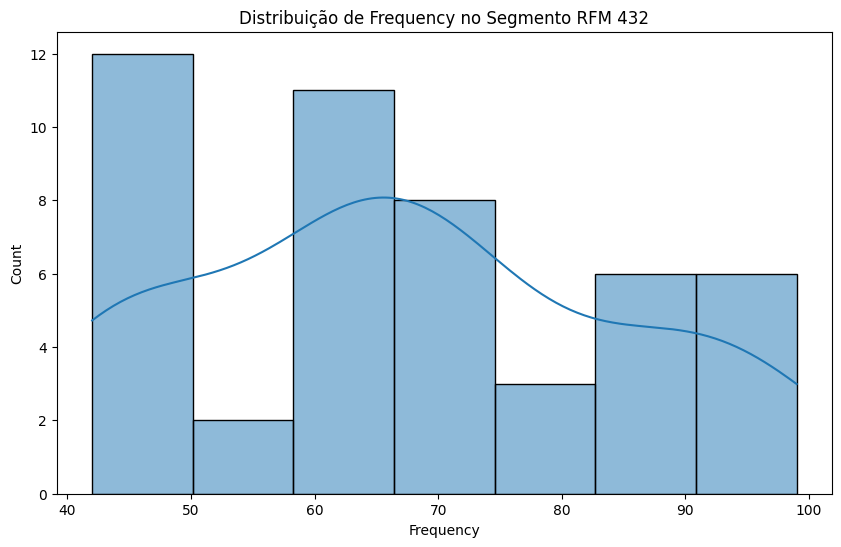

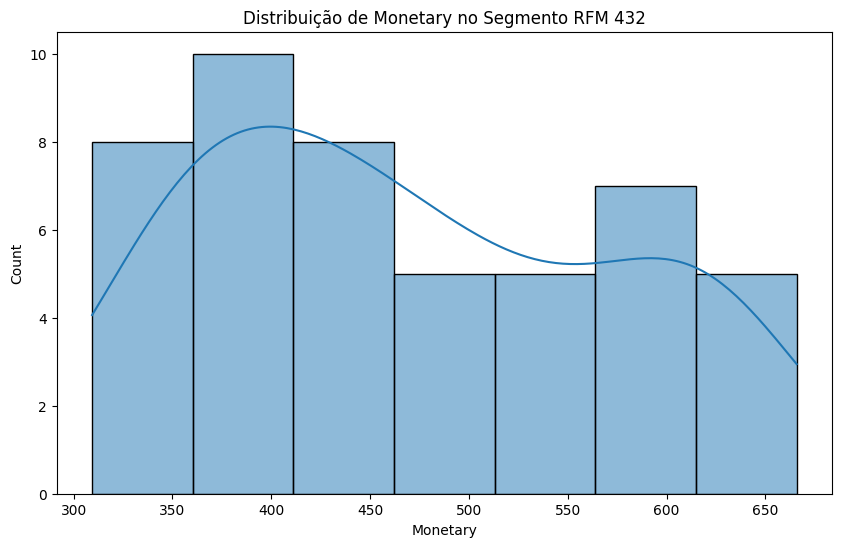



Segmento RFM 143
Número de Clientes: 88
Recência Média: 7.420454545454546
Frequência Média: 186.92045454545453
Monetário Médio: 1177.6092045454543


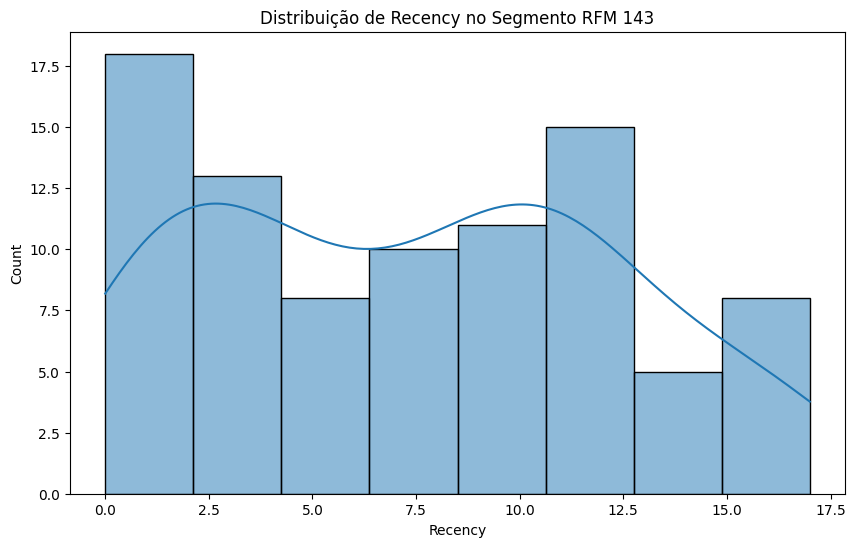

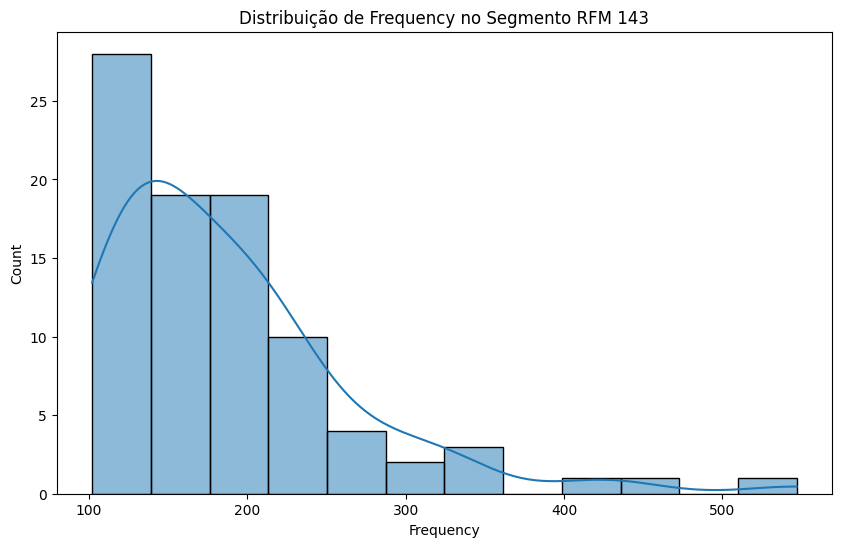

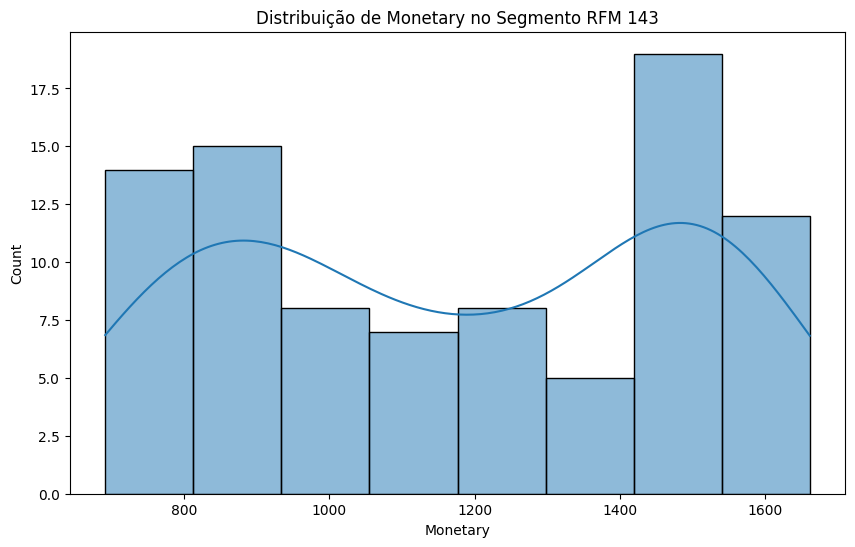



Segmento RFM 113
Número de Clientes: 13
Recência Média: 9.384615384615385
Frequência Média: 11.923076923076923
Monetário Médio: 1081.5492307692307


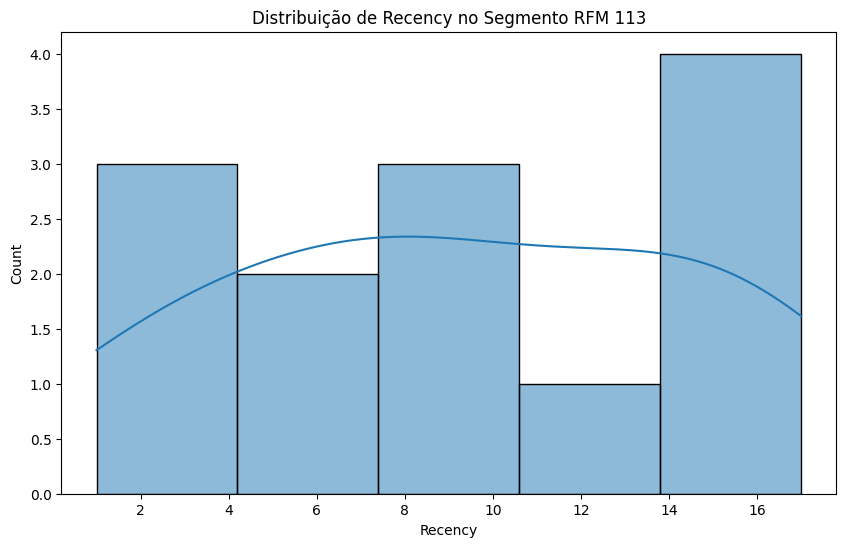

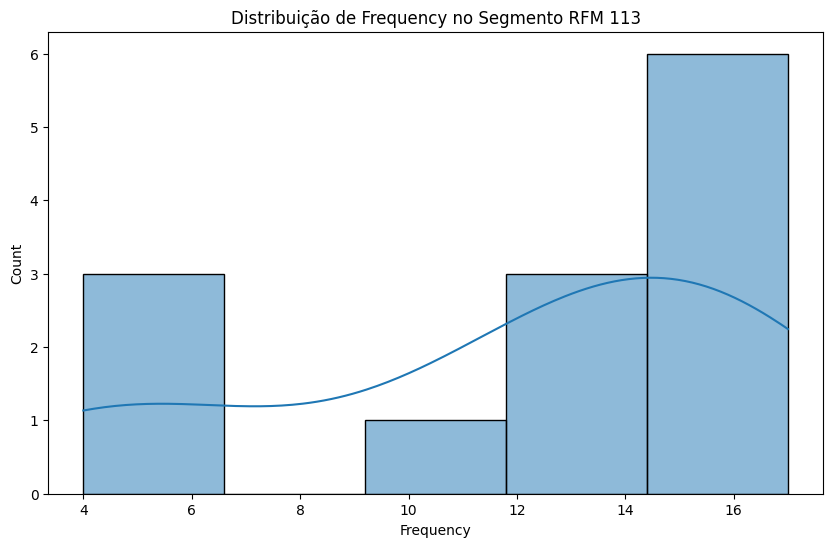

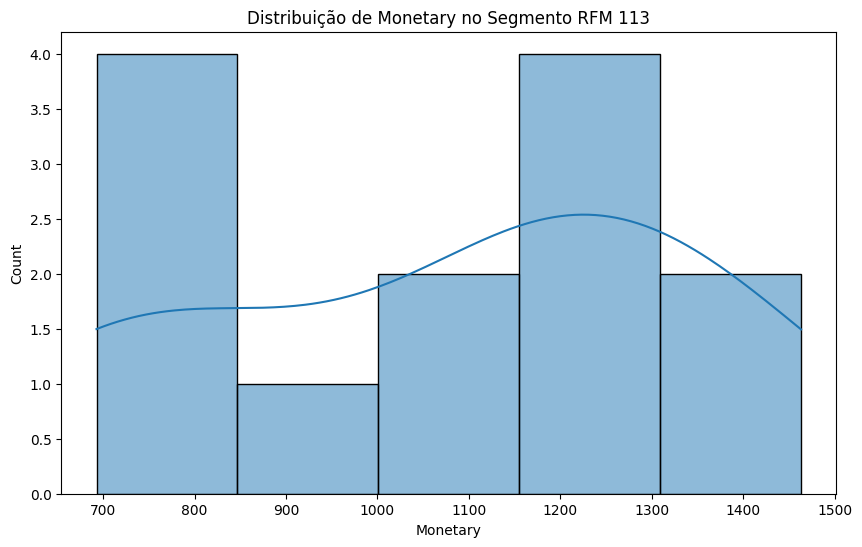



Segmento RFM 221
Número de Clientes: 53
Recência Média: 32.320754716981135
Frequência Média: 28.660377358490567
Monetário Médio: 198.89358490566036


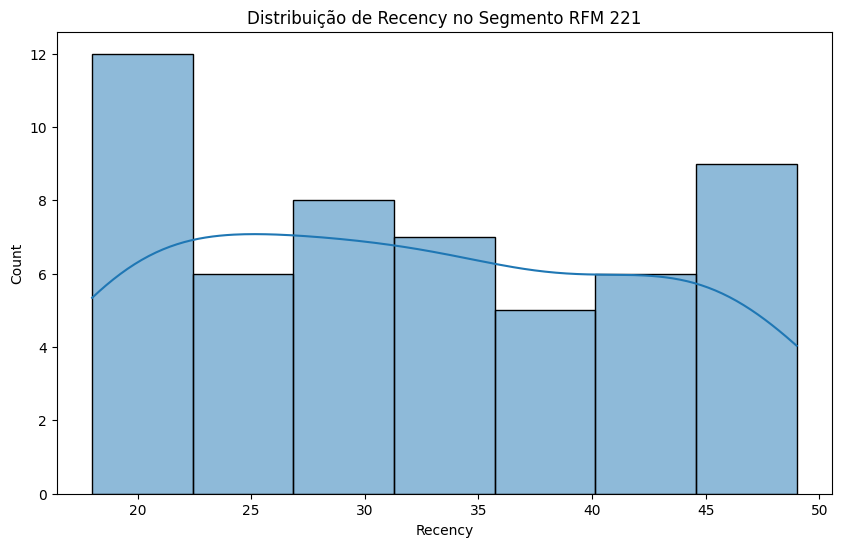

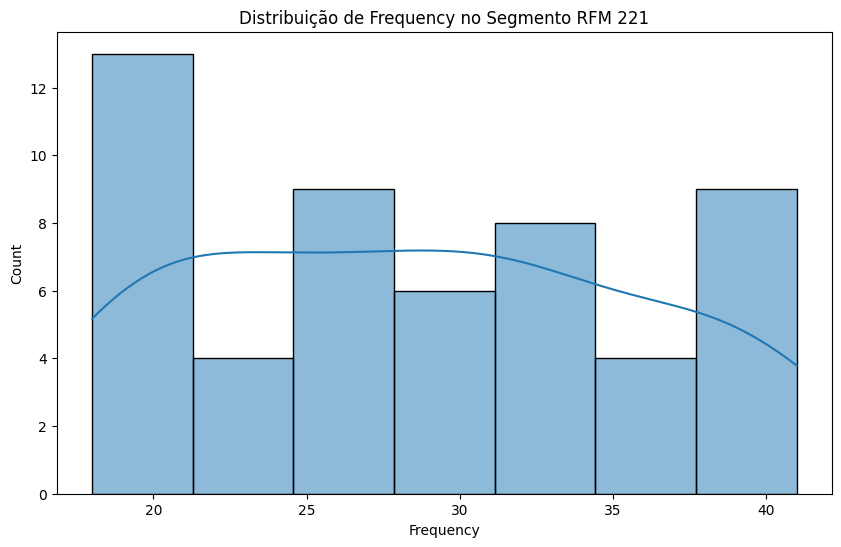

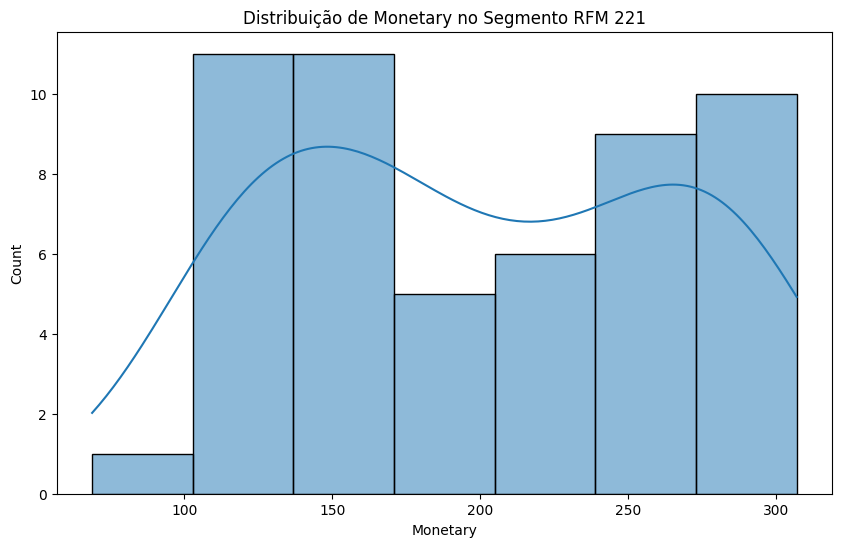



Segmento RFM 121
Número de Clientes: 27
Recência Média: 10.407407407407407
Frequência Média: 26.703703703703702
Monetário Médio: 228.7296296296296


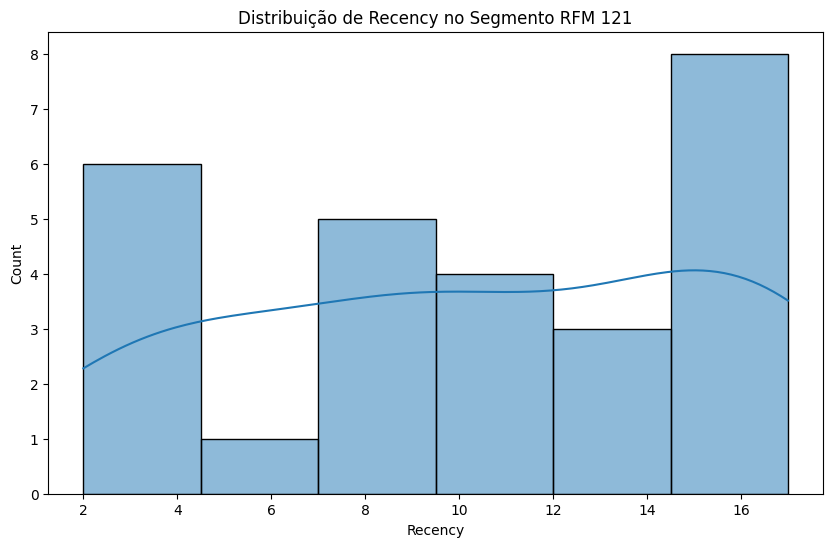

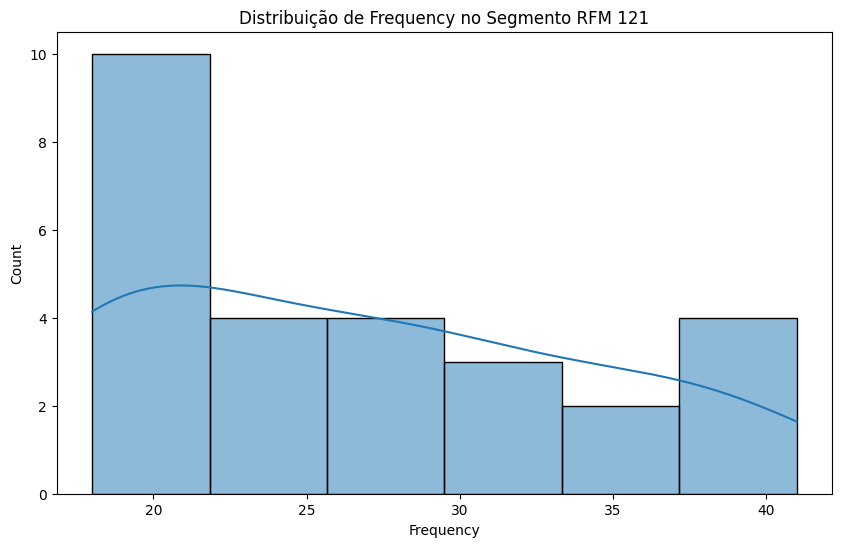

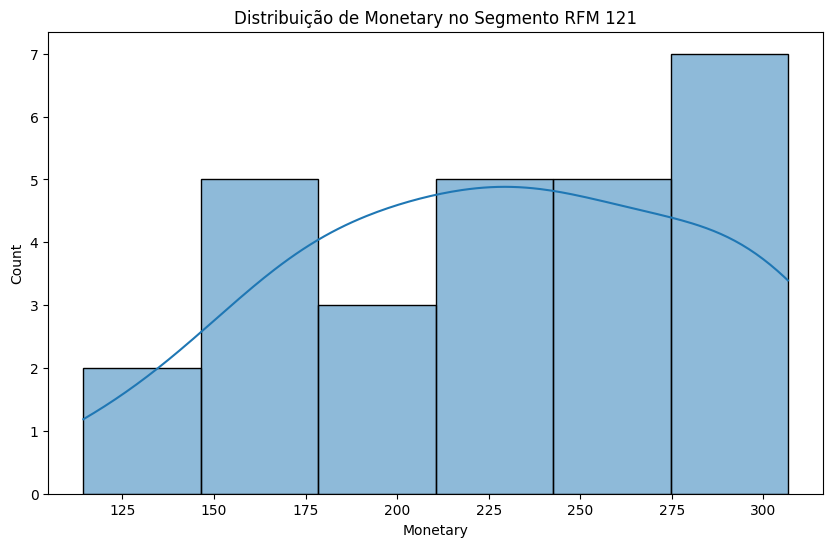



Segmento RFM 142
Número de Clientes: 16
Recência Média: 8.9375
Frequência Média: 133.125
Monetário Médio: 542.578125


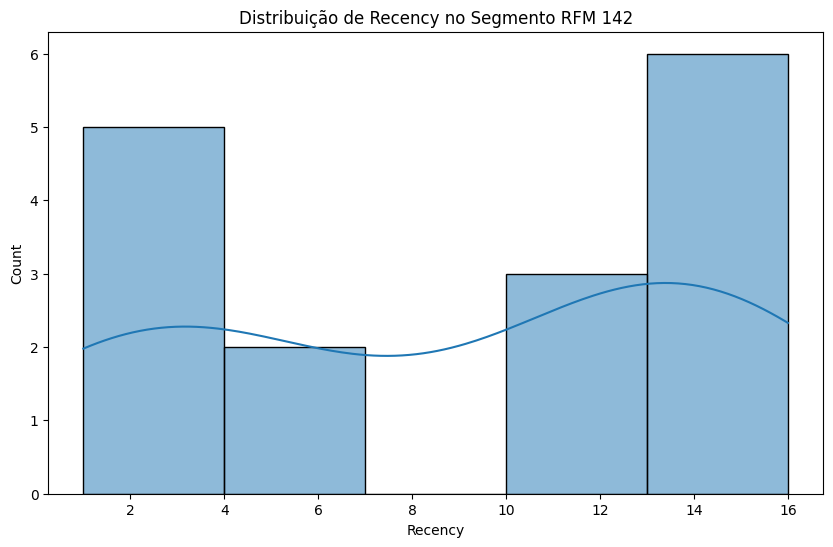

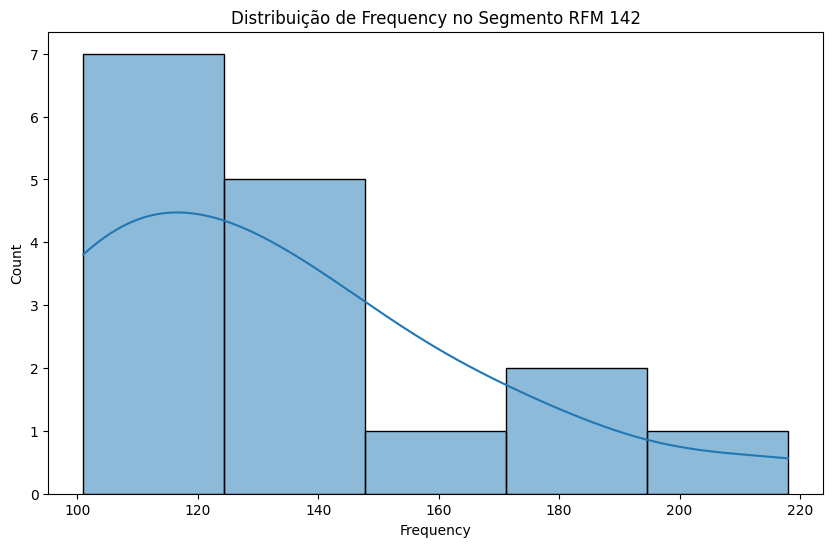

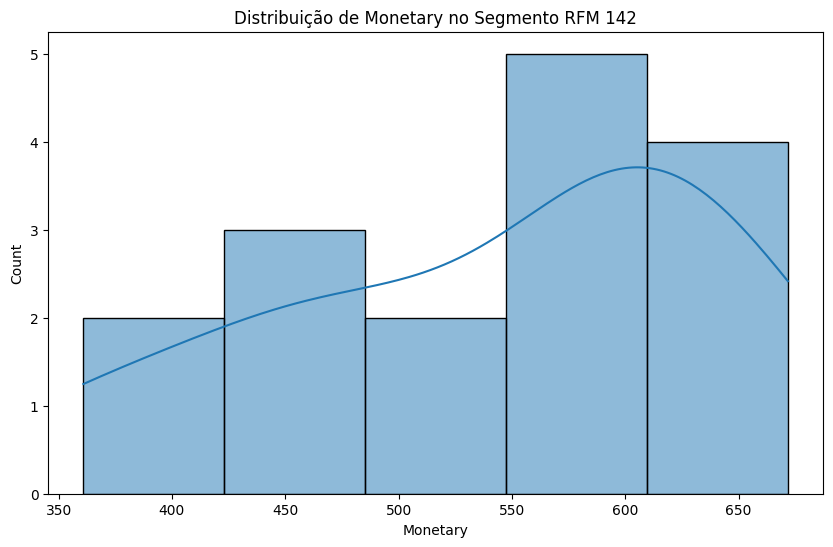



Segmento RFM 431
Número de Clientes: 36
Recência Média: 261.3888888888889
Frequência Média: 59.361111111111114
Monetário Médio: 237.60166666666666


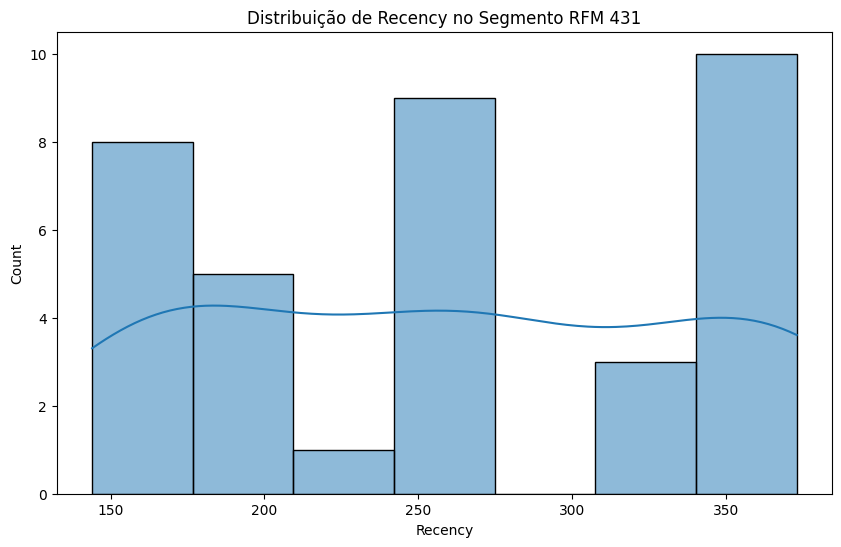

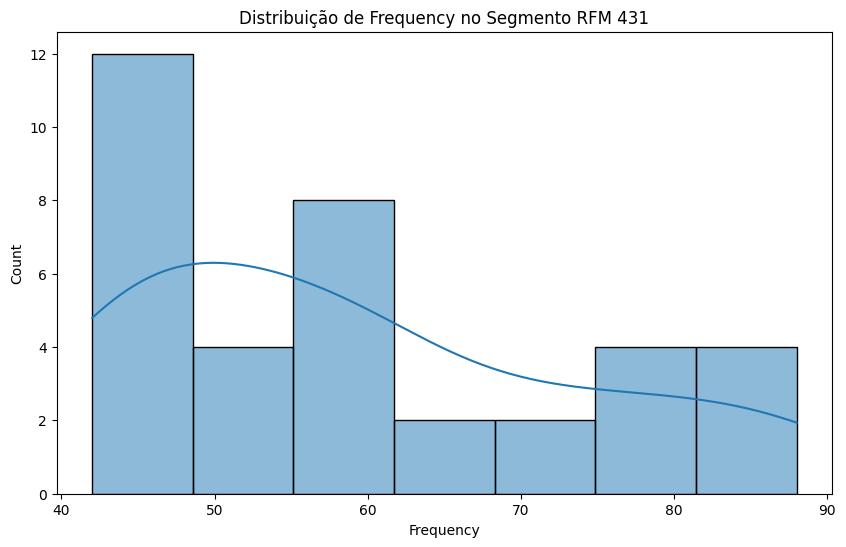

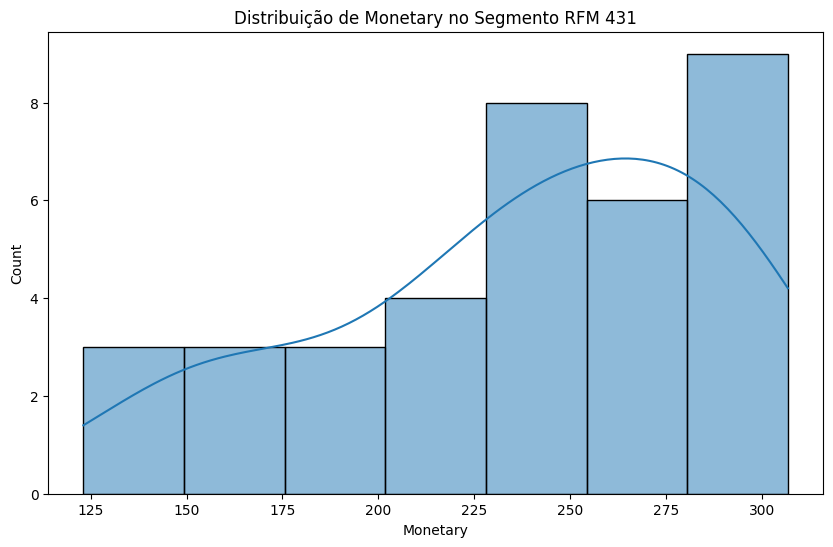



Segmento RFM 332
Número de Clientes: 54
Recência Média: 81.25925925925925
Frequência Média: 63.94444444444444
Monetário Médio: 487.39018518518526


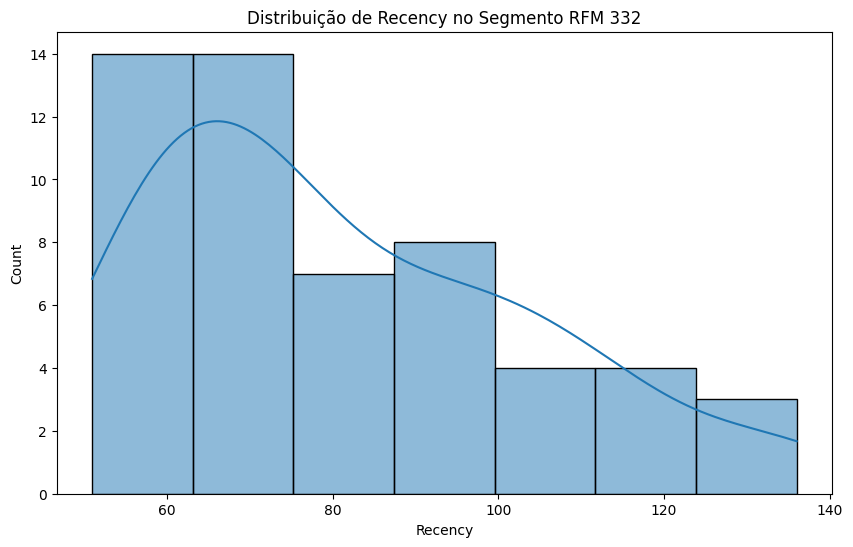

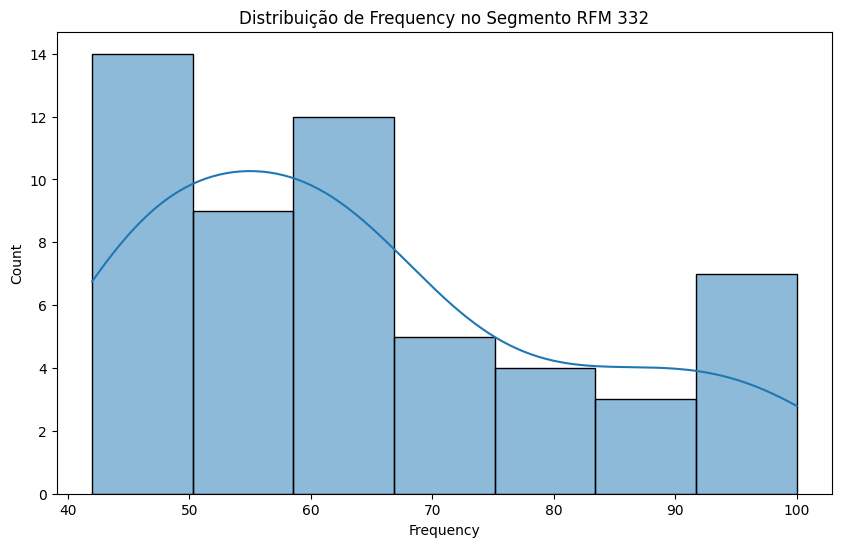

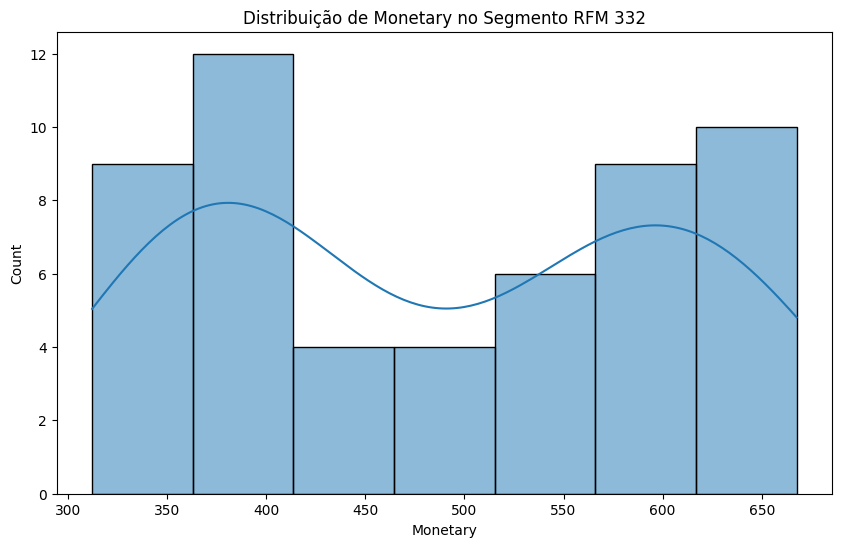



Segmento RFM 231
Número de Clientes: 25
Recência Média: 29.64
Frequência Média: 60.32
Monetário Médio: 224.5812


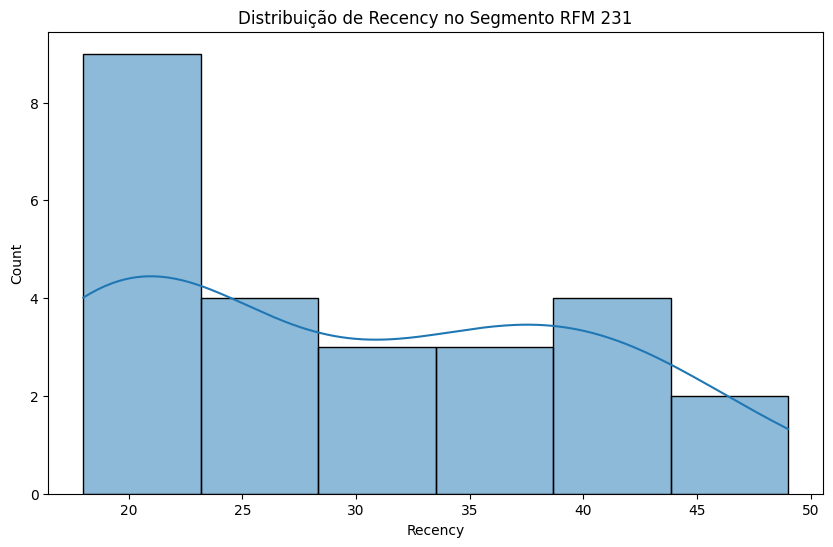

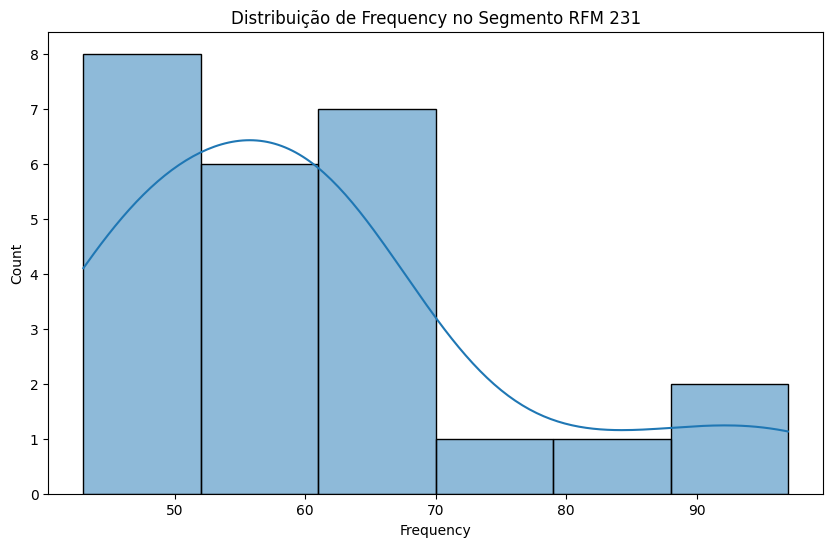

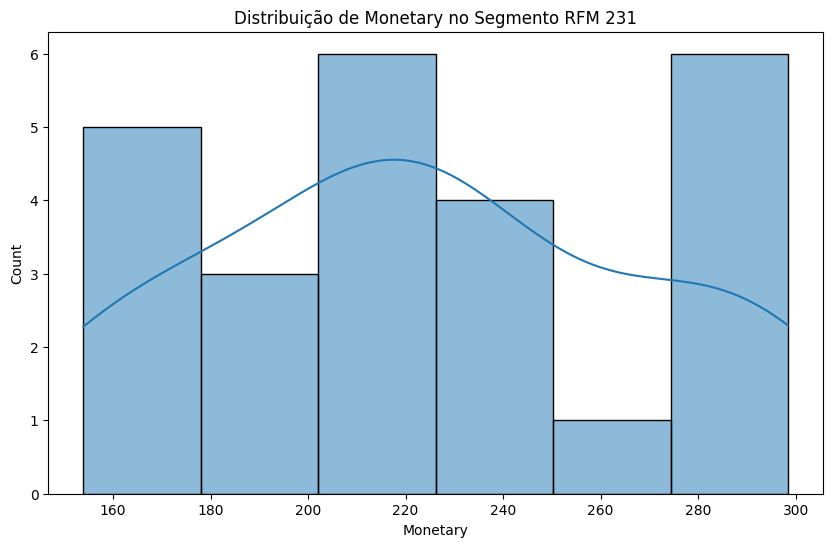



Segmento RFM 131
Número de Clientes: 13
Recência Média: 8.23076923076923
Frequência Média: 56.92307692307692
Monetário Médio: 208.20615384615382


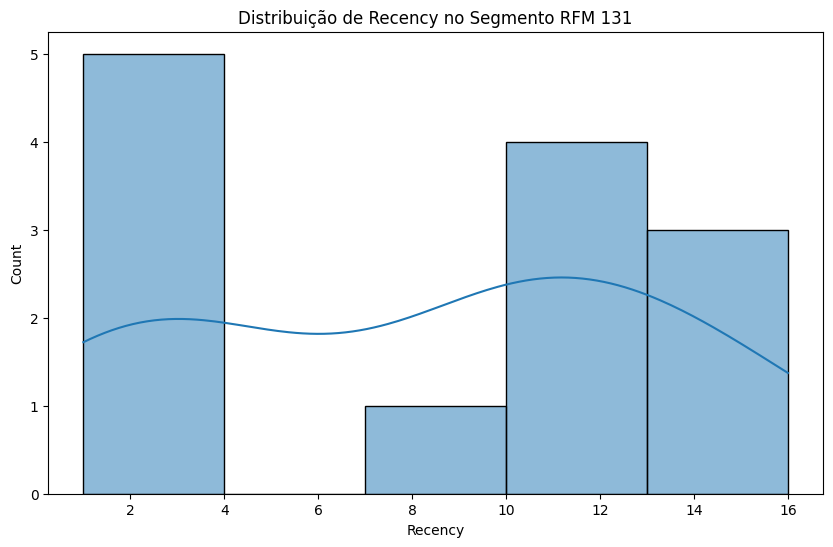

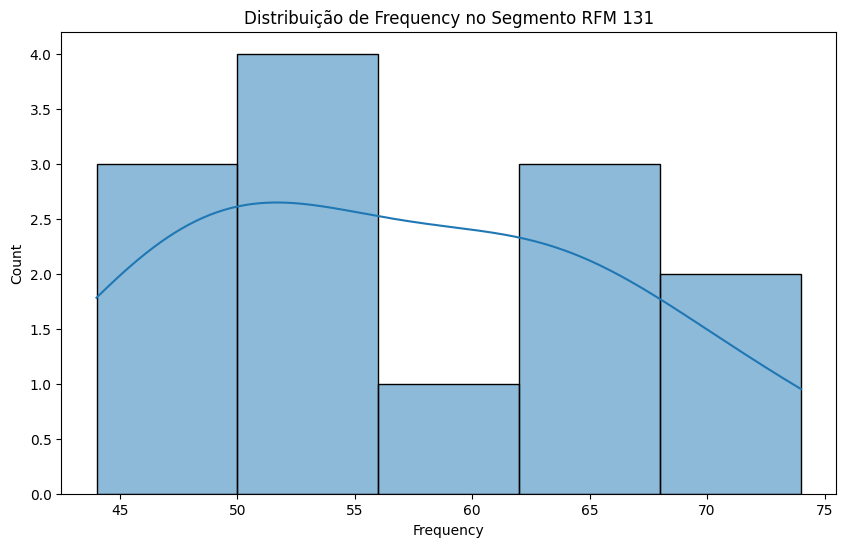

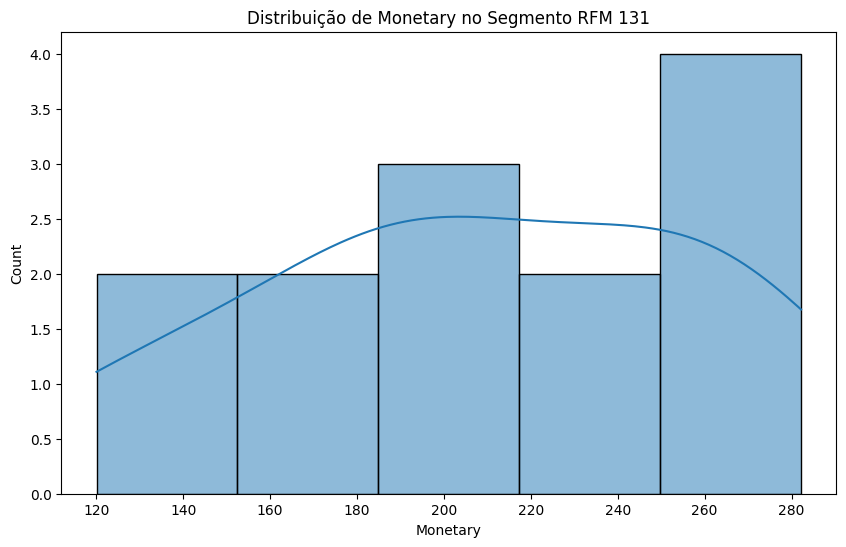



Segmento RFM 214
Número de Clientes: 7
Recência Média: 33.57142857142857
Frequência Média: 7.142857142857143
Monetário Médio: 2478.824285714286


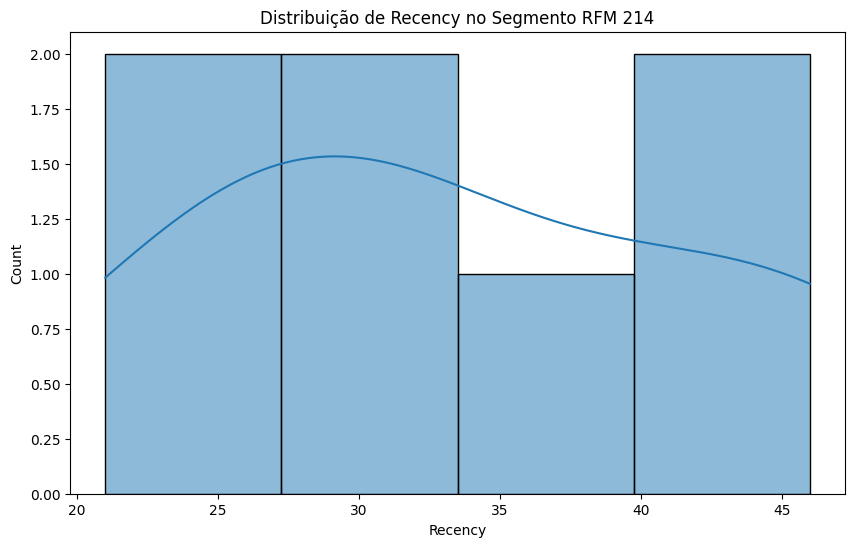

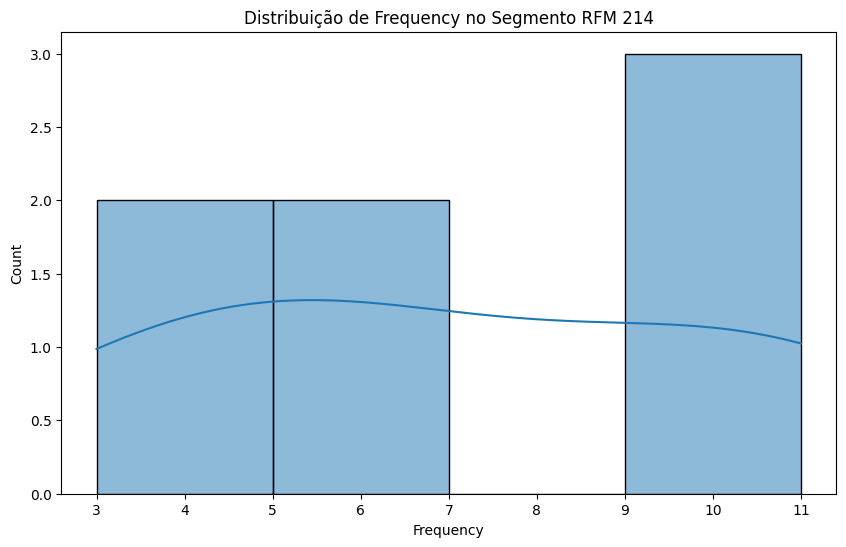

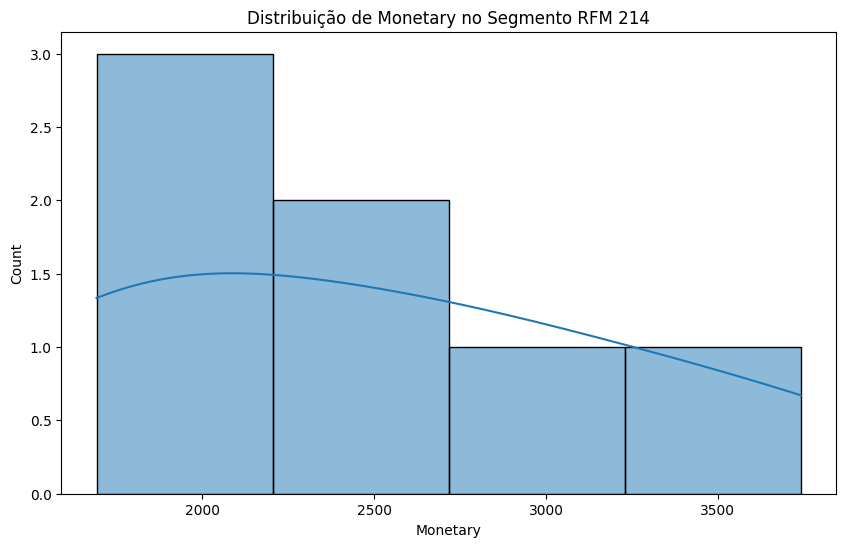



Segmento RFM 442
Número de Clientes: 4
Recência Média: 241.5
Frequência Média: 118.75
Monetário Médio: 481.19499999999994


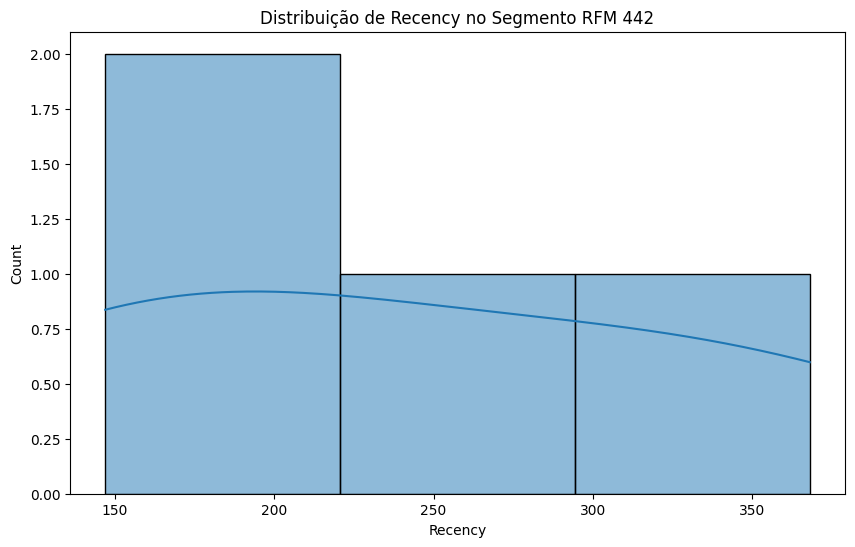

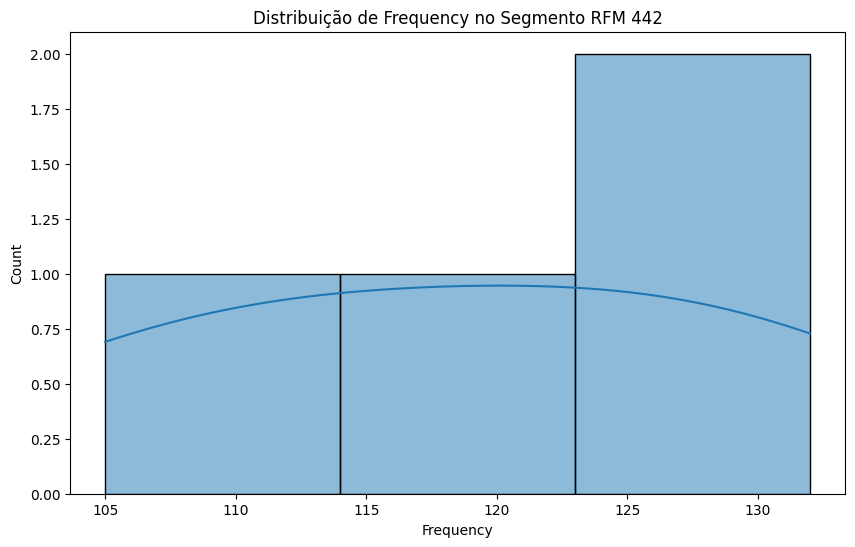

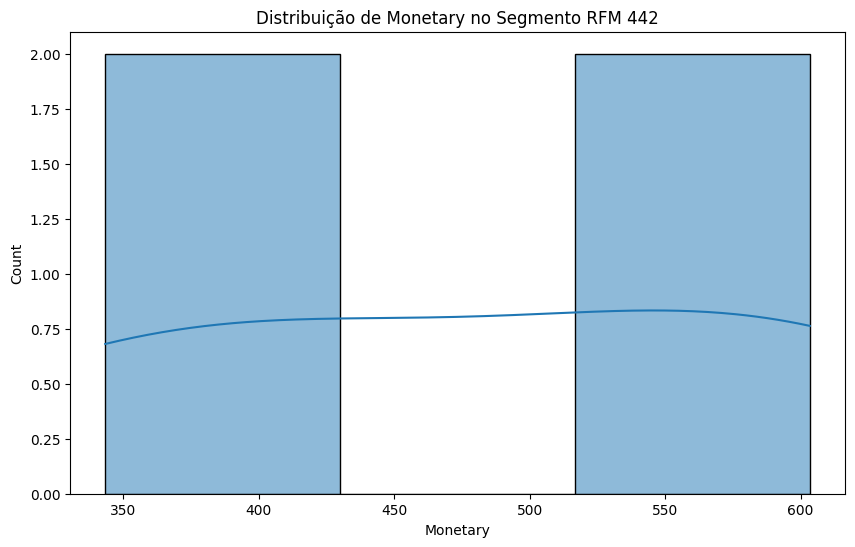



Segmento RFM 141
Número de Clientes: 3
Recência Média: 7.333333333333333
Frequência Média: 115.66666666666667
Monetário Médio: 292.54333333333335


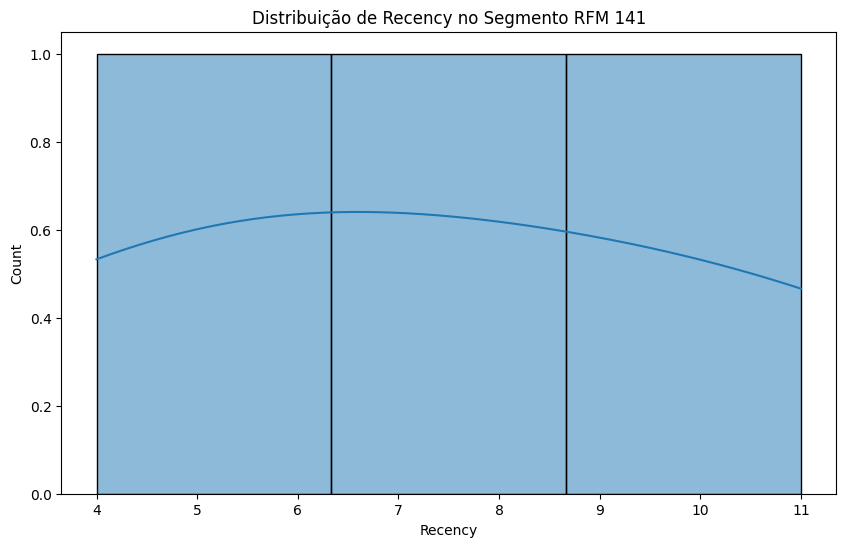

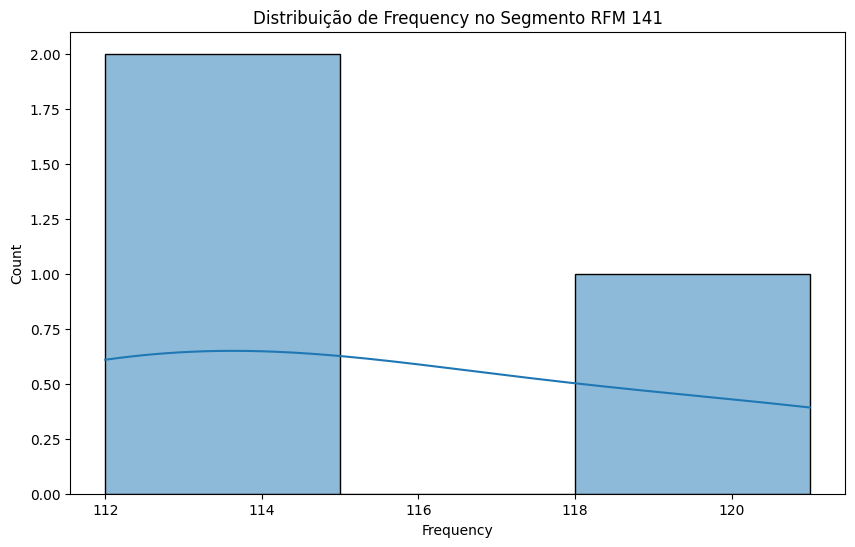

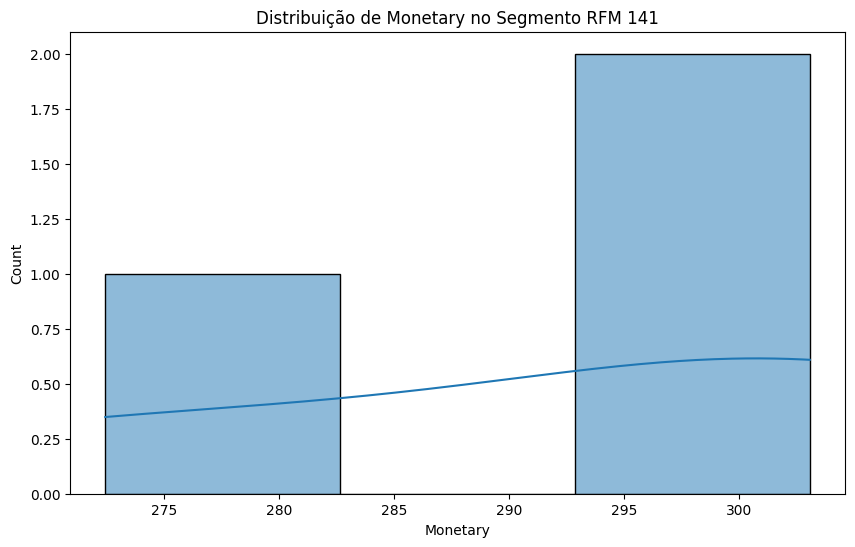

In [ ]:
# Analisar a distribuição das variáveis adicionais em cada segmento
def segment_analysis(rfm_score):
    segment = rfm[rfm['RFM_Score'] == rfm_score]
    print(f"Segmento RFM {rfm_score}")
    print(f"Número de Clientes: {segment.shape[0]}")
    print(f"Recência Média: {segment['Recency'].mean()}")
    print(f"Frequência Média: {segment['Frequency'].mean()}")
    print(f"Monetário Médio: {segment['Monetary'].mean()}")

    # Visualizar distribuição das variáveis originais dentro do segmento
    plt.figure(figsize=(10, 6))
    sns.histplot(segment['Recency'], kde=True)
    plt.title(f'Distribuição de Recency no Segmento RFM {rfm_score}')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(segment['Frequency'], kde=True)
    plt.title(f'Distribuição de Frequency no Segmento RFM {rfm_score}')
    plt.show()

    plt.figure(figsize=(10, 6))
    sns.histplot(segment['Monetary'], kde=True)
    plt.title(f'Distribuição de Monetary no Segmento RFM {rfm_score}')
    plt.show()

    # Sugestões para a empresa
    if rfm_score == '111':
        print("Sugestões: Clientes inativos, considerar estratégias de reativação.")
    elif rfm_score == '444':
        print("Sugestões: Clientes leais e de alto valor, investir em programas de fidelidade.")
    # Adicionar sugestões para outros segmentos conforme necessário
    print("\n")

for rfm_score in rfm['RFM_Score'].unique():
    segment_analysis(rfm_score)


# **Teste de Hipóteses**

Verificar o intervalo de datas no conjunto de dados

In [ ]:
# Verificar o intervalo de datas no conjunto de dados
print("Data mínima:", ecommerce_data['InvoiceDate'].min())
print("Data máxima:", ecommerce_data['InvoiceDate'].max())


Data mínima: 2018-11-29 08:26:00
Data máxima: 2019-12-07 12:50:00


Campanha

In [ ]:
# Exemplo de data da campanha
campaign_date = pd.to_datetime('2019-06-01')


# Dividir os dados em dois grupos
before_campaign = ecommerce_data[ecommerce_data['InvoiceDate'] < campaign_date]
after_campaign = ecommerce_data[ecommerce_data['InvoiceDate'] >= campaign_date]

# Calcular a média das vendas para os dois grupos
mean_sales_before = before_campaign['UnitPrice'].mean()
mean_sales_after = after_campaign['UnitPrice'].mean()

print(f"Média das Vendas Antes da Campanha: {mean_sales_before}")
print(f"Média das Vendas Depois da Campanha: {mean_sales_after}")


Média das Vendas Antes da Campanha: 3.31070742544995
Média das Vendas Depois da Campanha: 3.0024641425443055


Importar a biblioteca de estatísticas

In [ ]:
# Importar a biblioteca de estatísticas
from scipy.stats import ttest_ind

# Realizar o teste t de Student
t_stat, p_value = ttest_ind(before_campaign['UnitPrice'], after_campaign['UnitPrice'])

print(f"Estatística t: {t_stat}")
print(f"Valor p: {p_value}")


Estatística t: 4.2479656863416775
Valor p: 2.1576936444471335e-05


Definir o nível de significância

In [ ]:
# Definir o nível de significância
alpha = 0.05

if p_value < alpha:
    print("Rejeitamos a hipótese nula. Há uma diferença significativa entre as médias das vendas.")
else:
    print("Não rejeitamos a hipótese nula. Não há diferença significativa entre as médias das vendas.")


Rejeitamos a hipótese nula. Há uma diferença significativa entre as médias das vendas.


Sugestão deste analista:

Segmentos RFM e Suas Representações
Segmento RFM 111 (Recência Alta, Frequência Baixa, Valor Monetário Baixo):

Representação: Este segmento representa clientes que estão inativos há bastante tempo. Eles fizeram poucas compras e gastaram pouco dinheiro na loja.

Sugestões:

Implementar campanhas de reativação, como e-mails de "sentimos sua falta" com ofertas especiais.

Oferecer incentivos ou descontos exclusivos para encorajar esses clientes a retornarem.

Segmento RFM 444 (Recência Baixa, Frequência Alta, Valor Monetário Alto):

Representação: Este segmento é composto por clientes leais e de alto valor. Eles compram com frequência e gastam bastante na loja.

Sugestões:

Investir em programas de fidelidade para recompensar a lealdade desses clientes.

Oferecer prévias exclusivas de novos produtos ou vendas antecipadas para esses clientes VIP.

Segmento RFM 341 (Recência Média, Frequência Alta, Valor Monetário Médio):

Representação: Esses clientes compram com frequência, mas não gastam tanto quanto os do segmento 444. Eles ainda têm um valor significativo para a loja.

Sugestões:

Oferecer promoções de produtos complementares para aumentar o valor médio das compras.

Enviar recomendações de produtos baseadas em suas compras anteriores.

Segmento RFM 123 (Recência Alta, Frequência Baixa, Valor Monetário Médio):

Representação: Clientes que fizeram compras recentemente, mas não compram com frequência e têm um valor monetário médio.

Sugestões:

Encorajar a fidelização com campanhas de retenção, como ofertas de "compre novamente".

Oferecer programas de recompensas para aumentar a frequência de compras.

Segmento RFM 432 (Recência Baixa, Frequência Alta, Valor Monetário Baixo):

Representação: Clientes que compram frequentemente, mas gastam pouco a cada compra.

Sugestões:

Criar pacotes ou combos de produtos para aumentar o valor médio por compra.

Oferecer promoções de "compre mais e economize" para incentivar maiores gastos.

Em resumo, coletar feedback dos segmentos para entender melhor suas necessidades e ajustar ofertas e comunicação. Utilizar campanhas de marketing personalizadas com base nas preferências e histórico de compras dos clientes. Manter comunicação contínua via e-mails, redes sociais e outras plataformas para engajamento.